In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.special import rel_entr
from scipy.stats import gamma
import json
import sys
from statistics import median

def margin(a):
    b = a
    for i in range(len(a)):
        if a[i] == 0:
            b[i] = 10**(-5)
    return b

In [2]:
def read_AQUA_file(filename):
    AQUA_file = open(filename, "r")
    AQUA_data = json.load(AQUA_file)
    res = AQUA_data['data']

    plt.plot(res[0], res[1])
    print(min(res[0]), max(res[0]))

    AQUA_mean = (sum(np.multiply(res[0], res[1])))
    AQUA_variance = sum(np.multiply(np.square(res[0]), res[1])) - AQUA_mean**2

    return AQUA_mean, AQUA_variance

def gt_from_sampling(filename, var_list):
    mean_list = {}
    variance_list = {}
    gt_file = open(filename, "r")
    gt_lines = gt_file.readlines()
    for var_name in var_list:
        for i in gt_lines:
            j = i.split(' ')
            if j[0] == var_name:
                j_temp = []
                for k in j:
                    if k != "":
                        j_temp.append(k)
                mean_list[var_name] = float(j_temp[1])
                variance_list[var_name] = float(j_temp[3])**2
    return mean_list, variance_list


def read_AQUA_time(filename):
    a = open(filename, "r")
    data = a.readlines()
    time = []
    for i in data:
        if i[0:8] == "Analysis":
            time.append(float(i.split(',')[-1])*1000)
    return (median(time))

colors = ['blue', 'green', 'purple', 'yellow', 'black', 'red', 'brown', 'pink', 'gray', 'olive', 'cyan', 'violet', 'coral']
AQUA_color = 'orange'

def plotting_dice_data(mean_or_var, title, var_name, result_file, 
                        lowerlimit, upperlimit, offset, gt, AQUA_time, 
                            AQUA_val, annot, s_or_ms, ylab = None, AQUA_plot = None):
    fig, ax = plt.subplots()
    if ylab == None:
        ax.set_ylabel('Absolute Error of ' + mean_or_var)
    else:
        ax.set_ylabel(ylab)
    ax.set_xscale("log")
    ax.set_xlabel('Time(in ms)')
    ax.set_yscale("log")
    ax.set_title(title + " - " + var_name)

    fig.set_facecolor('white')
    fig.set_size_inches(13.5, 9)
    legend = []

    index = 0
    if mean_or_var == 'variance':
        index = 2

    data = open(result_file, "r")
    data_lines = data.readlines()

    # print (data_lines)
    min_res = []

    for no in range(lowerlimit, upperlimit):
        dice = [(float(j.split(',')[1]), j) for j in data_lines if float(j.split(',')[0]) == no]
        dice.sort()

        dice = [j[1] for j in dice]

        t = []
        abs_err = []
        time = []


        for j in range(len(dice)):
            temp = dice[j].split(',')
            t.append((temp[0], temp[1], temp[3]))

            # print(temp[5 + index], gt)
            temp2 = abs(float(temp[5 + index]) + (offset)*1/2**(no) - gt)
            # print(temp2)
            abs_err.append(temp2)

            temp3 = float(temp[4 + index])
            if s_or_ms == 's':
                temp3 = temp3*1000
            time.append(temp3)
        print (abs_err)

        ax.plot(time, abs_err, '-o', color= colors[no])
        # print(time, abs_err)

        if annot:
            for i in range(len(t)):
                ax.annotate(t[i], (time[i], abs_err[i]))

        legend.append("BitBlast " + str(no))
        min_res.append(min(abs_err))
        

    AQUA_pt = (AQUA_time, abs(AQUA_val - gt))
    if AQUA_plot == None:
        ax.scatter(AQUA_pt[0], AQUA_pt[1], color = AQUA_color)
        ax.annotate('AQUA', AQUA_pt)


    ax.legend(legend + ["AQUA"])
    if mean_or_var == "mean":
        bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_expectation.csv", "a")
        bpfile.write(title + ", " + var_name + ", " + str(min(min_res)) + ", " + str(AQUA_pt[1]) + "\n")
        bpfile.close()
    else:
        bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
        bpfile.write(title + ", " + var_name + ", " + str(min(min_res)) + ", " + str(AQUA_pt[1]) + "\n")
        bpfile.close()

    # print(min(min_res), (AQUA_pt[1]))

    fig.savefig("/home/poorvagarg/.julia/dev/Dice/benchmarks/" + title + "/"+title + "_" + var_name + "_" + mean_or_var + ".png")
    return fig, ax

def plotting_dice_bits(mean_or_var, title, var_name, result_file, 
                        lowerlimit, upperlimit, offset, gt, AQUA_time, 
                            AQUA_val, annot, s_or_ms, ylab = None, AQUA_plot = None):
    fig, ax = plt.subplots()
    if ylab == None:
        ax.set_ylabel('Absolute Error of ' + mean_or_var)
    else:
        ax.set_ylabel(ylab)
    ax.set_xscale("log")
    ax.set_xlabel('Time(in ms)')
    ax.set_yscale("log")
    ax.set_title(title + " - " + var_name)

    fig.set_facecolor('white')
    fig.set_size_inches(13.5, 9)
    legend = []

    index = 0
    if mean_or_var == 'variance':
        index = 2

    data = open(result_file, "r")
    data_lines = data.readlines()

    # print (data_lines)

    for no in range(lowerlimit, upperlimit):
        dice = [(float(j.split(',')[0]), j) for j in data_lines if float(j.split(',')[1]) == no]
        dice.sort()

        dice = [j[1] for j in dice]

        t = []
        abs_err = []
        time = []


        for j in range(len(dice)):
            temp = dice[j].split(',')
            t.append((temp[0], temp[1], temp[3]))

            print(temp[index+5], gt)
            temp2 = abs(float(temp[5 + index]) + (offset)*1/2**(float(temp[0])) - gt)
            print(temp2)
            abs_err.append(temp2)

            temp3 = float(temp[4 + index])
            if s_or_ms == 's':
                temp3 = temp3*1000
            time.append(temp3)
        # print (abs_err)

        ax.plot(time, abs_err, '-o', color= colors[no])
        # print(time, abs_err)

        if annot:
            for i in range(len(t)):
                ax.annotate(t[i], (time[i], abs_err[i]))

        legend.append("BitBlast " + str(no))

    AQUA_pt = (AQUA_time, abs(AQUA_val - gt))
    if AQUA_plot == None:
        ax.scatter(AQUA_pt[0], AQUA_pt[1], color = AQUA_color)
        ax.annotate('AQUA', AQUA_pt)


    ax.legend(legend + ["AQUA"])

    fig.savefig("/home/poorvagarg/.julia/dev/Dice/benchmarks/" + title + "/"+title + "_" + var_name + "_" + mean_or_var + ".png")
    return fig, ax
    

In [3]:
def plotting_abs_exp(mean_or_var, title, var_name, result_file, 
                        lowerlimit, upperlimit, offset, gt, AQUA_time, 
                            AQUA_val, annot, s_or_ms, other_pts, ylab = None, AQUA_plot = None):
    fig, ax = plt.subplots()
    if ylab == None:
        ax.set_ylabel('Absolute ' + mean_or_var)
    else:
        ax.set_ylabel(ylab)
    # ax.set_xscale("log")
    ax.set_xlabel('Log(pieces)')
    ax.set_yscale("log")
    ax.set_title(title + " - " + var_name)

    fig.set_facecolor('white')
    fig.set_size_inches(13.5, 9)
    legend = []

    index = 0
    if mean_or_var == 'variance':
        index = 2

    data = open(result_file, "r")
    data_lines = data.readlines()

    # print (data_lines)
    min_res = []

    for no in range(lowerlimit, upperlimit):
        dice = [(float(j.split(',')[1]), j) for j in data_lines if float(j.split(',')[0]) == no]
        dice.sort()

        dice = [j[1] for j in dice]

        t = []
        abs_err = []
        time = []


        for j in range(len(dice)):
            temp = dice[j].split(',')
            
            if (float(temp[1]) < 3.0):
                continue
            t.append((temp[0], temp[1], temp[3]))

            # print(temp[5 + index], gt)
            if no != upperlimit-1
                temp2 = abs(float(temp[5 + index]) + (offset)*1/2**(no) - gt)
            else:
                temp2 = abs(float(temp[5 + index]) + (offset)*1/2**float(temp[1]) - gt)
            # print(temp2)
            abs_err.append(temp2)

            temp3 = float(temp[4 + index])
            if s_or_ms == 's':
                temp3 = temp3*1000
            temp3 = temp[1]
            # print(temp3)
            time.append(temp3)
        # print (abs_err)

        ax.plot(time, abs_err, '-o', color= colors[no])
        # print(time, abs_err)

        if annot or no==upperlimit-1:
            # print(len(t))
            # print(len(time))
            # print(len(abs_err))
            for i in range(len(t)):

                ax.annotate((t[i][1], t[i][2]), (time[i], abs_err[i]))

        if no == upperlimit-1:
            legend.append("Brute force (bits, BDD size)")
        else:
            legend.append("Bitblast " + str(no))
        min_res.append(min(abs_err))
        

    AQUA_time = 0.0
    AQUA_pt = (AQUA_time, abs(AQUA_val - gt))
    if AQUA_plot == None:
        ax.scatter(AQUA_pt[0], AQUA_pt[1], color = AQUA_color)
        ax.annotate('AQUA', AQUA_pt)

    ext_legend = ['AQUA']
    for i in other_pts:
        ax.scatter(i[2], i[1], color=colors[11])
        ax.annotate(i[0], (i[2], i[1]))
        ext_legend.append(i[0])

    ax.legend(legend + ext_legend)
    if mean_or_var == "mean":
        bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_expectation.csv", "a")
        bpfile.write(title + ", " + var_name + ", " + str(min(min_res)) + ", " + str(AQUA_pt[1]) + "\n")
        bpfile.close()
    else:
        bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
        bpfile.write(title + ", " + var_name + ", " + str(min(min_res)) + ", " + str(AQUA_pt[1]) + "\n")
        bpfile.close()

    # print(min(min_res), (AQUA_pt[1]))

    fig.savefig("/home/poorvagarg/.julia/dev/Dice/benchmarks/" + title + "/"+title + "_" + var_name + "_" + mean_or_var + ".png")
    return fig, ax
    

SyntaxError: invalid syntax (<ipython-input-3-0be9a71f37ed>, line 47)

In [ ]:
def plotting_exp_bits(mean_or_var, title, var_name, result_file, 
                        lowerlimit, upperlimit, offset, gt, AQUA_time, 
                            AQUA_val, annot, s_or_ms, other_pts, ylab = None, AQUA_plot = None):
    fig, ax = plt.subplots()
    if ylab == None:
        ax.set_ylabel('Absolute Error of ' + mean_or_var)
    else:
        ax.set_ylabel(ylab)
    # ax.set_xscale("log")
    ax.set_xlabel('Bits')
    ax.set_yscale("log")
    ax.set_title(title + " - " + var_name)

    fig.set_facecolor('white')
    fig.set_size_inches(13.5, 9)
    legend = []

    index = 0
    if mean_or_var == 'variance':
        index = 2

    data = open(result_file, "r")
    data_lines = data.readlines()

    # print (data_lines)

    for no in range(lowerlimit, upperlimit):
        dice = [(float(j.split(',')[0]), j) for j in data_lines if float(j.split(',')[1]) == no]
        dice.sort()

        dice = [j[1] for j in dice]

        t = []
        abs_err = []
        time = []


        for j in range(len(dice)):
            temp = dice[j].split(',')
            t.append((temp[0], temp[1], temp[3]))

            print(temp[index+5], gt)
            temp2 = abs(float(temp[5 + index]) + (offset)*1/2**(float(temp[0])) - gt)
            print(temp2)
            abs_err.append(temp2)

            temp3 = float(temp[4 + index])
            if s_or_ms == 's':
                temp3 = temp3*1000
            temp3 = temp[0]
            time.append(temp3)
        # print (abs_err)

        ax.plot(time, abs_err, '-o', color= colors[no])
        # print(time, abs_err)

        if annot:
            for i in range(len(t)):
                ax.annotate(t[i], (time[i], abs_err[i]))

        legend.append("BitBlast " + str(no))

    AQUA_pt = (AQUA_time, abs(AQUA_val - gt))
    if AQUA_plot == None:
        ax.scatter(AQUA_pt[0], AQUA_pt[1], color = AQUA_color)
        ax.annotate('AQUA', AQUA_pt)


    ax.legend(legend + ["AQUA"])

    fig.savefig("/home/poorvagarg/.julia/dev/Dice/benchmarks/" + title + "/"+title + "_" + var_name + "_" + mean_or_var + ".png")
    return fig, ax

In [5]:
a = open("/home/poorvagarg/.julia/dev/Dice/tow_acc.txt", "r")
b = open("/home/poorvagarg/.julia/dev/Dice/tow_bdd.txt", "r")
time_data = open("/home/poorvagarg/.julia/dev/Dice/tow_timw.txt", "r")
acc = a.readlines()
bdd = b.readlines()
runtime = time_data.readlines()

0.00011848338264708325


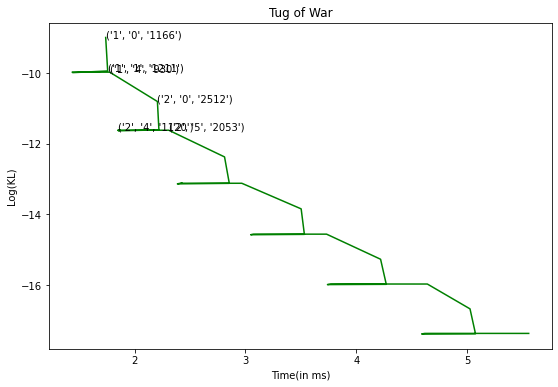

In [5]:
y = [math.log(sum(rel_entr([0.5, 0.5], [float(j.split(',')[2]), 1 - float(j.split(',')[2])]))) for j in acc]
x = [math.log(float(j.split('(')[1][:-4])) for j in runtime]

x2 = [abs(float(j.split(',')[2]) - 0.5) for j in acc]
print(min(x2))


tic = [(j.split(',')[0], j.split(',')[1], j.split(',')[3][:-1]) for j in bdd]

fig1, ax1 = plt.subplots()

ax1.plot(x, y, color= "green")
ax1.set_ylabel('Log(KL)')
ax1.set_xlabel('Time(in ms)')
ax1.set_title("Tug of War")
for i in [0, 1, 4, 5, 9, 10]:
    ax1.annotate(tic[i], (x[i], y[i]))
fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

<ipython-input-5-6ff49ab47dd6>:14: RuntimeWarning: invalid value encountered in double_scalars
  y = [math.log(sum(rel_entr([0.5, 0.5], [float(j.split(' ')[1]), 1 - float(j.split(' ')[1])]))) for j in mcmc]


7


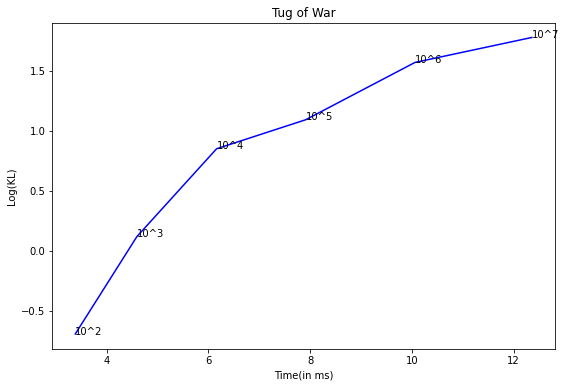

In [5]:
c = open("/home/poorvagarg/.julia/dev/Dice/tow_mcmc.txt", "r")
mcmc = c.readlines()
# mcmc = mcmc]

fig1, ax1 = plt.subplots()

ax1.set_ylabel('Log(KL)')
ax1.set_xlabel('Time(in ms)')
ax1.set_title("Tug of War")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

y = [math.log(sum(rel_entr([0.5, 0.5], [float(j.split(' ')[1]), 1 - float(j.split(' ')[1])]))) for j in mcmc]
x = [math.log(float(j.split(' ')[0])) for j in mcmc]

print(len(x))

t = [str(10) + "^" + str(i) for i in range(1, 8)]

ax1.plot(x, y, color= "blue")
for i in range(len(t)):
    ax1.annotate(t[i], (x[i], y[i]))



[5.499215308914927, 7.113142108707088, 9.345439285397797, 11.58042989594566, 13.830672532106103, 16.18252554119577, 18.498661644484688]


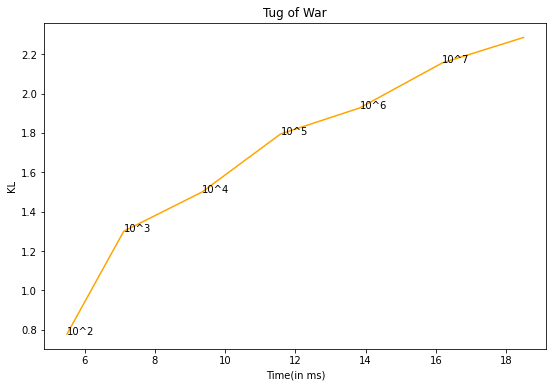

In [6]:
d = open("/home/poorvagarg/.julia/dev/Dice/tow_rej.txt", "r")
rej = d.readlines()
rej = rej[1:]

fig1, ax1 = plt.subplots()

ax1.set_ylabel('KL')
ax1.set_xlabel('Time(in ms)')
ax1.set_title("Tug of War")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

y = [math.log(sum(rel_entr([0.5, 0.5], [float(j.split(' ')[1]), 1 - float(j.split(' ')[1])]))) for j in rej]
x = [math.log(float(j.split(' ')[0])) for j in rej]

print(x)

t = [str(10) + "^" + str(i) for i in range(2, 8)]

ax1.plot(x, y, color= "orange")
for i in range(len(t)):
    ax1.annotate(t[i], (x[i], y[i]))

['22.0 inf nan\n', '29.5 0.10263197561265668 0.4387307114576635\n', '99.0 0.027082416365937674 0.11245187152444017\n', '474.0 0.0023216302393432656 0.005076798885775345\n', '2724.5 0.0006442101020790987 0.0012488747462098986\n', '23394.0 1.658048924769442e-05 4.331232563473445e-05\n', '232246.5 1.7886810419223643e-06 7.16560508941726e-06']
7
[244.5, 1228.0, 11446.5, 106983.5, 1015277.5, 10665508.0, 108110201.0]


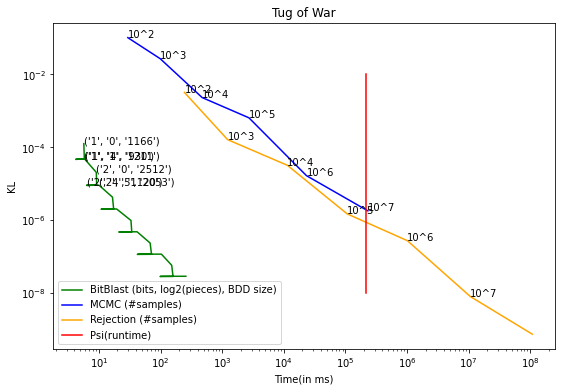

In [7]:
y = [(sum(rel_entr([0.5, 0.5], [float(j.split(',')[2]), 1 - float(j.split(',')[2])]))) for j in acc]
x = [(float(j.split('(')[1][:-4])) for j in runtime]


tic = [(j.split(',')[0], j.split(',')[1], j.split(',')[3][:-1]) for j in bdd]

fig1, ax1 = plt.subplots()

ax1.plot(x, y, color= "green")
ax1.set_ylabel('KL')
ax1.set_xlabel('Time(in ms)')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Tug of War")
for i in [0, 1, 4, 5, 9, 10]:
    ax1.annotate(tic[i], (x[i], y[i]))
fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

print(mcmc)
y = [(float(j.split(' ')[1])) for j in mcmc]
x = [(float(j.split(' ')[0])) for j in mcmc]

print(len(x))

t = [str(10) + "^" + str(i) for i in range(1, 8)]

ax1.plot(x, y, color= "blue")
for i in range(len(t)):
    ax1.annotate(t[i], (x[i], y[i]))

y = [(float(j.split(' ')[1])) for j in rej]
x = [(float(j.split(' ')[0])) for j in rej]

print(x)

t = [str(10) + "^" + str(i) for i in range(2, 8)]

ax1.plot(x, y, color= "orange")
for i in range(len(t)):
    ax1.annotate(t[i], (x[i], y[i]))

ax1.plot([213305.5, (213305.5)], [10**(-2), 10**(-8)], color="red")

ax1.legend(["BitBlast (bits, log2(pieces), BDD size)", "MCMC (#samples)", "Rejection (#samples)", "Psi(runtime)"])

fig1.savefig("tow.png")

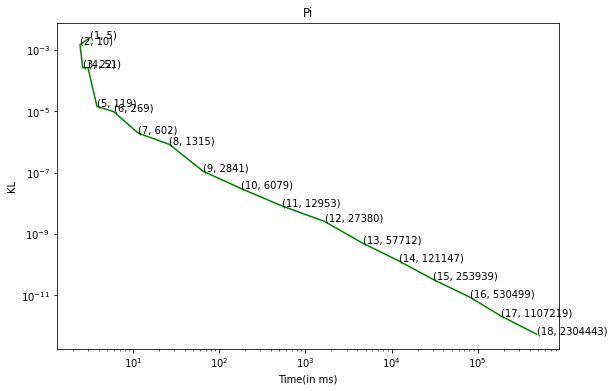

In [8]:
a = open("/home/poorvagarg/.julia/dev/Dice/pi_results.txt", "r")
pi_julia_acc = a.readlines()
# pi_julia_acc = pi_julia_acc[0:15]

# pi_julia_accuracy = readdlm("/home/poorvagarg/.julia/dev/Dice/pi_results.txt", ',', Float64, '\n')
pi_julia_bdd = [5, 10, 22, 51
, 119
, 269
,602
,1315
,2841
,6079
,12953
,27380
,57712
,121147
,253939
,530499
,1107219
,2304443]


t = [i for i in range(1, 19)]
pi_kld = [(float(j.split(',')[2])) for j in pi_julia_acc]
pi_time = [(float(j.split(',')[3])) for j in pi_julia_acc]
tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

fig1, ax1 = plt.subplots()

ax1.plot(pi_time, pi_kld, color= "green")
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Pi")
for i in range(len(tic)):
    ax1.annotate(tic[i], (pi_time[i], pi_kld[i]))

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)



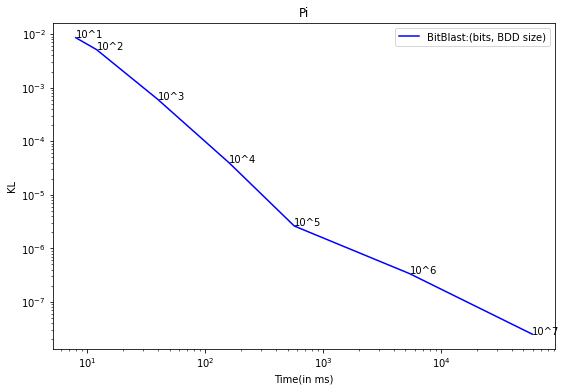

In [9]:
a = open("/home/poorvagarg/.julia/dev/Dice/pi_sample.txt", "r")
pi_acc = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Pi")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = [str(10) + "^" + str(i) for i in range(1, 8)]
pi_kld = [float(j.split(' ')[1]) for j in pi_acc]
pi_time = [float(j.split(' ')[0]) for j in pi_acc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

ax1.plot(pi_time, pi_kld, color= "blue")
ax1.legend(["BitBlast:(bits, BDD size)", "Sampling"])

for i in range(len(t)):
    ax1.annotate(t[i], (pi_time[i], pi_kld[i]))
fig1.savefig("pi.png")

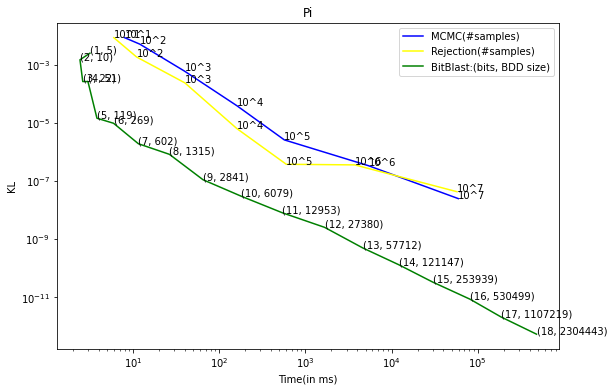

In [10]:
a = open("/home/poorvagarg/.julia/dev/Dice/pi_sample.txt", "r")
pi_acc = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Pi")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = [str(10) + "^" + str(i) for i in range(1, 8)]
pi_kld = [float(j.split(' ')[1]) for j in pi_acc]
pi_time = [float(j.split(' ')[0]) for j in pi_acc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

ax1.plot(pi_time, pi_kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (pi_time[i], pi_kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/pi_rejection.txt", "r")
pi_acc = a.readlines()

t = [str(10) + "^" + str(i) for i in range(1, 8)]
pi_kld = [float(j.split(' ')[1]) for j in pi_acc]
pi_time = [float(j.split(' ')[0]) for j in pi_acc]

ax1.plot(pi_time, pi_kld, color= "yellow")
# ax1.legend(["BitBlast:(bits, BDD size)", "Sampling"])

for i in range(len(t)):
    ax1.annotate(t[i], (pi_time[i], pi_kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/pi_results.txt", "r")
pi_julia_acc = a.readlines()
# pi_julia_acc = pi_julia_acc[0:15]

# pi_julia_accuracy = readdlm("/home/poorvagarg/.julia/dev/Dice/pi_results.txt", ',', Float64, '\n')
pi_julia_bdd = [5, 10, 22, 51
, 119
, 269
,602
,1315
,2841
,6079
,12953
,27380
,57712
,121147
,253939
,530499
,1107219
,2304443]


t = [i for i in range(1, 19)]
pi_kld = [(float(j.split(',')[2])) for j in pi_julia_acc]
pi_time = [(float(j.split(',')[3])) for j in pi_julia_acc]
tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]
ax1.plot(pi_time, pi_kld, color= "green")
for i in range(len(tic)):
    ax1.annotate(tic[i], (pi_time[i], pi_kld[i]))

ax1.legend(["MCMC(#samples)", "Rejection(#samples)", "BitBlast:(bits, BDD size)"])
fig1.savefig("pi.png")

['0.0', '1', '0', '27', '53', '0.16658619011506628', 'TrialEstimate(3.603 ms)\n', '3.603']
['0.0,1,1,19,38,0.6094160643256045,TrialEstimate(2.913 ms)\n,2.913', '0.0,2,2,21,41,0.6114580225852986,TrialEstimate(3.768 ms)\n,3.768', '0.0,3,1,27,50,0.6115084233728768,TrialEstimate(3.495 ms)\n,3.495', '0.0,4,0,33,59,0.45845272261044445,TrialEstimate(3.716 ms)\n,3.716', '0.0,5,0,51,93,0.5240342806796747,TrialEstimate(3.394 ms)\n,3.394', '0.0,6,0,41,71,0.5644034958080438,TrialEstimate(4.051 ms)\n,4.051', '0.0,7,1,43,74,0.6115107913645371,TrialEstimate(4.596 ms)\n,4.596', '0.0,8,0,69,123,0.5989237701888831,TrialEstimate(4.443 ms)\n,4.443', '0.0,9,0,53,89,0.6052484883884656,TrialEstimate(4.042 ms)\n,4.042', '0.0,10,0,81,143,0.6051967376113362,TrialEstimate(4.622 ms)\n,4.622', '0.0,11,0,87,153,0.6083373812277869,TrialEstimate(4.747 ms)\n,4.747', '0.0,12,0,93,163,0.6099199585164732,TrialEstimate(4.595 ms)\n,4.595', '0.0,13,1,67,110,0.6115107913669062,TrialEstimate(5.444 ms)\n,5.444', '0.0,14,0,105,

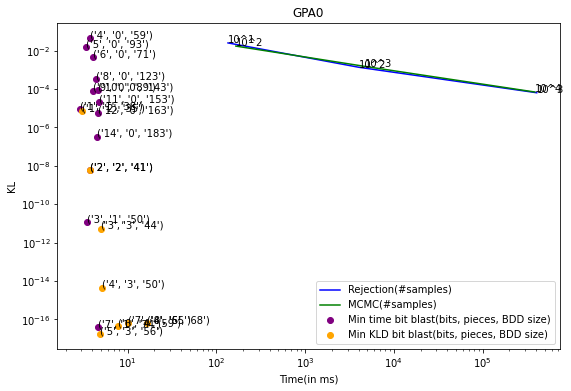

In [11]:
a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_rej_0.txt", "r")
rej = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("GPA0")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = ['10^1', '10^2', '10^3']
kld = [float(j.split(' ')[1]) for j in rej]
time = [float(j.split(' ')[0]) for j in rej]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

ax1.plot(time, kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))


a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_mcmc_0.txt", "r")
mcmc = a.readlines()


t = ['10^2', '10^3', '10^4']
kld = [float(j.split(' ')[2]) for j in mcmc]
time = [float(j.split(' ')[1]) for j in mcmc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

ax1.plot(time, kld, color= "green")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice if j.split(',')[0] == '0.0']
for j in range(len(dice)):
    temp = dice[j].split(',')
    temp2 = temp[-1].split(' ')
    if temp2[-1][0] == 'm':
        temp3 = float(temp2[0].split('(')[1])
    else:
        temp3 = float(temp2[0].split('(')[1]) * 1000
    
    dice[j] = dice[j] + ',' + str(temp3)
print(dice[0].split(','))

dice_min = []
for i in range(1,15):
    min_time = 100000
    min_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[-1]) < min_time:
                min_time = float(temp[-1])
                min_j = dice[j]
    dice_min.append(min_j)

print(dice_min)

dice_max = []
for i in range(1,15):
    max_time = 0.00
    max_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[5]) > max_time:
                max_time = float(temp[5])
                max_j = dice[j]

    dice_max.append(max_j)

print(dice_max)



    

prob = [0.6115107913669062, 1 - 0.6115107913669062]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]

ax1.scatter(time, kld, color= "purple")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

dice_min = dice_max
prob = [0.6115107913669062, 1 - 0.6115107913669062]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
minprob = [str(abs(prob[0] - float(j.split(',')[5]))) for j in dice_min]
print(min(minprob) + "minprob")
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]

ax1.scatter(time, kld, color= "orange")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

ax1.legend(["Rejection(#samples)", "MCMC(#samples)", "Min time bit blast(bits, pieces, BDD size)", "Min KLD bit blast(bits, pieces, BDD size)"])
fig1.savefig("gpa0.png")

[75.5, 213.0, 5843.5, 572454.5] [1e-05, 1e-05, 1e-05, 1e-05]
['4.0', '1', '0', '17', '23', '0.03883495145631074', 'TrialEstimate(4.883 ms)\n', '4.883']
['4.0,1,1,16,22,0.01981448648395271,TrialEstimate(2.608 ms)\n,2.608', '4.0,2,0,21,27,0.07476635514018704,TrialEstimate(2.683 ms)\n,2.683', '4.0,3,0,25,31,0.13913043478260897,TrialEstimate(2.720 ms)\n,2.72', '4.0,4,0,26,32,0.24427480915337976,TrialEstimate(2.768 ms)\n,2.768', '4.0,5,0,33,39,0.3926380369687647,TrialEstimate(2.929 ms)\n,2.929', '4.0,6,0,32,38,0.5638766484288876,TrialEstimate(2.960 ms)\n,2.96', '4.0,7,0,35,41,0.7211267334555951,TrialEstimate(3.017 ms)\n,3.017', '4.0,8,0,45,51,0.8379710167464491,TrialEstimate(3.230 ms)\n,3.23', '4.0,9,0,41,47,0.9118431143816516,TrialEstimate(3.267 ms)\n,3.267', '4.0,10,0,53,59,0.9538945175525642,TrialEstimate(3.497 ms)\n,3.497', '4.0,11,0,57,63,0.9764018832537384,TrialEstimate(3.653 ms)\n,3.653', '4.0,12,0,61,67,0.9880597015145128,TrialEstimate(3.805 ms)\n,3.805']
['4.0,1,0,17,23,0.038834951

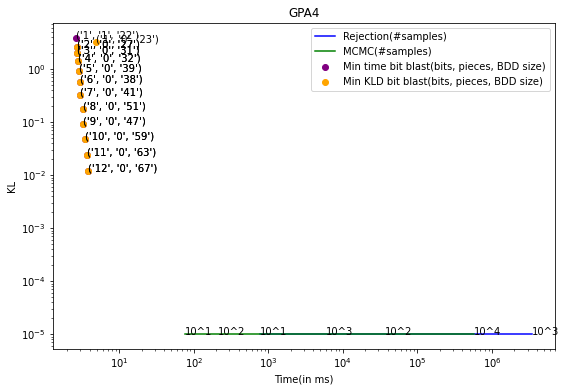

In [12]:
a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_rej_4.txt", "r")
rej = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("GPA4")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = ['10^1', '10^2', '10^3']
kld = [float(j.split(' ')[1]) for j in rej]
kld = margin(kld)
time = [float(j.split(' ')[0]) for j in rej]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]


ax1.plot(time, kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))


a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_mcmc_4.txt", "r")
mcmc = a.readlines()


t = ['10^1','10^2', '10^3', '10^4']
kld = [float(j.split(' ')[1]) for j in mcmc]
kld = margin(kld)
time = [float(j.split(' ')[0]) for j in mcmc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]
print(time, kld)
ax1.plot(time, kld, color= "green")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice if j.split(',')[0] == '4.0']
for j in range(len(dice)):
    temp = dice[j].split(',')
    temp2 = temp[-1].split(' ')
    if temp2[-1][0] == 'm':
        temp3 = float(temp2[0].split('(')[1])
    else:
        temp3 = float(temp2[0].split('(')[1]) * 1000
    
    dice[j] = dice[j] + ',' + str(temp3)
print(dice[0].split(','))

dice_min = []
for i in range(1,13):
    min_time = 100000
    min_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[-1]) < min_time:
                min_time = float(temp[-1])
                min_j = dice[j]
    dice_min.append(min_j)

print(dice_min)

dice_max = []
for i in range(1,13):
    max_time = 0.00
    max_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[5]) > max_time:
                max_time = float(temp[5])
                max_j = dice[j]

    dice_max.append(max_j)

print(dice_max)



    

prob = [1, 0]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]

ax1.scatter(time, kld, color= "purple")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

dice_min = dice_max
prob = [1, 0]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]

ax1.scatter(time, kld, color= "orange")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

ax1.legend(["Rejection(#samples)", "MCMC(#samples)", "Min time bit blast(bits, pieces, BDD size)", "Min KLD bit blast(bits, pieces, BDD size)"])
fig1.savefig("gpa4.png")

[109.5, 212.0, 2417.0, 177165.0] [1e-05, 1e-05, 1e-05, 1e-05]
['8.0', '1', '0', '3', '6', '0.0', 'TrialEstimate(2.587 ms)\n', '2.587']
['8.0,1,0,3,6,0.0,TrialEstimate(2.587 ms)\n,2.587', '8.0,2,0,3,6,0.0,TrialEstimate(2.662 ms)\n,2.662', '8.0,3,0,3,6,0.0,TrialEstimate(2.736 ms)\n,2.736', '8.0,4,0,3,6,0.0,TrialEstimate(2.783 ms)\n,2.783', '8.0,5,0,3,6,0.0,TrialEstimate(2.921 ms)\n,2.921', '8.0,6,0,3,6,0.0,TrialEstimate(2.946 ms)\n,2.946', '8.0,7,0,3,6,0.0,TrialEstimate(3.029 ms)\n,3.029', '8.0,8,0,3,6,0.0,TrialEstimate(3.222 ms)\n,3.222', '8.0,9,0,3,6,0.0,TrialEstimate(3.221 ms)\n,3.221', '8.0,10,0,3,6,0.0,TrialEstimate(3.444 ms)\n,3.444', '8.0,11,0,3,6,0.0,TrialEstimate(3.585 ms)\n,3.585', '8.0,12,0,3,6,0.0,TrialEstimate(3.697 ms)\n,3.697']
['8.0,1,0,3,6,0.0,TrialEstimate(2.587 ms)\n,2.587', '8.0,2,0,3,6,0.0,TrialEstimate(2.662 ms)\n,2.662', '8.0,3,0,3,6,0.0,TrialEstimate(2.736 ms)\n,2.736', '8.0,4,0,3,6,0.0,TrialEstimate(2.783 ms)\n,2.783', '8.0,5,0,3,6,0.0,TrialEstimate(2.921 ms)\n,2

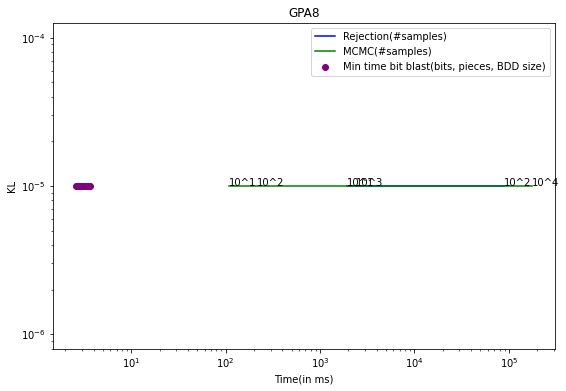

In [13]:
a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_rej_8.txt", "r")
rej = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("GPA8")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = ['10^1', '10^2']
kld = [float(j.split(' ')[1]) for j in rej]
kld = margin(kld)
time = [float(j.split(' ')[0]) for j in rej]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]


ax1.plot(time, kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))


a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_mcmc_8.txt", "r")
mcmc = a.readlines()


t = ['10^1','10^2', '10^3', '10^4']
kld = [float(j.split(' ')[1]) for j in mcmc]
kld = margin(kld)
time = [float(j.split(' ')[0]) for j in mcmc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]
print(time, kld)
ax1.plot(time, kld, color= "green")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice if j.split(',')[0] == '8.0']
for j in range(len(dice)):
    temp = dice[j].split(',')
    temp2 = temp[-1].split(' ')
    if temp2[-1][0] == 'm':
        temp3 = float(temp2[0].split('(')[1])
    else:
        temp3 = float(temp2[0].split('(')[1]) * 1000
    
    dice[j] = dice[j] + ',' + str(temp3)
print(dice[0].split(','))

dice_min = []
for i in range(1,13):
    min_time = 100000
    min_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[-1]) < min_time:
                min_time = float(temp[-1])
                min_j = dice[j]
    dice_min.append(min_j)

print(dice_min)

dice_max = []
for i in range(1,13):
    max_time = 1.00
    max_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[5]) < max_time:
                max_time = float(temp[5])
                max_j = dice[j]

    dice_max.append(max_j)

print(dice_max)



    

prob = [0, 1]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]
kld= margin(kld)
ax1.scatter(time, kld, color= "purple")

# for i in range(len(t)):
#     ax1.annotate(t[i], (time[i], kld[i]))

# dice_min = dice_max
# prob = [0, 1]
# t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
# kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
# time = [float(j.split(',')[7]) for j in dice_min]
# kld = margin(kld)
# ax1.scatter(time, kld, color= "orange")

# for i in range(len(t)):
#     ax1.annotate(t[i], (time[i], kld[i]))

ax1.legend(["Rejection(#samples)", "MCMC(#samples)", "Min time bit blast(bits, pieces, BDD size)", "Min KLD bit blast(bits, pieces, BDD size)"])

fig1.savefig("gpa8.png")

Radar Query 1 (Uniform + Gaussian)

0.00024414061698152523
-4.445113432893777e-08


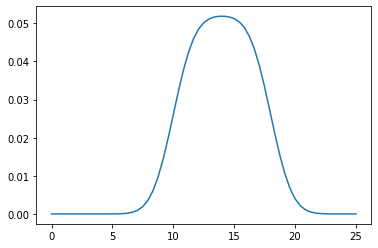

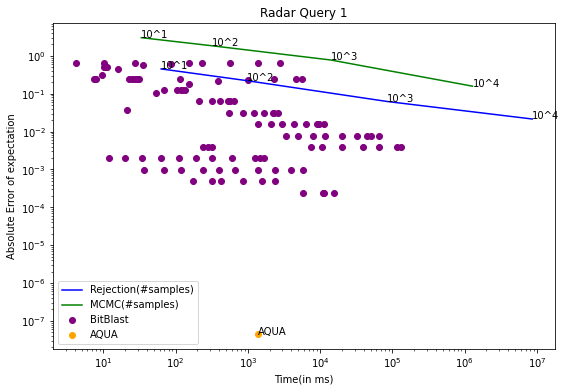

In [86]:
AQUA_mean, AQUA_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/storm_bench/radar_query2/analysis_x2.txt")
gt_mean, gt_variance = 14, 64/12 + 1.414**2
 
a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_rej.txt", "r")
rej = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Radar Query 1")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = ['10^1', '10^2', '10^3', '10^4']
kld = [float(j.split(' ')[1]) for j in rej]
time = [float(j.split(' ')[0]) for j in rej]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]


ax1.plot(time, kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))


a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_mcmc.txt", "r")
mcmc = a.readlines()


t = ['10^1','10^2', '10^3', '10^4']
kld = [float(j.split(' ')[1]) for j in mcmc]
# kld = margin(kld)
time = [float(j.split(' ')[0]) for j in mcmc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]
# print(time, kld)
ax1.plot(time, kld, color= "green")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []
for j in range(len(dice)):
    # print(temp[6])
    temp = dice[j].split(',')
    t.append((temp[0], temp[1], temp[3]))
    abs_err.append(abs(float(temp[6].split('(')[-1]) - 14))
    time.append(temp[4].split('(')[-1])

print(min(abs_err))

for k in range(len(time)):
    if time[k][-3:] == 'ms)':
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-2:] == 's)':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])


ax1.scatter(time, abs_err, color= "purple")
print(AQUA_mean - gt_mean)
AQUA_pt = [1368.760479, abs(gt_mean - AQUA_mean)]
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')

ax1.annotate('AQUA', AQUA_pt)
bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture.csv", "a")
bpfile.write("radar_query1, b, " + str(min(abs_err)) + ", " + str(AQUA_pt[1]))
bpfile.close()
ax1.legend(["Rejection(#samples)", "MCMC(#samples)", "BitBlast", "AQUA"])

fig1.savefig("rq1_results.png")


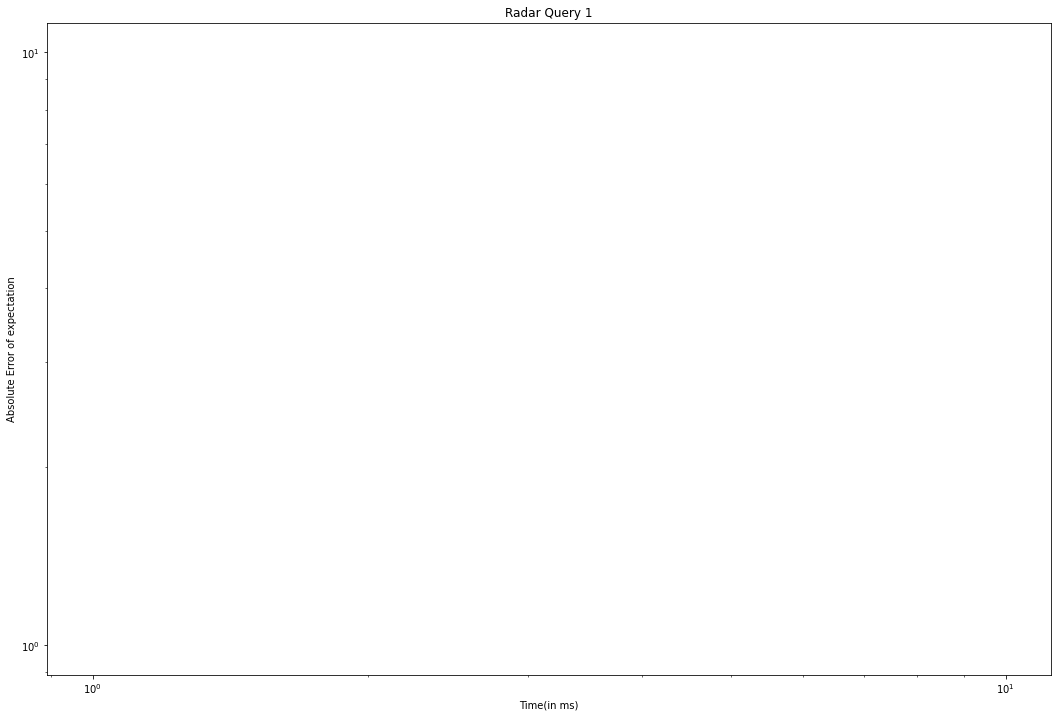

In [87]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Radar Query 1")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []
bits = []
for j in range(len(dice)):
    # print(temp[6])
    temp = dice[j].split(',')
    # if float(temp[0]) == 5:
    t.append((temp[0], temp[1], temp[3]))
    bits.append(float(temp[0]))
    abs_err.append(abs(float(temp[6].split('(')[-1]) - 14))
    time.append(temp[4].split('(')[-1])

# print(time)

for k in range(len(time)):
    if time[k][-3:] == 'ms)':
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-2:] == 's)':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])


In [89]:
def plot_indiv(no, fig1, ax1):
    # fig1, ax1 = plt.subplots()
    ax1.set_ylabel('Absolute Error of expectation')
    ax1.set_xscale("log")
    ax1.set_xlabel('Time(in ms)')
    ax1.set_yscale("log")
    ax1.set_title("Radar Query 1" + str(no))

    fig1.set_facecolor('white')
    fig1.set_size_inches(18, 12)

    t = []
    abs_err = []
    time = []
    bits = []
    for j in range(len(dice)):
        # print(temp[6])
        temp = dice[j].split(',')
        if float(temp[0]) == no:
            t.append((temp[0], temp[1], temp[3]))
            bits.append(float(temp[0]))
            abs_err.append(abs(float(temp[6].split('(')[-1]) - 14))
            time.append(temp[4].split('(')[-1])

    # print(t)
    # print(bits)
    # print(abs_err)
    # print(time)

    for k in range(len(time)):
        if time[k][-3:] == 'ms)':
            time[k] = float(time[k].split(' ')[0])
        elif time[k][-2:] == 's)':
            time[k] = float(time[k].split(' ')[0]) * 1000
        else:
            time[k] = float(time[k]) * 1000

    ax1.plot(time, abs_err, color="purple")

    for i in range(len(t)):
        ax1.annotate(t[i], (time[i], abs_err[i]))

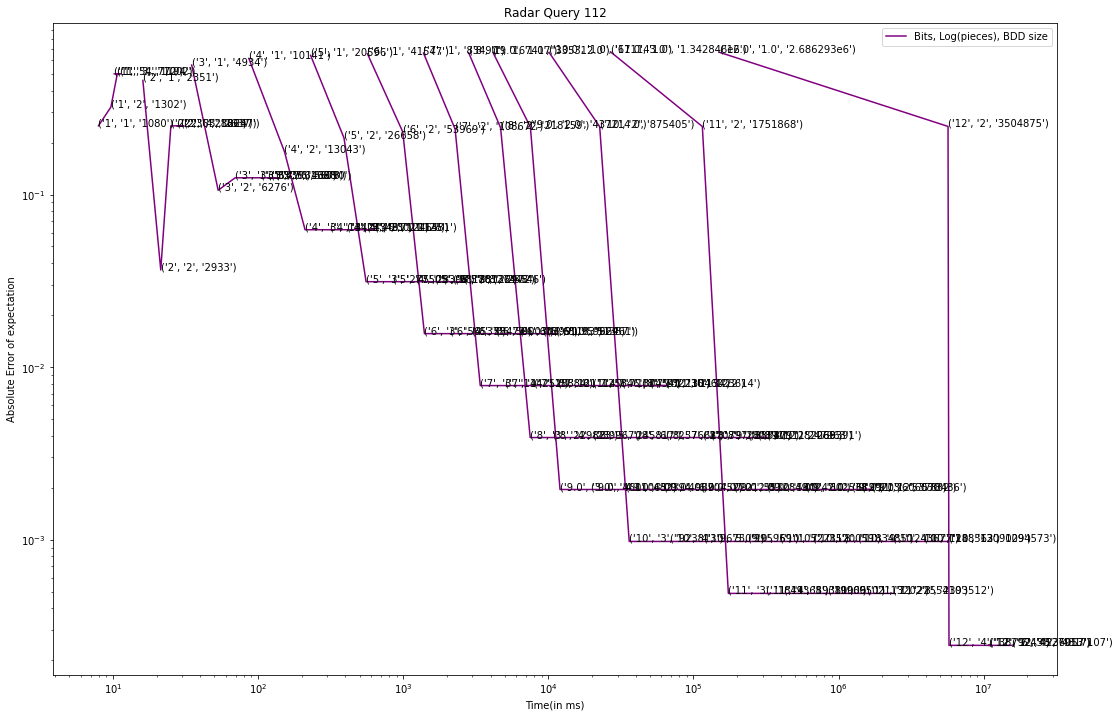

In [90]:
fig, ax = plt.subplots()

plot_indiv(1, fig, ax)
plot_indiv(2, fig, ax)
plot_indiv(3, fig, ax)
plot_indiv(4, fig, ax)
plot_indiv(5, fig, ax)
plot_indiv(6, fig, ax)
plot_indiv(7, fig, ax)
plot_indiv(8, fig, ax)
plot_indiv(9, fig, ax)
plot_indiv(10, fig, ax)
plot_indiv(11, fig, ax)
plot_indiv(12, fig, ax)

fig.savefig("rq1.png")
ax.legend(["Bits, Log(pieces), BDD size"])

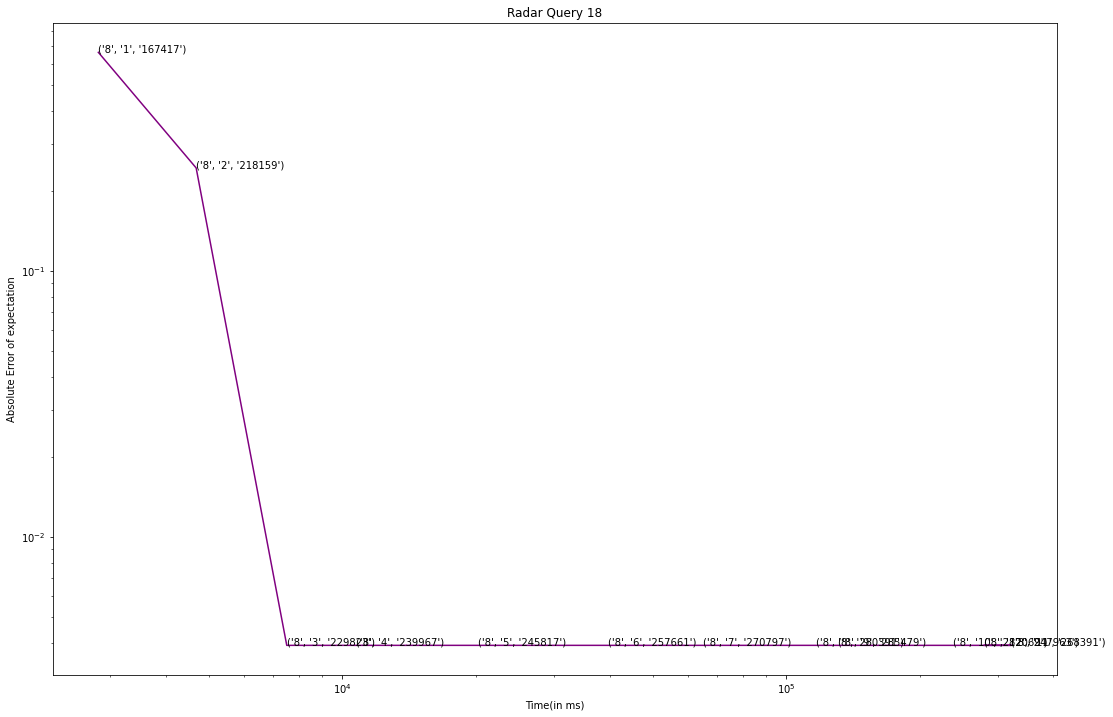

In [91]:
fig, ax = plt.subplots()
plot_indiv(8, fig, ax)


# fig.savefig("rq1.png")

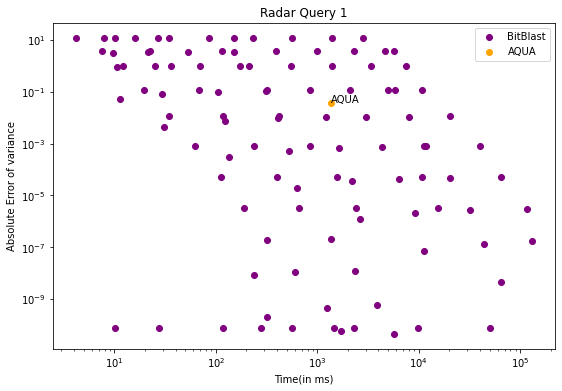

In [92]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Radar Query 1")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []
for j in range(len(dice)):
    temp = dice[j].split(',')
    t.append((temp[0], temp[1], temp[3]))
    abs_err.append(abs(float(temp[-1]) - 7.332729333333333))
    time.append(temp[4].split('(')[-1])

for k in range(len(time)):
    if time[k][-3:] == 'ms)':
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-2:] == 's)':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])

ax1.scatter(time, abs_err, color= "purple")

ax1.scatter([1368.760479], [0.03703752064430432], color = 'orange')
AQUA_pt = (1368.760479, 0.03703752064430432)
ax1.annotate('AQUA', (1368.760479, 0.03703752064430432))

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
bpfile.write("radar_query1, b, " + str(min(abs_err)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast", "AQUA"])

# fig1.legend("")
fig1.savefig("rq1_results.png")

In [20]:
def plot_indiv_variance(no, fig1, ax1):
    # fig1, ax1 = plt.subplots()
    ax1.set_ylabel('Absolute Error of Variance')
    ax1.set_xscale("log")
    ax1.set_xlabel('Time(in ms)')
    ax1.set_yscale("log")
    ax1.set_title("Radar Query 1" + str(no))

    fig1.set_facecolor('white')
    fig1.set_size_inches(18, 12)

    t = []
    abs_err = []
    time = []
    bits = []
    for j in range(len(dice)):
        # print(temp[6])
        temp = dice[j].split(',')
        if float(temp[0]) == no:
            t.append((temp[0], temp[1], temp[3]))
            bits.append(float(temp[0]))
            abs_err.append(abs(float(temp[-1]) - 7.332729333333333))
            time.append(temp[5].split('(')[-1])

    # print(t)
    # print(bits)
    # print(abs_err)
    # print(time)

    for k in range(len(time)):
        if time[k][-3:] == 'ms)':
            time[k] = float(time[k].split(' ')[0])
        elif time[k][-2:] == 's)':
            time[k] = float(time[k].split(' ')[0]) * 1000
        else:
            time[k] = float(time[k]) * 1000

    ax1.plot(time, abs_err, color="purple")

    for i in range(len(t)):
        ax1.annotate(t[i], (time[i], abs_err[i]))

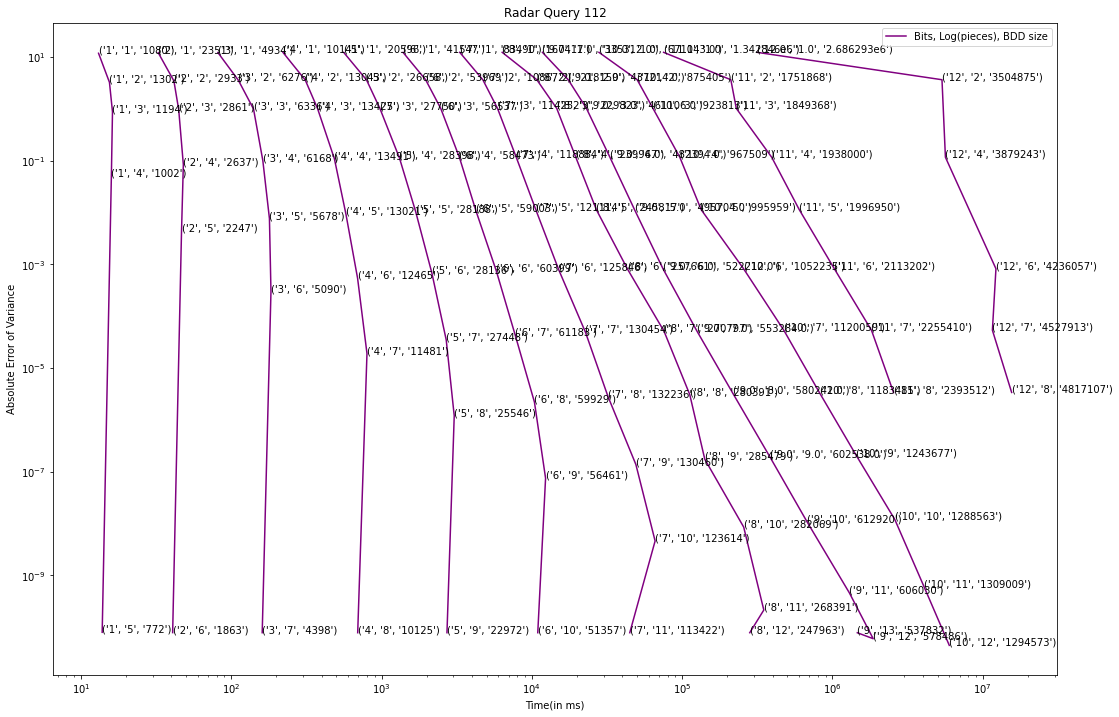

In [21]:
fig, ax = plt.subplots()

for i in range(1, 13):
    plot_indiv_variance(i, fig, ax)

fig.savefig("rq1.png")
ax.legend(["Bits, Log(pieces), BDD size"])

Altermu2    

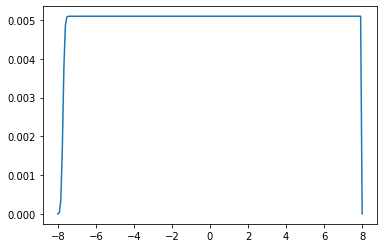

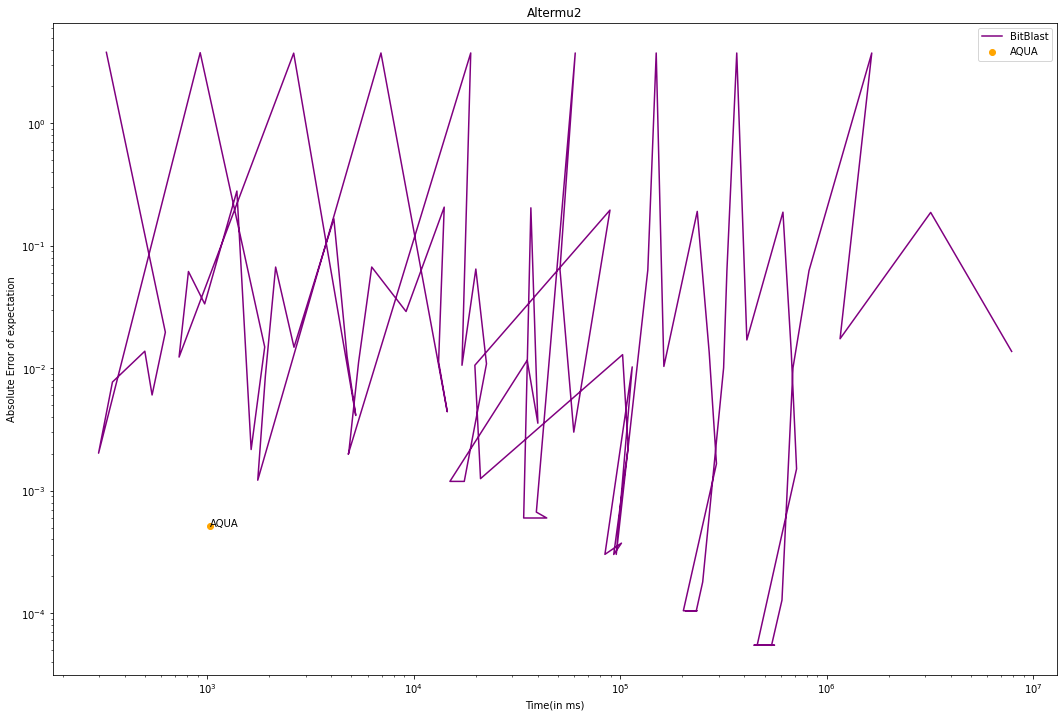

In [93]:
AQUA_time = 1.032172729 * 1000
gt_mean = (1.51251662585150465e-01 + 1.58960572270531064e-01)/2
gt_variance = 4.52785577875832512 ** 2

#TODO: check this
AQUA_mean, AQUA_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/altermu2/analysis_mu[1].txt")

AQUA_mean = 0.1556196223786136
AQUA_variance = 20.304334302261715



fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu2")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu2_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []


for j in range(31):
    temp = dice[j].split(',')
    # print(temp)
    t.append((temp[0], temp[1], temp[3]))

    temp2 = abs(float(temp[4].split("(")[-1]) - gt_mean)
    abs_err.append(temp2)

    temp3 = temp[7].split('(')[-1]
    time.append(temp3)

for j in range(31,len(dice)):
    temp = dice[j].split(',')
    # print(temp)
    t.append((temp[0], temp[1], temp[3]))

    temp2 = abs(float(temp[6].split("(")[-1]) - gt_mean)
    abs_err.append(temp2)

    temp3 = temp[4].split('(')[-1]
    time.append(temp3)

# for j in range(len(dice)):
#     temp = dice[j].split(',')
#     t.append((temp[0], temp[1], temp[3]))
#     abs_err.append(abs(float(temp[4].split('(')[0]) - gt_mean))
#     time.append(temp[7].split('(')[-1])

for k in range(len(dice)):
    if time[k][-3:] == 'ms)':
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-2:] == 's)':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])*1000

ax1.plot(time, abs_err, color= "purple")

AQUA_pt = (AQUA_time, abs(AQUA_mean - gt_mean))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture.csv", "a")
bpfile.write("altermu2, mu[1], " + str(min(abs_err)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast", "AQUA"])

# fig1.legend("")
fig1.savefig("altermu2_results_mean.png")



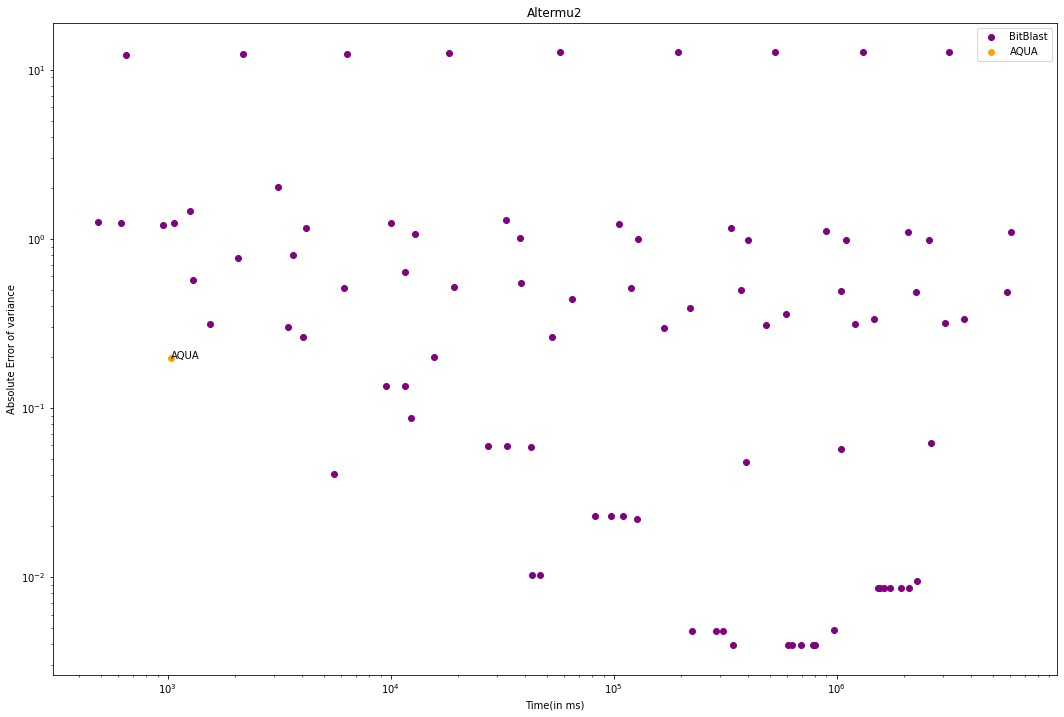

In [95]:
AQUA_time = 1.032172729 * 1000
gt_mean = (1.51251662585150465e-01 + 1.58960572270531064e-01)/2
gt_variance = 4.52785577875832512 ** 2

AQUA_mean = 0.1556196223786136
AQUA_variance = 20.304334302261715



fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu2")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu2_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []


for j in range(31):
    temp = dice[j].split(',')
    # print(temp)
    t.append((temp[0], temp[1], temp[3]))

    temp2 = abs(float(temp[-2].split("(")[-1]) - gt_variance)
    abs_err.append(temp2)

    temp3 = temp[-1].split('(')[-1]
    time.append(temp3)

for j in range(31,len(dice)):
    temp = dice[j].split(',')
    # print(temp)
    t.append((temp[0], temp[1], temp[3]))

    temp2 = abs(float(temp[-1].split("(")[-1]) - gt_variance)
    abs_err.append(temp2)

    temp3 = temp[5].split('(')[-1]
    time.append(temp3)


for k in range(len(dice)):
    if time[k][-4:] == 'ms)\n' :
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-3:] == 's)\n':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])*1000

ax1.scatter(time, abs_err, color= "purple")

AQUA_pt = (AQUA_time, abs(AQUA_variance - gt_variance))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
bpfile.write("altermu2, mu[1], " + str(min(abs_err)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast", "AQUA"])

# fig1.legend("")
fig1.savefig("altermu2_results_variance.png")

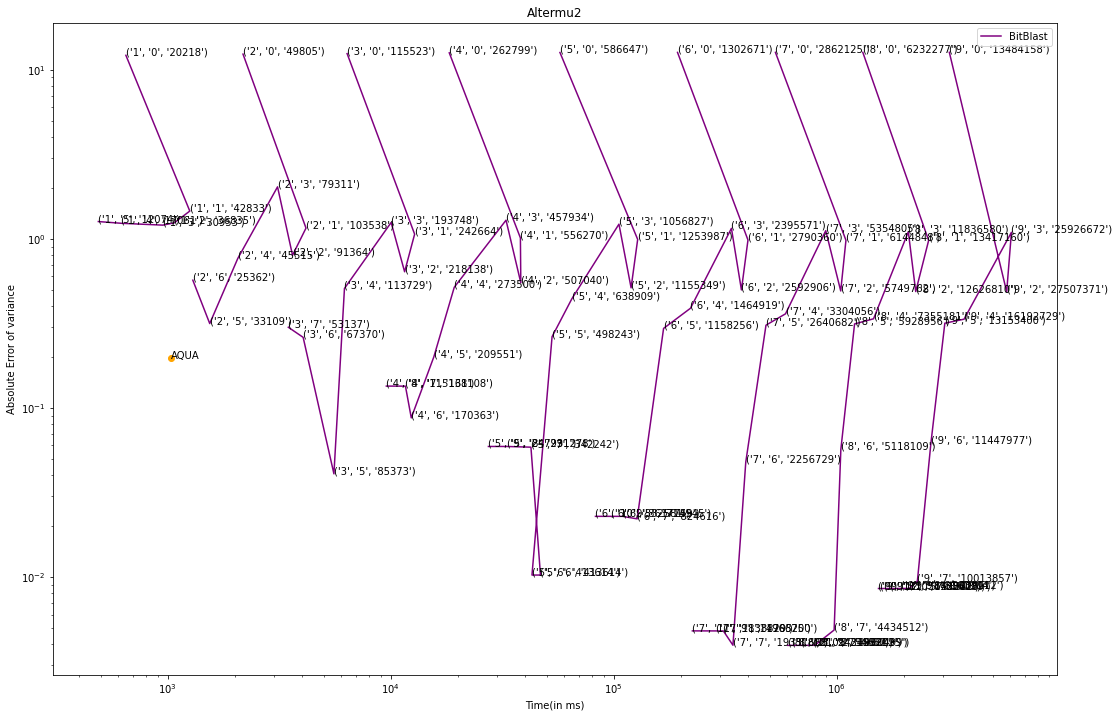

In [24]:


def plot_indiv_variance(file, gt_variance, title, no, fig1, ax1):

    a = open(file, "r")
    dice = a.readlines()

    dice = [(float(j.split(',')[1]), j) for j in dice if float(j.split(',')[0]) == no]
    dice.sort()

    dice = [j[1] for j in dice]

    t = []
    abs_err = []
    time = []


    for j in range(len(dice)):
        # print(dice[j][-2])
        if dice[j][-2] == ")":
            temp = dice[j].split(',')
            # print(temp)
            t.append((temp[0], temp[1], temp[3]))

            temp2 = abs(float(temp[-2].split("(")[-1]) - gt_variance)
            abs_err.append(temp2)

            temp3 = temp[-1].split('(')[-1]
            time.append(temp3)
        else:
            temp = dice[j].split(',')
            # print(temp)
            t.append((temp[0], temp[1], temp[3]))

            temp2 = abs(float(temp[-1].split("(")[-1]) - gt_variance)
            abs_err.append(temp2)

            temp3 = temp[5].split('(')[-1]
            time.append(temp3)


    for k in range(len(dice)):
        if time[k][-4:] == 'ms)\n' :
            time[k] = float(time[k].split(' ')[0])
        elif time[k][-3:] == 's)\n':
            time[k] = float(time[k].split(' ')[0]) * 1000
        else:
            time[k] = float(time[k])*1000

    ax1.plot(time, abs_err, color= "purple")
    for i in range(len(t)):
        ax1.annotate(t[i], (time[i], abs_err[i]))




fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu2")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)
for no in range(1, 13):
    plot_indiv_variance("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu2_res.txt", gt_variance, "Altermu2", no, fig1, ax1)
AQUA_pt = (AQUA_time, abs(AQUA_variance - gt_variance))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

ax1.legend(["BitBlast"])

# fig1.legend("")
fig1.savefig("altermu2_results_variance.png")
    

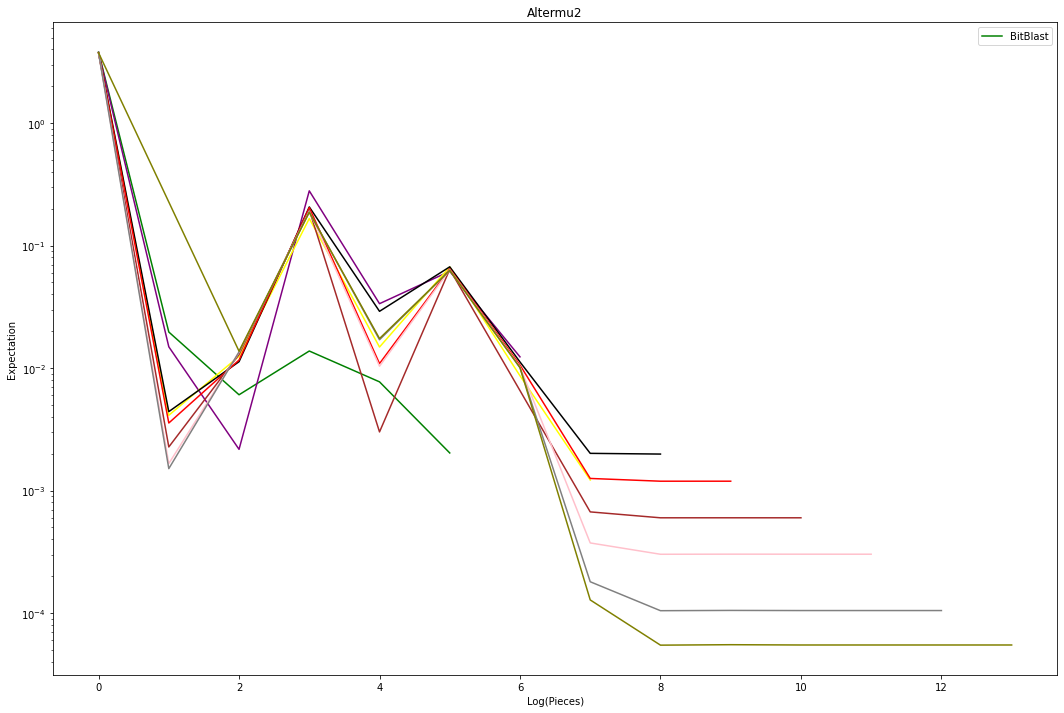

In [25]:
def plot_indiv_mean(file, gt_variance, title, no, fig1, ax1):

    a = open(file, "r")
    dice = a.readlines()

    dice = [(float(j.split(',')[1]), j) for j in dice if float(j.split(',')[0]) == no]
    dice.sort()

    dice = [j[1] for j in dice]

    t = []
    abs_err = []
    time = []


    for j in range(len(dice)):
        # print(dice[j][-2])
        if dice[j][-2] == ")":
            temp = dice[j].split(',')
            # print(temp)
            t.append((temp[0], temp[1], temp[3]))

            temp2 = abs(float(temp[4].split("(")[-1]) - gt_mean)
            abs_err.append(temp2)

            temp3 = temp[7].split('(')[-1]
            temp3 = int(temp[1])
            time.append(temp3)
        else:
            temp = dice[j].split(',')
            # print(temp)
            t.append((temp[0], temp[1], temp[3]))

            temp2 = abs(float(temp[6].split("(")[-1]) - gt_mean)
            abs_err.append(temp2)

            temp3 = temp[4].split('(')[-1]
            temp3 = int(temp[1])
            time.append(temp3)


    # for k in range(len(dice)):
    #     if time[k][-3:] == 'ms)' :
    #         time[k] = float(time[k].split(' ')[0])
    #     elif time[k][-2:] == 's)':
    #         time[k] = float(time[k].split(' ')[0]) * 1000
    #     else:
    #         time[k] = float(time[k])*1000

    ax1.plot(time, abs_err, color= colors[no])
    # for i in range(len(t)):
        # ax1.annotate(t[i], (time[i], abs_err[i]))




fig1, ax1 = plt.subplots()
ax1.set_ylabel('Expectation')
# ax1.set_xscale("log")
ax1.set_xlabel('Log(Pieces)')
ax1.set_yscale("log")
ax1.set_title("Altermu2")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

# Comment the following line to calculate abolute error of expectation
# gt_mean = 0.0
for no in range(1, 13):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu2_res.txt", gt_mean, "Altermu2", no, fig1, ax1)
AQUA_pt = (AQUA_time, abs(AQUA_mean - gt_mean))
# ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
# ax1.annotate('AQUA', AQUA_pt)

ax1.legend(["BitBlast"])

# fig1.legend("")
fig1.savefig("altermu2_mean.png")

Altermu

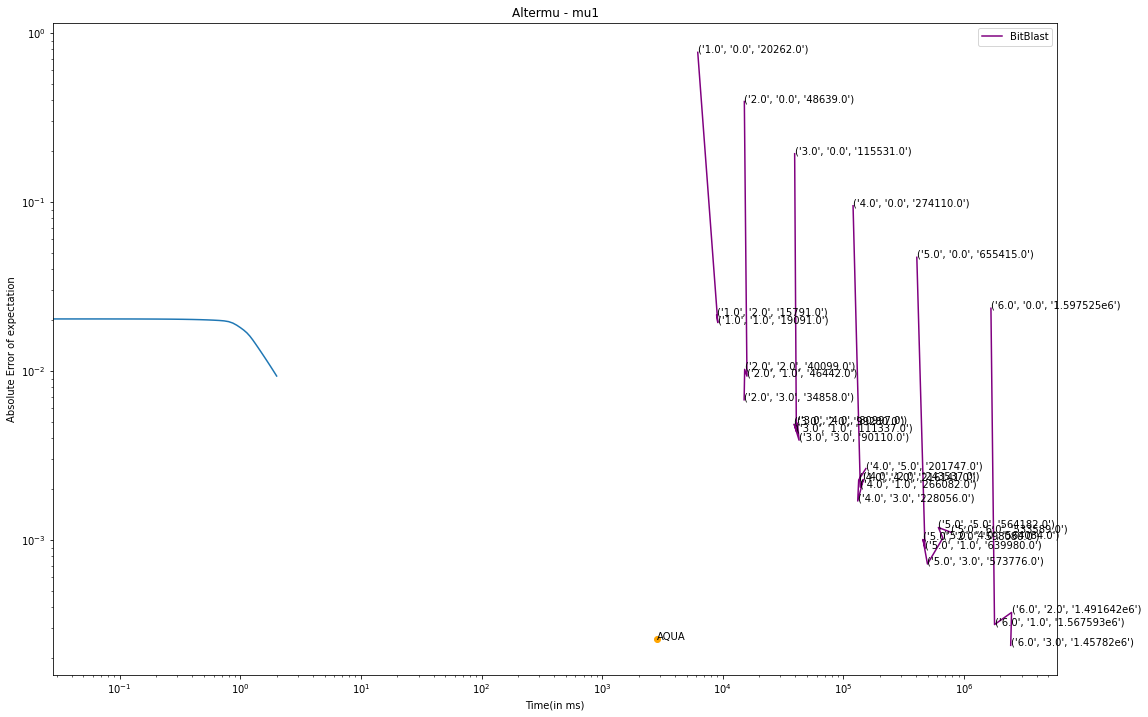

In [96]:
min_res = []

def plot_indiv_mean(file, gt_mean, title, no, fig1, ax1, offset):

    a = open(file, "r")
    dice = a.readlines()

    dice = [(float(j.split(',')[1]), j) for j in dice if float(j.split(',')[0]) == no]
    dice.sort()

    dice = [j[1] for j in dice]

    t = []
    abs_err = []
    time = []


    for j in range(len(dice)):
        temp = dice[j].split(',')
        t.append((temp[0], temp[1], temp[3]))

        temp2 = abs(float(temp[5 + (1 - math.ceil(offset))*2]) + (offset)*1/2**(no+1) - gt_mean)
        abs_err.append(temp2)

        temp3 = float(temp[4 + (1 - math.ceil(offset))*2]) * 1000
        time.append(temp3)
        min_res.append(min(abs_err))
        

    ax1.plot(time, abs_err, color= "purple")
    for i in range(len(t)):
        ax1.annotate(t[i], (time[i], abs_err[i]))

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu - mu1")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

gt_mean = 2.57737e-04
for no in range(1, 7):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu_mu1_res.txt", gt_mean, "Altermu-mu1", no, fig1, ax1, 1/4)


AQUA_mean, AQUA_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/altermu/analysis_mu[1].txt")

AQUA_time = ((3.065353433 + 2.585773617)/2) * 1000
AQUA_pt = (AQUA_time, abs(AQUA_mean - gt_mean))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

ax1.legend(["BitBlast"])

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture.csv", "a")
bpfile.write("altermu, mu[1], " + str(min(min_res)) + ", " + str(AQUA_pt[1]))
bpfile.close()

fig1.savefig("altermu_mu1_results_mean.png")

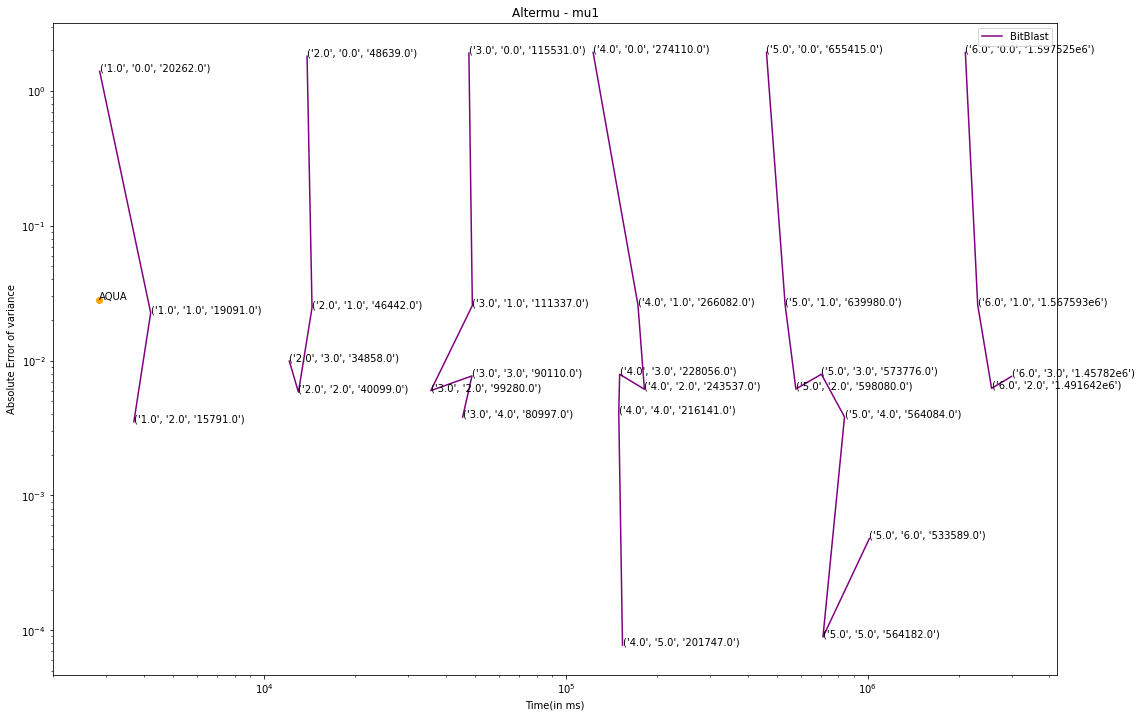

In [97]:
gt_variance = (1.02877e+00)**2

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu - mu1")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

gt_mean = 2.57737e-04
for no in range(1, 7):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu_mu1_res.txt", gt_variance, "Altermu-mu1", no, fig1, ax1, 0)


AQUA_time = ((3.065353433 + 2.585773617)/2) * 1000
AQUA_pt = (AQUA_time, abs(AQUA_variance - gt_variance))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
bpfile.write("altermu, mu[1], " + str(min(min_res)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast"])

fig1.savefig("altermu_mu1_results_variance.png")

[1.2861873878947825, 0.06188392763516182, 0.03181299324520592, 1.3179330110212049, 0.04843021365105071, 0.008281464832640473, 0.008281464832640473, 1.3261633478290604, 0.038387804923294744, 0.005716421737612998, 0.005716421737612998, 0.005716421737612998, 1.327834201435253, 0.03907372910964069, 0.004773937103285442, 0.004773937103285442, 0.004773937103285442, 0.004773937103285442, 1.3281483805843766, 0.038963446697778514, 0.004910614051801709, 0.004910614051801709, 0.004910614051801709, 0.004910614051801709, 0.004910614051801709, 1.328160900965107, 0.038016184673168474, 0.006217551047061343, 0.006217551047061343, 0.006217551047061343, 0.006217551047061343, 0.006217551047061343, 0.0008004499456703007]


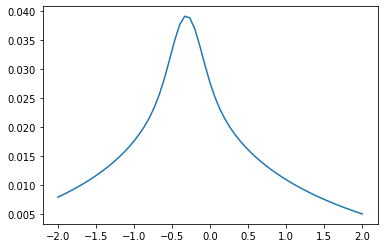

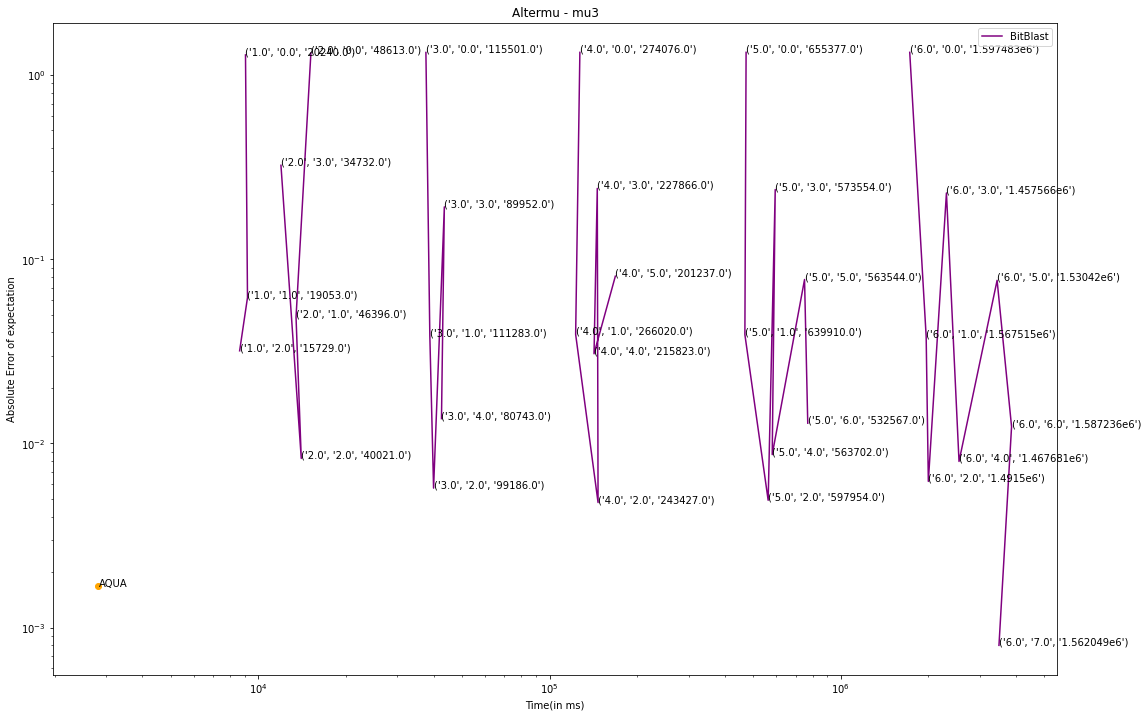

In [98]:
AQUA_mu3_mean, AQUA_mu3_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/altermu/analysis_mu[3].txt")

gt_mean = -1.86373e-01
gt_variance = (8.82885e-01)**2

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu - mu3")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)
min_res = []
for no in range(1, 7):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu_mu3_res.txt", gt_mean, "Altermu-mu3", no, fig1, ax1, 1)


AQUA_time = ((3.065353433 + 2.585773617)/2) * 1000
AQUA_pt = (AQUA_time, abs(AQUA_mu3_mean - gt_mean))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

ax1.legend(["BitBlast"])
print(min_res)
bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture.csv", "a")
bpfile.write("altermu, mu[3], " + str(min(min_res)) + ", " + str(AQUA_pt[1]) + "\n")
bpfile.close()

fig1.savefig("altermu_mu3_results_mean.png")

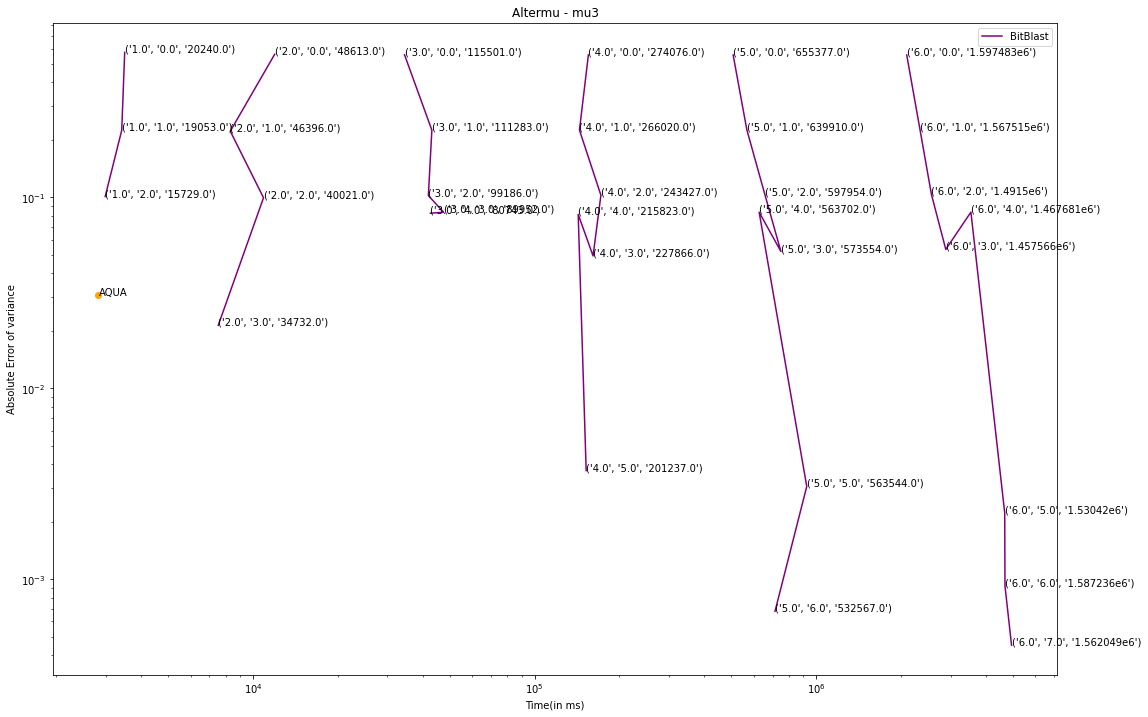

In [99]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu - mu3")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

for no in range(1, 7):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu_mu3_res.txt", gt_variance, "Altermu-mu3", no, fig1, ax1, 0)


AQUA_time = ((3.065353433 + 2.585773617)/2) * 1000
AQUA_pt = (AQUA_time, abs(AQUA_mu3_variance - gt_variance))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
bpfile.write("altermu, mu[1], " + str(min(min_res)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast"])

fig1.savefig("altermu_mu3_results_variance.png")

Anova Radon NoPred

0.52 1.3599999999999963
0.5600000009944001 1.2000000009879943


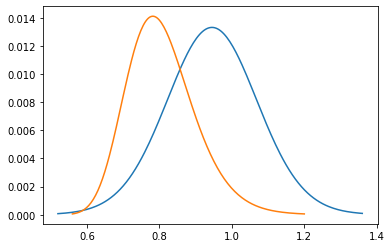

In [90]:
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/anova_radon_nopred/runtime.txt")

AQUA_a1_mean, AQUA_a1_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/anova_radon_nopred/analysis_a[1].txt")
AQUA_sigmay_mean, AQUA_sigmay_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/anova_radon_nopred/analysis_sigma_y.txt")

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/anova_radon_nopred/summary.txt", ['a[1]', 'sigma_y'])

[0.5547689371898256, 0.5547689347380055, 0.5547689301575193, 0.5547689747389853, 0.5547689794001646, 0.5547689790656741, 0.5547689790901603]
[0.3047206758047075, 0.3044317273048244, 0.304335234635137, 0.3034888599387334, 0.3037782360039577, 0.30382843297038786, 0.30382759805693416, 0.3038273027565642]
[0.2696694466511559, 0.1981328063556561, 0.19569760017164828, 0.10501476574230428, 0.15157236766647142, 0.1579541966933521, 0.15835810875428458, 0.15836922486174532, 0.1583657745011139]
[0.1582910367279745, 0.1116510502880198, 0.11263916247869121, 0.020880715374268055, 0.06402990508576234, 0.07155937949438729, 0.07160831504862497, 0.07157680391108723, 0.0715722642972133, 0.07157189611775971]


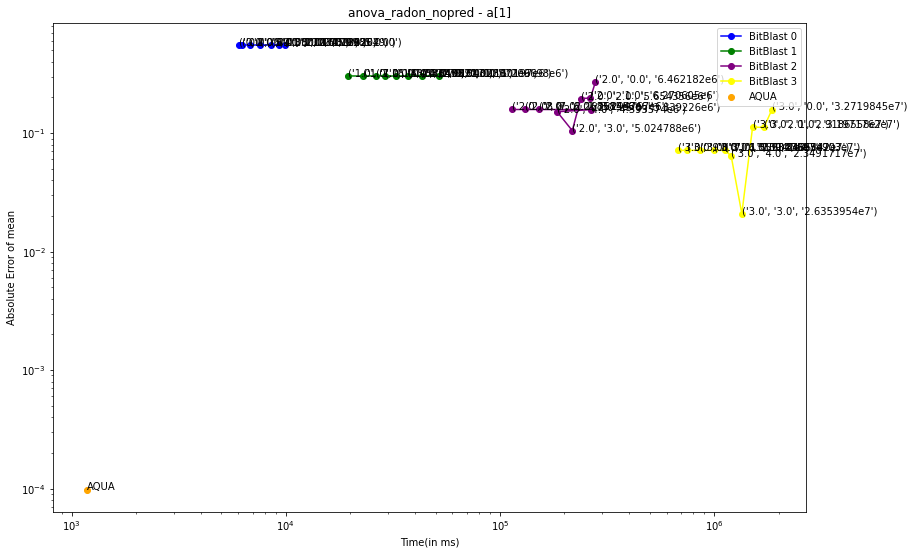

In [91]:
fig, ax = plotting_dice_data('mean', "anova_radon_nopred", "a[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/results_0.txt",
                            0, 4, 0.5, gt_mean['a[1]'], AQUA_time, AQUA_a1_mean, True, 's')

[0.016568142330796745, 0.016568249794738338, 0.016568241404437734, 0.0165682924513345, 0.016568297431030925, 0.016568296799713635, 0.016568296809348602]
[0.016495762630629143, 0.016230260942890526, 0.016107057546255056, 0.01565426008162673, 0.015797639198936616, 0.015815105941306213, 0.015815370881187188, 0.015815135275917637]
[0.0006798204406971951, 0.00594640043161976, 0.005600579594536316, 0.0010926586543413101, 0.0028139234135574846, 0.0023569362143164817, 0.002467483854209066, 0.0024642705965851764, 0.0024638807506394047]
[0.009499832827138892, 0.0035083904494519636, 0.0046020323389005646, 0.0009339872362306573, 0.0004052243458579144, 0.00010040439523656061, 0.00034678213906268185, 0.00034255291752155123, 0.00034369623535430646, 0.000343870745262969]


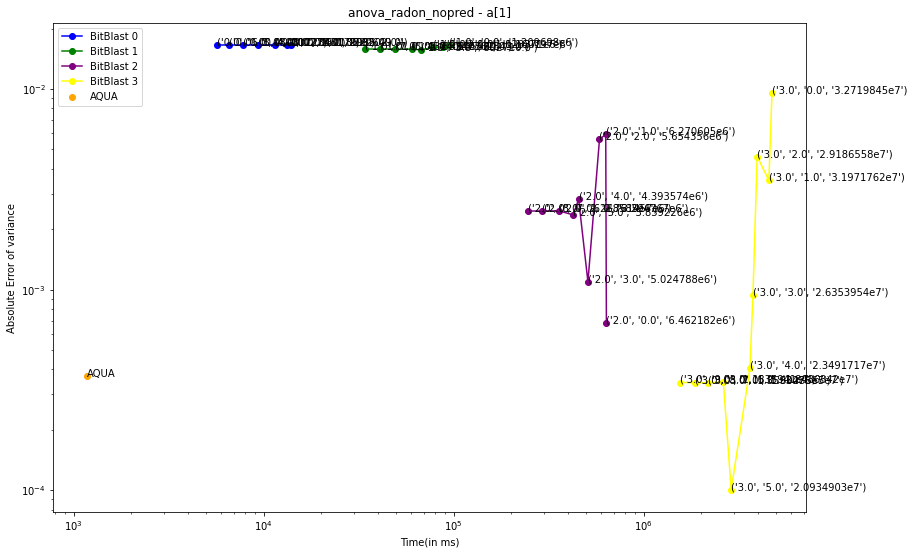

In [41]:
fig, ax = plotting_dice_data('variance', "anova_radon_nopred", "a[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/results_0.txt",
                            0, 4, 0, gt_variance['a[1]'], AQUA_time, AQUA_a1_variance, True, 's')

[0.4958379645570533, 0.4957291621864953, 0.26597986087450776, 0.013190630072219323, 0.020619256962074783, 0.025689829880024218, 0.025733701632848938]
[0.5248809943573329, 0.28719318387664194, 0.009747665868690358, 0.00020824583351541914, 0.00855708046750614, 0.008896153677783847, 0.008891337689451606]
[0.5420517464992538, 0.5317942451311538, 0.2737701270673256, 0.02840540266669067, 0.010546767962679393, 0.0013612001170874022, 0.0011387818884779355, 0.0010994665514079127, 0.0011057315155704739]
[0.5631697947671368, 0.5390831739580113, 0.2782327011778115, 0.00037898769635691387, 0.007777605756003503, 0.018573463935916967, 0.018518085820700136, 0.01851148828753235, 0.018511801883072554, 0.018511625214734706]


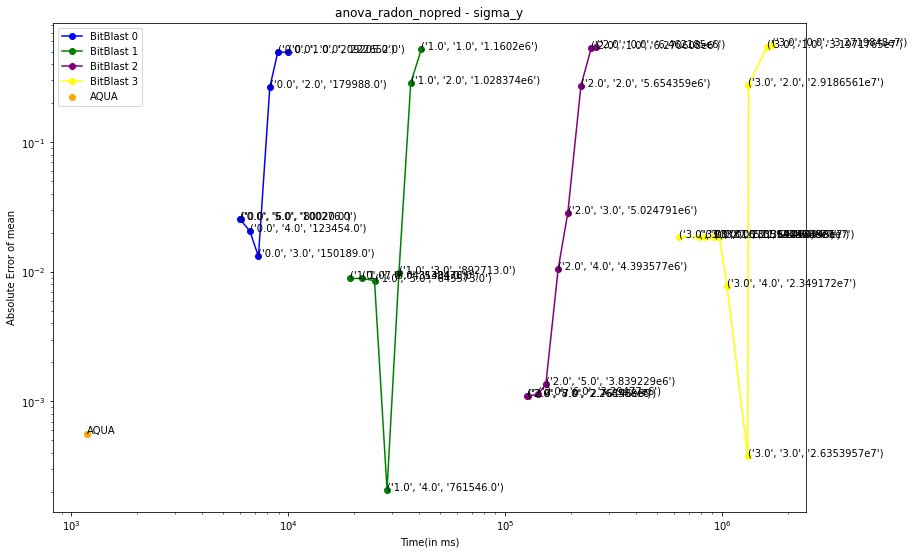

In [92]:
fig, ax = plotting_dice_data('mean', "anova_radon_nopred", "sigma_y", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/results_1.txt",
                            0, 4, 0.0625, gt_mean['sigma_y'], AQUA_time, AQUA_sigmay_mean, True, 's')

[0.00913444238997663, 0.009120846529805339, 0.005913674312805426, 0.003050727229453872, 0.0023469722631514235, 0.0022371558680826173, 0.0022102330282333]
[0.00899772884543453, 0.007026355708418615, 0.0025725667758471713, 0.0005269997125177568, 0.0002407640587975251, 0.00023982843280687116, 0.0002434232317335347]
[0.009113078002056334, 0.00880382352440637, 0.007489592308773959, 0.0005753670639717847, 0.0009890440208246733, 0.0004530458224443635, 0.00048237259234123163, 0.0004787374094177791, 0.0004787047871279808]
[0.009080274625294088, 0.008706092575637502, 0.00742569071694097, 0.000765856134269955, 0.0002185346076991907, 0.00025786407020231966, 0.00024273389354418154, 0.00024083220018709765, 0.00024101458215926817, 0.0002410748682970653]


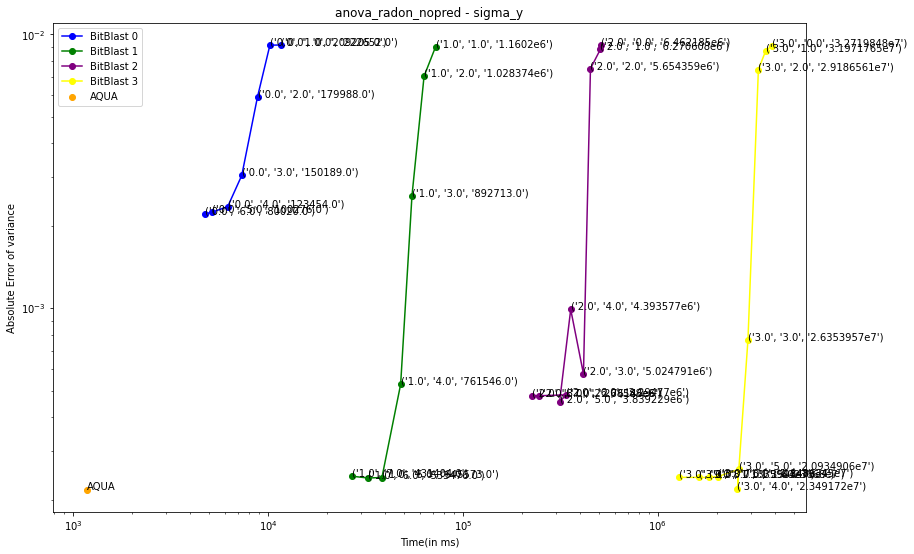

In [93]:
fig, ax = plotting_dice_data('variance', "anova_radon_nopred", "sigma_y", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/results_1.txt",
                            0, 4, 0, gt_variance['sigma_y'], AQUA_time, AQUA_sigmay_variance, True, 's')

Gamma Transform

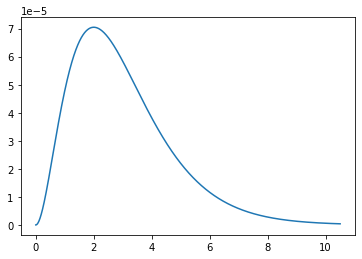

In [35]:
AQUA_mean, AQUA_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/storm_bench/gammaTransform/analysis_X.txt")

gt_mean, gt_variance = gamma.stats(3, scale = 1)

4.440892098500626e-16 0.01596625048655742


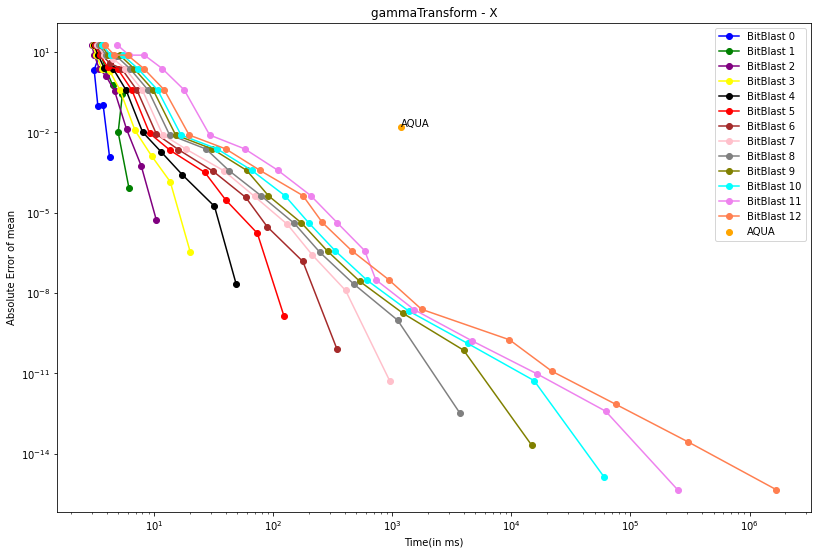

In [36]:
fig, ax = plotting_dice_data('mean', "gammaTransform", "X", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gammaTransform/gammaTransform_res.txt",
                            0, 13, 1/2, gt_mean, AQUA_time, AQUA_mean, False, 'ms')

4.96705032659861e-09 0.1359701251748806


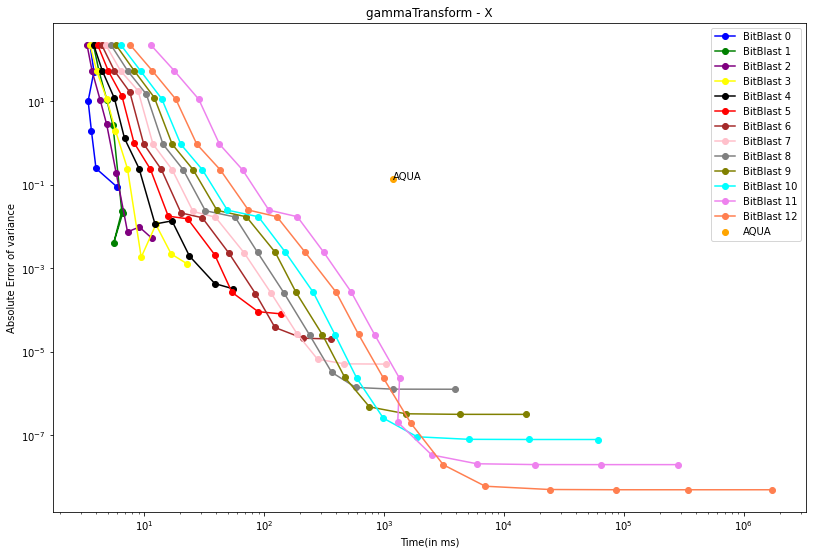

In [37]:
fig, ax = plotting_dice_data('variance', "gammaTransform", "X", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gammaTransform/gammaTransform_res.txt",
                            0, 13, 0, gt_variance, AQUA_time, AQUA_variance, False, 'ms')

Unemployment

-0.37999999999999945 2.9800000000000026
1.3633982078586728 0.21266298597476063


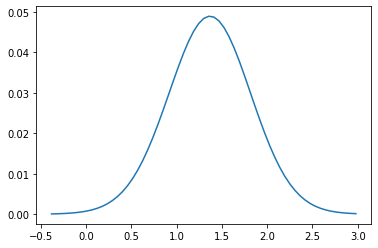

In [94]:
AQUA_beta1_mean, AQUA_beta1_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment/analysis_beta[1].txt")
print(AQUA_beta1_mean, AQUA_beta1_variance)

0.4720000000000002 1.0480000000000032
0.7612193089369887 0.005242902503694413


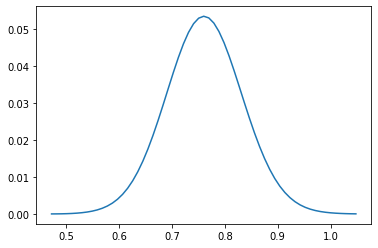

In [95]:
AQUA_beta2_mean, AQUA_beta2_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment/analysis_beta[2].txt")
print(AQUA_beta2_mean, AQUA_beta2_variance)



0.6000000000098802 1.4000000000097221
0.9279411558071368 0.012082611954958189


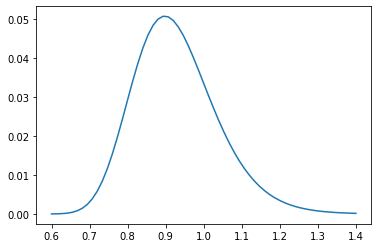

In [96]:
AQUA_sigma_mean, AQUA_sigma_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment/analysis_sigma.txt")
print(AQUA_sigma_mean, AQUA_sigma_variance)

In [97]:
gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/unemployment/results.txt", ['beta[1]', 'beta[2]', 'sigma'])
print(gt_mean, gt_variance)
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment/runtime.txt")
print(AQUA_time)

{'beta[1]': 1.363409828, 'beta[2]': 0.7612146186, 'sigma': 0.928360085} {'beta[1]': 0.2140053728255653, 'beta[2]': 0.005274256728589788, 'sigma': 0.012279079516138264}
4052.838


[1.1364316814664557, 0.5955280135264633, 0.49613456428305236, 0.4400460242403239]


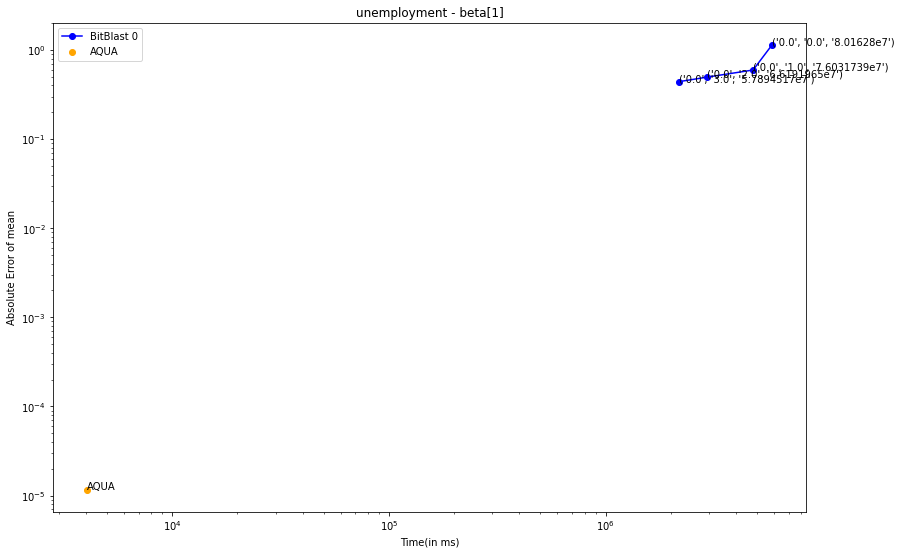

In [98]:
fig, ax = plotting_dice_data('mean', "unemployment", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_second_0.txt",
                            0, 1, 0.5, gt_mean['beta[1]'], AQUA_time, AQUA_beta1_mean, True, 's')

# plotting_dice_data(mean_or_var, title, var_name, result_file, lowerlimit, upperlimit, offset, gt, AQUA_time, AQUA_val, annot, s_or_ms):

[0.21134871386672915, 0.034323974171770216, 0.022006308002548852, 0.02125496631914711]


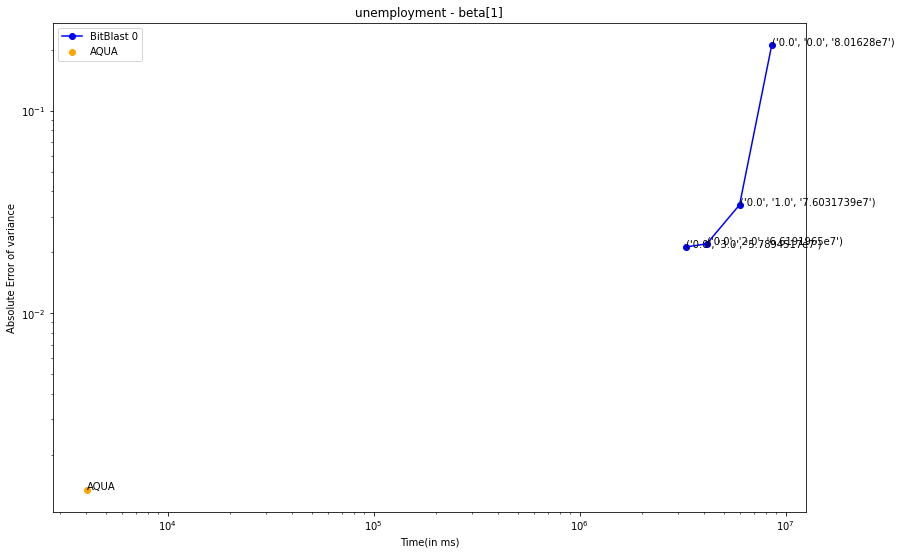

In [99]:
fig, ax = plotting_dice_data('variance', "unemployment", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_second_0.txt",
                            0, 1, 0, gt_variance['beta[1]'], AQUA_time, AQUA_beta1_variance, True, 's')

[0.051420659839697125, 0.11891813718707156, 0.13136215114481686, 0.13837535270845025]


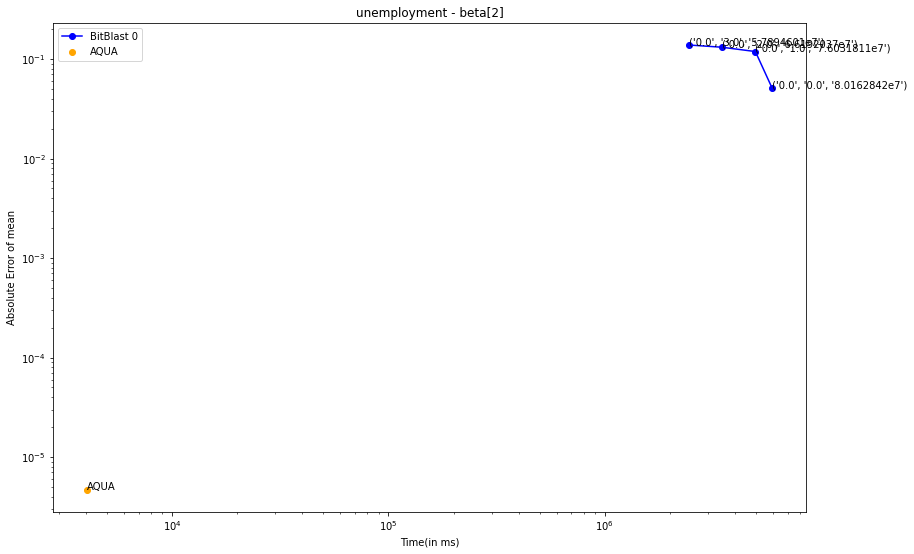

In [100]:
fig, ax = plotting_dice_data('mean', "unemployment", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_second_1.txt",
                            0, 1, 0.0625, gt_mean['beta[2]'], AQUA_time, AQUA_beta2_mean, True, 's')

[0.005255980815076239, 0.0013939901321141043, 0.0015789764573813296, 0.0015905482906918116]


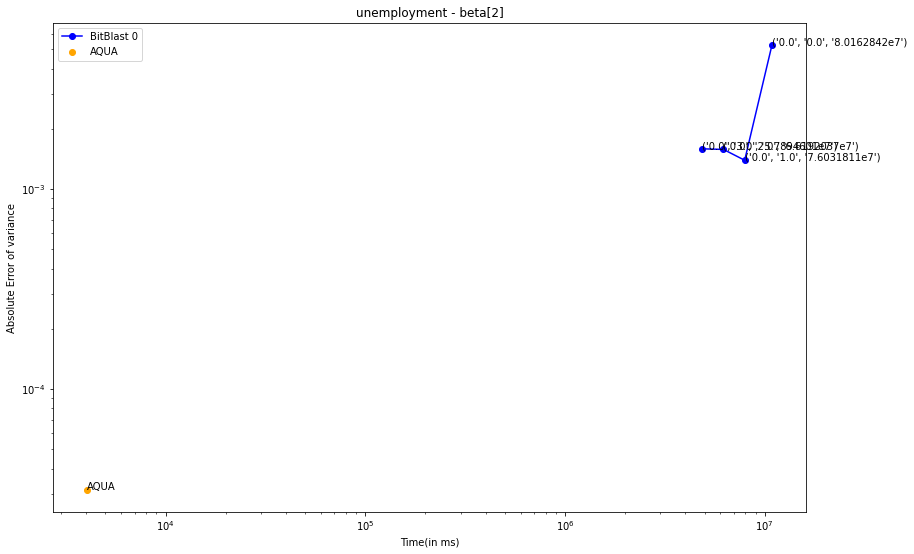

In [101]:
fig, ax = plotting_dice_data('variance', "unemployment", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_second_1.txt",
                            0, 1, 0, gt_variance['beta[2]'], AQUA_time, AQUA_beta2_variance, True, 's')

[0.7408017565310427, 0.7408579635195838, 0.6134342976453537, 0.32002442980246004]


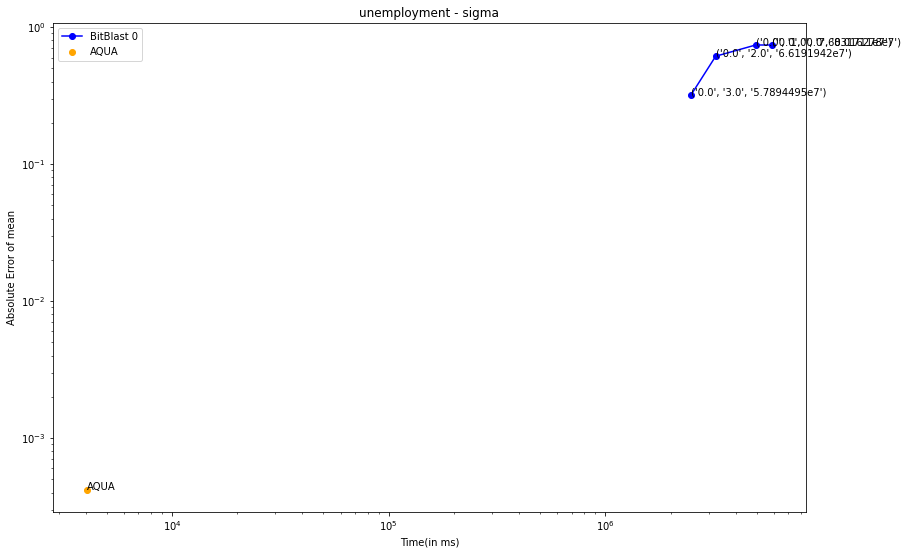

In [102]:
fig, ax = plotting_dice_data('mean', "unemployment", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_second_2.txt",
                            0, 1, 1/16, gt_mean['sigma'], AQUA_time, AQUA_sigma_mean, True, 's')

[0.01227179172180018, 0.012278814332451128, 0.011981183468968011, 0.007995749733502287]


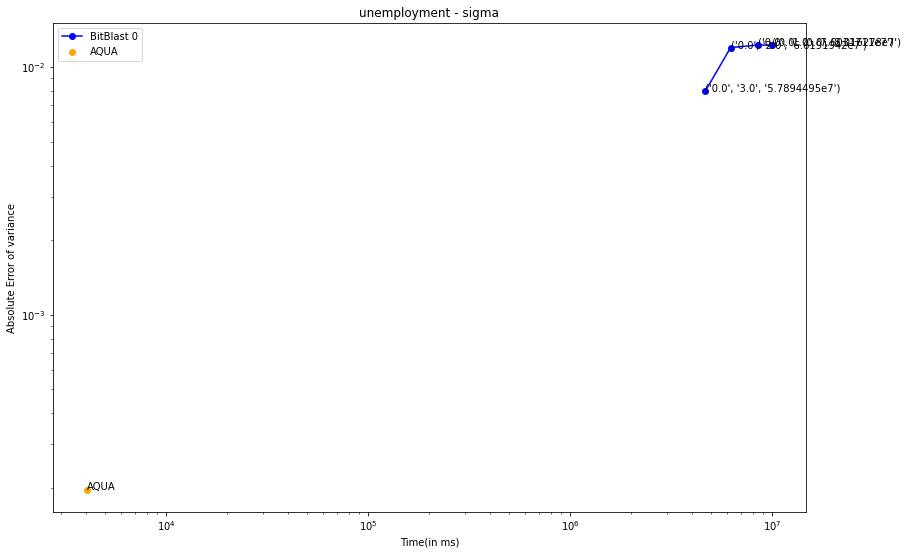

In [103]:
fig, ax = plotting_dice_data('variance', "unemployment", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_second_2.txt",
                            0, 1, 0, gt_variance['sigma'], AQUA_time, AQUA_sigma_variance, True, 's')

Lightspeed

In [44]:
# Ground Truth

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/lightspeed/results.txt", ['beta[1]', 'sigma'])
print(gt_mean, gt_variance)

{'beta[1]': 26.55810254, 'sigma': 10.16849644} {'beta[1]': 2.6215027885172244, 'sigma': 1.4455448154179347}


20.0 31.999999999999744
26.55489570478341 2.593720730344785


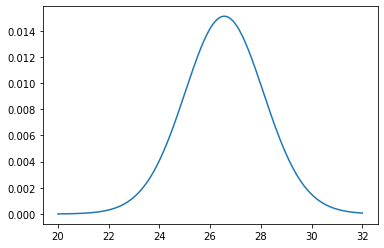

In [45]:
AQUA_beta1_mean, AQUA_beta1_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/lightspeed/analysis_beta[1].txt")
print(AQUA_beta1_mean, AQUA_beta1_variance)

6.500000000008701 15.50000000000691
10.164603846944548 1.425886526811695


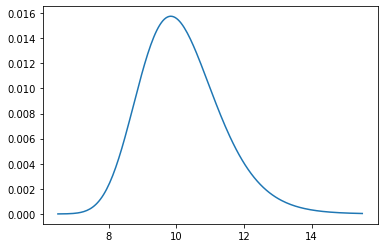

In [46]:
AQUA_sigma_mean, AQUA_sigma_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/lightspeed/analysis_sigma.txt")
print(AQUA_sigma_mean, AQUA_sigma_variance)

In [47]:
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/lightspeed/AQUA_time.txt")
print(AQUA_time)

1710.7849615


[0.34746884795617206, 0.6112275641132676, 0.6729824916557305, 1.0657769114176574, 0.8607806787030832, 0.6640323821009737, 0.7031953622582243, 0.7035993354644212, 0.7034434092804247]


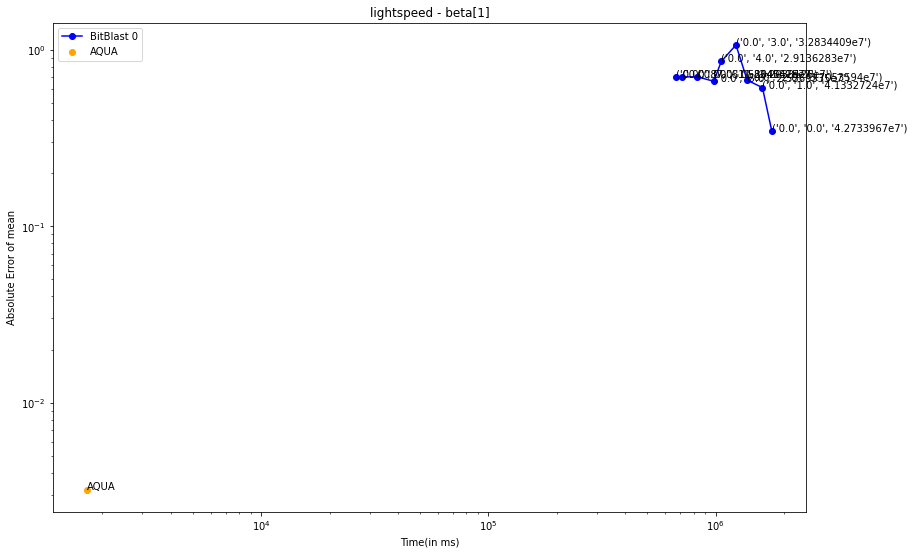

In [48]:
fig, ax = plotting_dice_data('mean', "lightspeed", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/lightspeed_new/results_second_0.txt",
                            0, 1, 0.5, gt_mean['beta[1]'], AQUA_time, AQUA_beta1_mean, True, 's')

[1.7371937975654768, 0.4488335635925047, 0.3590505288873196, 0.36106674328876, 0.5316558105986111, 0.33496320132400914, 0.3302191261261518, 0.33077126408208857, 0.3312553842018664]


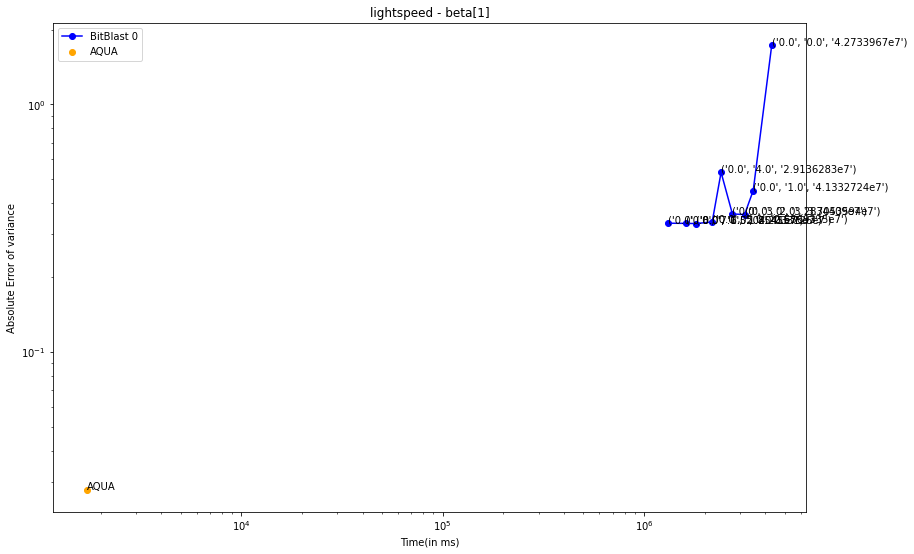

In [49]:
fig, ax = plotting_dice_data('variance', "lightspeed", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/lightspeed_new/results_second_0.txt",
                            0, 1, 0, gt_variance['beta[1]'], AQUA_time, AQUA_beta1_variance, True, 's')

[7.24578017514784, 6.888386042726057, 3.6110451920255686, 0.43561631155345815, 0.11455855473269416, 0.08781372621028893, 0.09977615896731074, 0.09932532003365147, 0.09936081428792143]


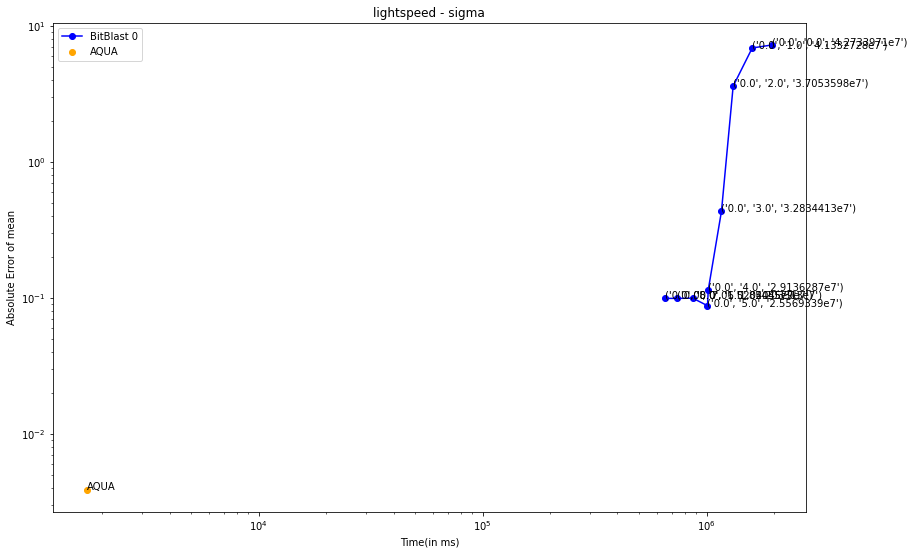

In [52]:
fig, ax = plotting_dice_data('mean', "lightspeed", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/lightspeed_new/results_second_1.txt",
                            0, 1, 0.015625, gt_mean['sigma'], AQUA_time, AQUA_sigma_mean, True, 's')

[1.433391124115821, 1.3808527851439725, 1.1859661604319118, 0.19719180311517648, 0.043624644695734904, 0.031947355314846826, 0.02230794066497155, 0.021714234388192866, 0.021698400723119127]


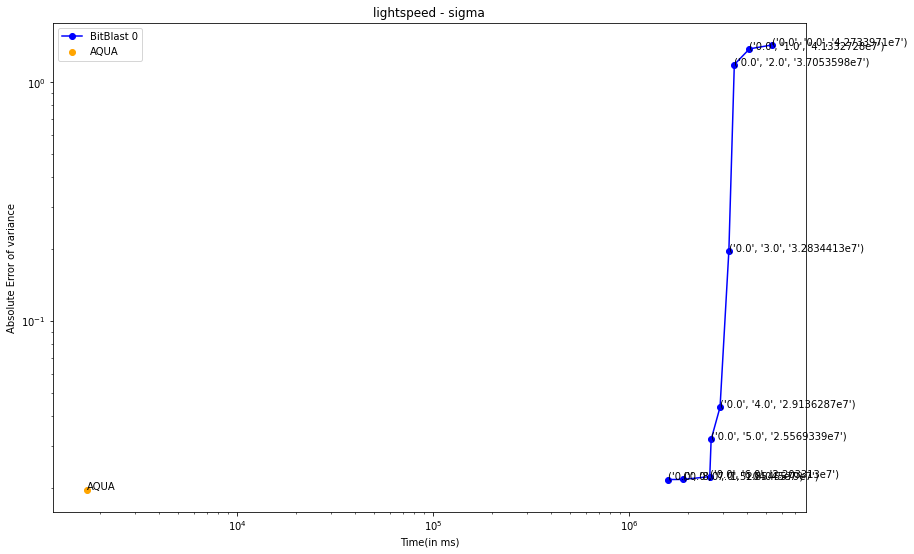

In [53]:
fig, ax = plotting_dice_data('variance', "lightspeed", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/lightspeed_new/results_second_1.txt",
                            0, 1, 0, gt_variance['sigma'], AQUA_time, AQUA_sigma_variance, True, 's')

Gaussian Mix Asymmetrical Prior

In [84]:
# Ground Truth

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/gauss_mix_asym_prior/results.txt", ['mu[1]', 'mu[2]', 'sigma[1]', 'sigma[2]'])
print(gt_mean, gt_variance)

{'mu[1]': 3.116300064, 'mu[2]': -2.647339929, 'sigma[1]': 1.173677251, 'sigma[2]': 0.9703079802} {'mu[1]': 0.079054253538237, 'mu[2]': 0.031102415650097637, 'sigma[1]': 0.09391663987006868, 'sigma[2]': 0.021148130846967345}


2.15 3.949999999999988
-3.3500000000000005 -2.090000000000006
0.40000000090000004 2.5600000003600054
0.5200000008700001 1.6000000006000037
{'mu[1]': 3.1182287323577937, 'mu[2]': -2.647822656330139, 'sigma[1]': 1.1663995969213024, 'sigma[2]': 0.96920807514984} {'mu[1]': 0.07560977935857771, 'mu[2]': 0.030588407505567794, 'sigma[1]': 0.08270820423868086, 'sigma[2]': 0.02041806741931773}


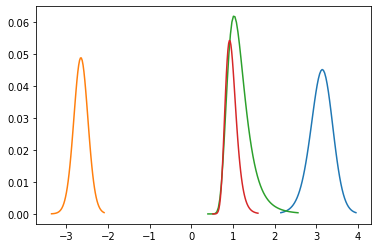

In [85]:
AQUA_mean, AQUA_variance = {}, {}
vars = ['mu[1]', 'mu[2]', 'sigma[1]', 'sigma[2]']
for i in vars:
    # print(i)
    AQUA_mean[i], AQUA_variance[i] = read_AQUA_file(f"/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/gauss_mix_asym_prior/analysis_{i}.txt")
print(AQUA_mean, AQUA_variance)

In [86]:
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/gauss_mix_asym_prior/AQUA_time.txt")
print(AQUA_time)

100954.941406


[2.6842794367731306, 0.07263399567247708, 0.3251416530708511, 0.34119439626065606]


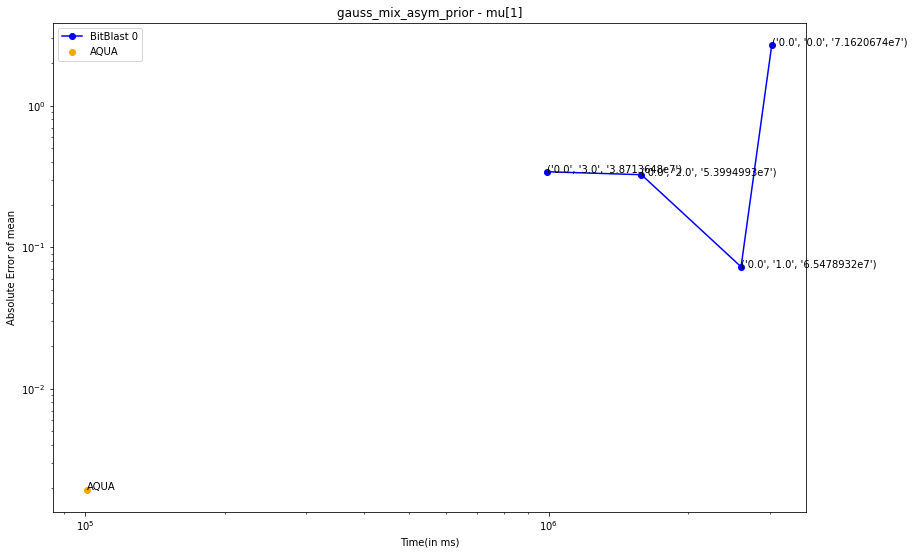

In [87]:
fig, ax = plotting_dice_data('mean', "gauss_mix_asym_prior", "mu[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior_new/results_second_0.txt",
                            0, 1, 0.5, gt_mean['mu[1]'], AQUA_time, AQUA_mean['mu[1]'], True, 's')

[3.638536028278647, 0.2569789150356776, 0.016967612633316594, 0.02851607110347929]


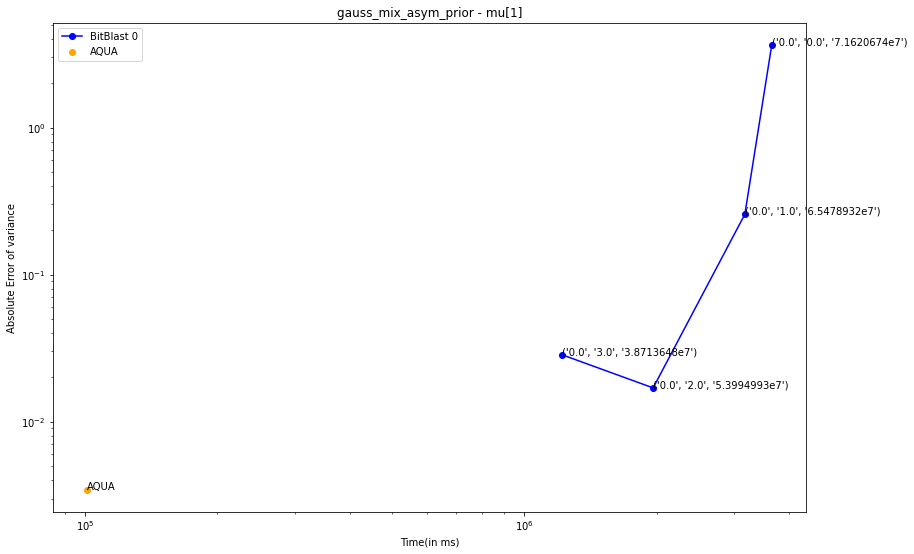

In [88]:
fig, ax = plotting_dice_data('variance', "gauss_mix_asym_prior", "mu[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior_new/results_second_0.txt",
                            0, 1, 0, gt_variance['mu[1]'], AQUA_time, AQUA_variance['mu[1]'], True, 's')

[1.2791617278296004, 0.18994553181180684, 0.20020028441095938, 0.15281897101416053]


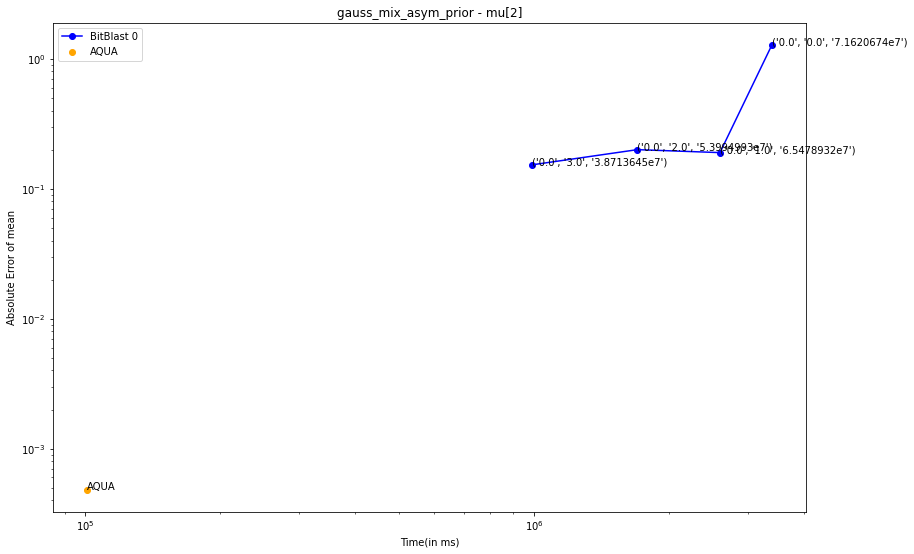

In [59]:
fig, ax = plotting_dice_data('mean', "gauss_mix_asym_prior", "mu[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior_new/results_second_1.txt",
                            0, 1, 0.5, gt_mean['mu[2]'], AQUA_time, AQUA_mean['mu[2]'], True, 's')

[3.1256912078071495, 0.009967088648653977, 0.019030263569705497, 0.025649704352855025]


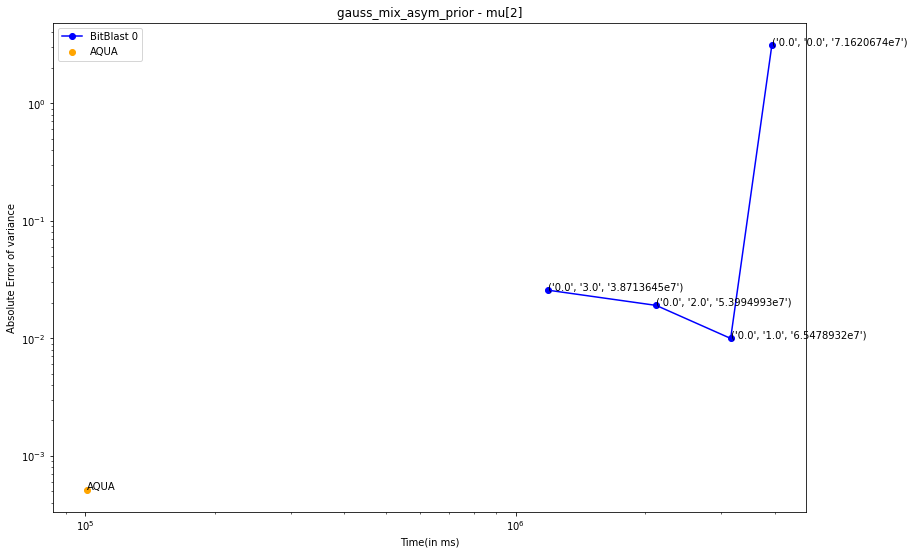

In [60]:
fig, ax = plotting_dice_data('variance', "gauss_mix_asym_prior", "mu[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior_new/results_second_1.txt",
                            0, 1, 0, gt_variance['mu[2]'], AQUA_time, AQUA_variance['mu[2]'], True, 's')

[0.6189071268559545, 0.5177620478091253, 0.2539547598560863, 0.22491612544064954]


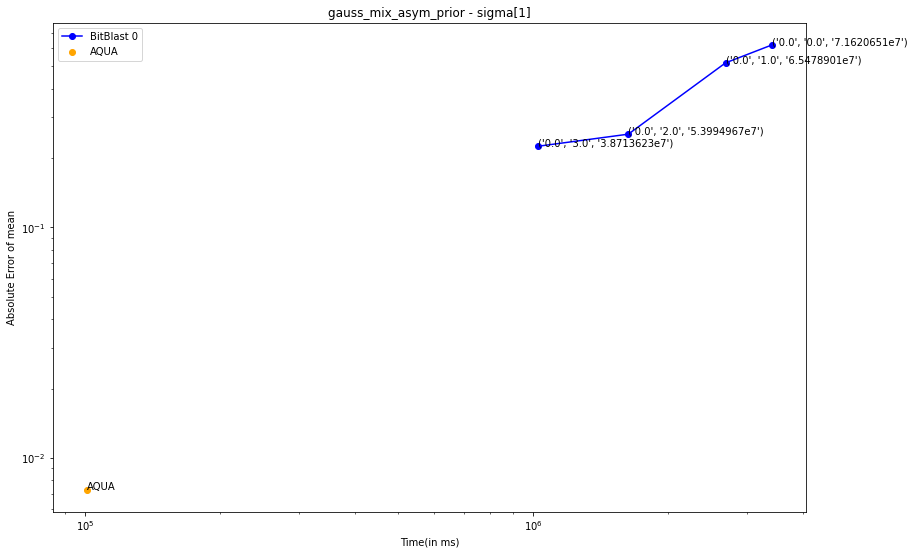

In [61]:
fig, ax = plotting_dice_data('mean', "gauss_mix_asym_prior", "sigma[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior_new/results_second_2.txt",
                            0, 1, 0.125, gt_mean['sigma[1]'], AQUA_time, AQUA_mean['sigma[1]'], True, 's')

[0.07949161598185127, 0.07340055639443986, 0.0017957913297459438, 0.0648193440595504]


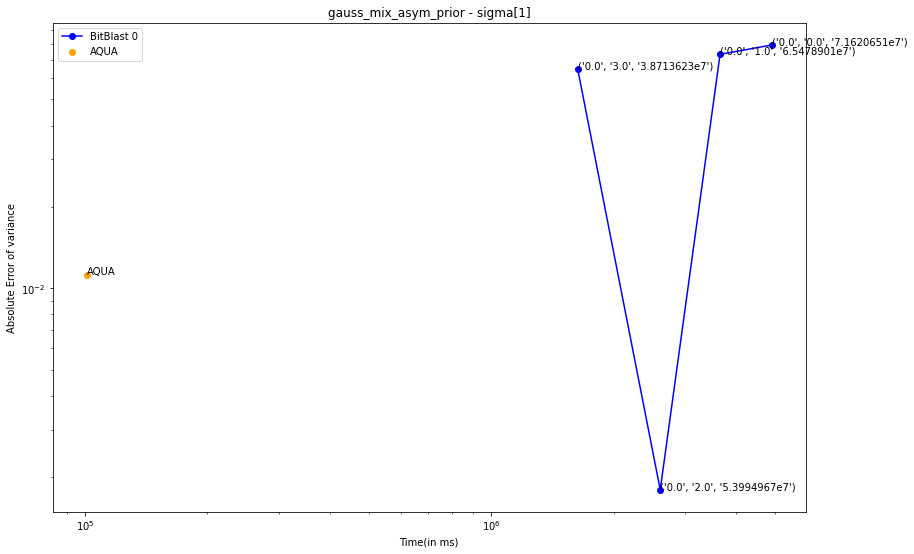

In [62]:
fig, ax = plotting_dice_data('variance', "gauss_mix_asym_prior", "sigma[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior_new/results_second_2.txt",
                            0, 1, 0, gt_variance['sigma[1]'], AQUA_time, AQUA_variance['sigma[1]'], True, 's')

[0.5106164895529582, 0.5722700618006575, 0.14771637134797366, 0.2036228353263564]


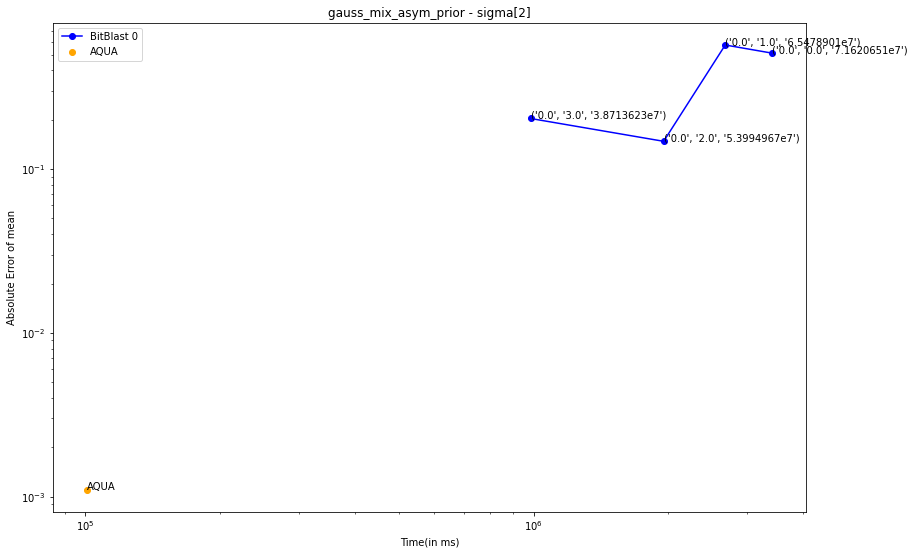

In [65]:
fig, ax = plotting_dice_data('mean', "gauss_mix_asym_prior", "sigma[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior_new/results_second_3.txt",
                            0, 1, 0.125, gt_mean['sigma[2]'], AQUA_time, AQUA_mean['sigma[2]'], True, 's')

[0.0014024334317843286, 0.015840733099093895, 0.007044936905887041, 0.0009343256803111578]


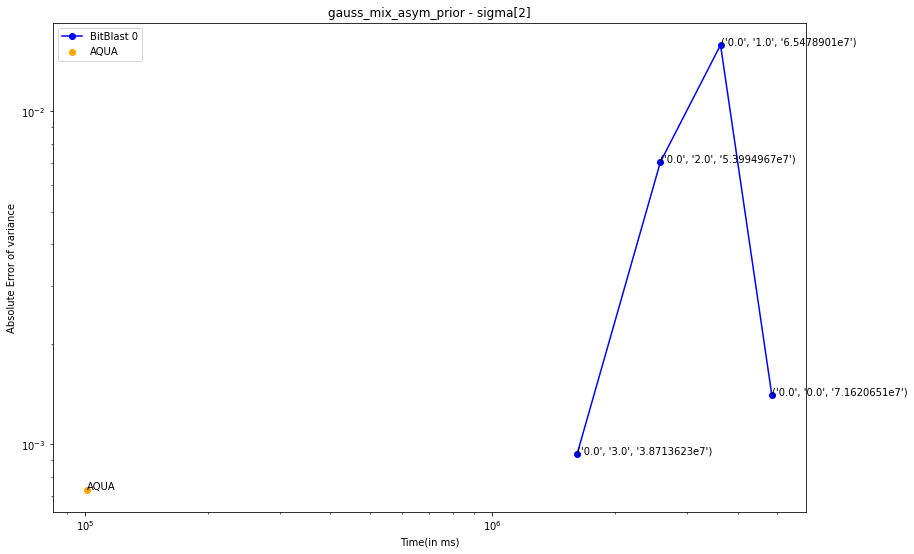

In [66]:
fig, ax = plotting_dice_data('variance', "gauss_mix_asym_prior", "sigma[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior_new/results_second_3.txt",
                            0, 1, 0, gt_variance['sigma[2]'], AQUA_time, AQUA_variance['sigma[2]'], True, 's')

Normal_Mixture

In [67]:
# Ground Truth

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/normal_mixture/results.txt", ['mu[1]', 'mu[2]', 'theta'])
print(gt_mean, gt_variance)

{'mu[1]': -5.028920059, 'mu[2]': 5.234615871, 'theta': 0.3928551869} {'mu[1]': 65.59366153529413, 'mu[2]': 58.74543290255279, 'theta': 0.03918052796111996}


{'mu[1]': -9.702495057285518, 'mu[2]': 9.657766163084034, 'theta': 0.2857243052496571} {'mu[1]': 0.08310954682160343, 'mu[2]': 0.03298641322834328, 'theta': 0.004718640093064927}


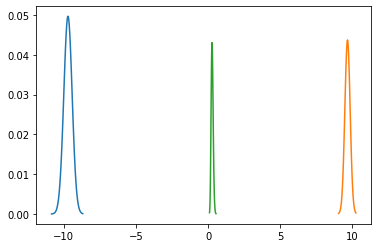

In [68]:
AQUA_mean, AQUA_variance = {}, {}
vars = ['mu[1]', 'mu[2]', 'theta']
for i in vars:
    # print(i)
    AQUA_mean[i], AQUA_variance[i] = read_AQUA_file(f"/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/normal_mixture/analysis_{i}.txt")
print(AQUA_mean, AQUA_variance)

0.04694614694146493 0.1071308816503429


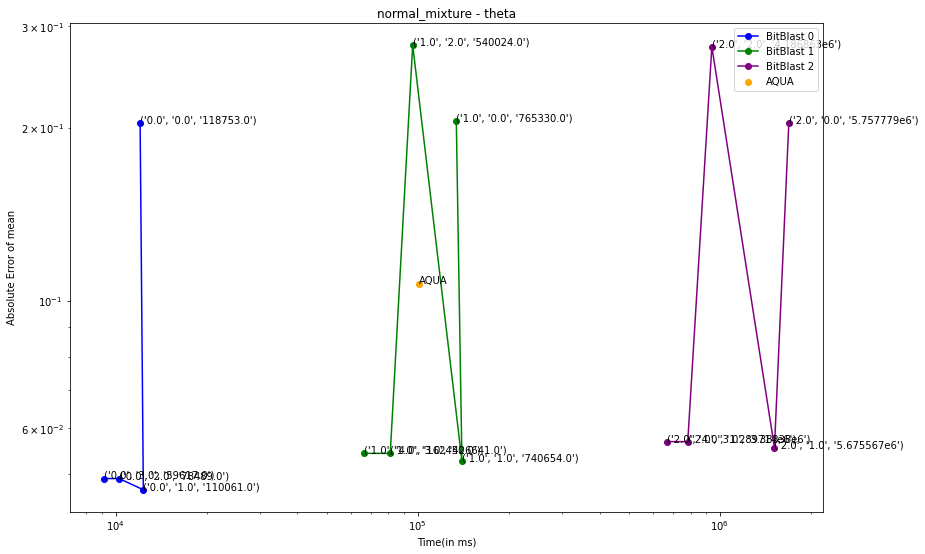

In [69]:
fig, ax = plotting_dice_data('mean', "normal_mixture", "theta", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_0.txt",
                            0, 3, 1/32, gt_mean['theta'], AQUA_time, AQUA_mean['theta'], True, 's')


0.01474955816908094 0.034461887868055034


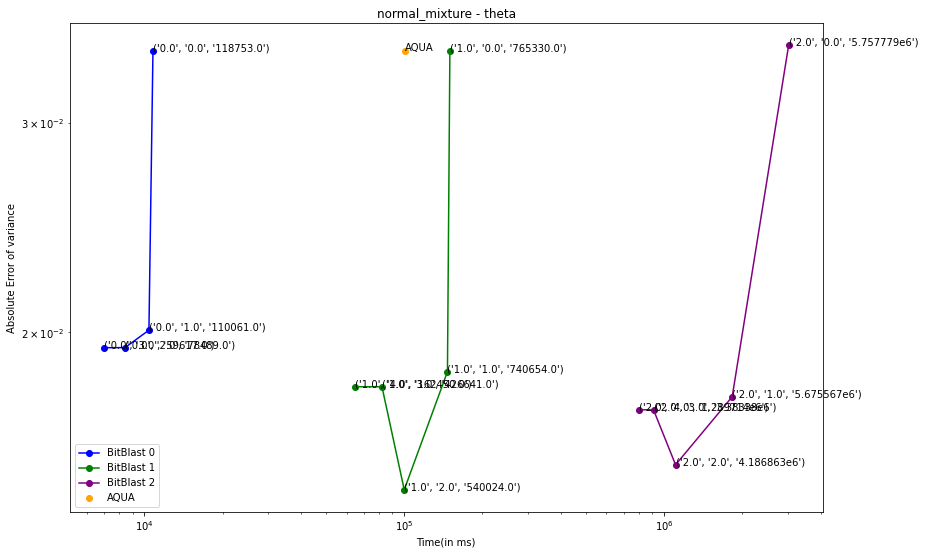

In [70]:
fig, ax = plotting_dice_data('variance', "normal_mixture", "theta", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_0.txt",
                            0, 3, 0, gt_variance['theta'], AQUA_time, AQUA_variance['theta'], True, 's')

2.9110381228019877 4.673574998285518


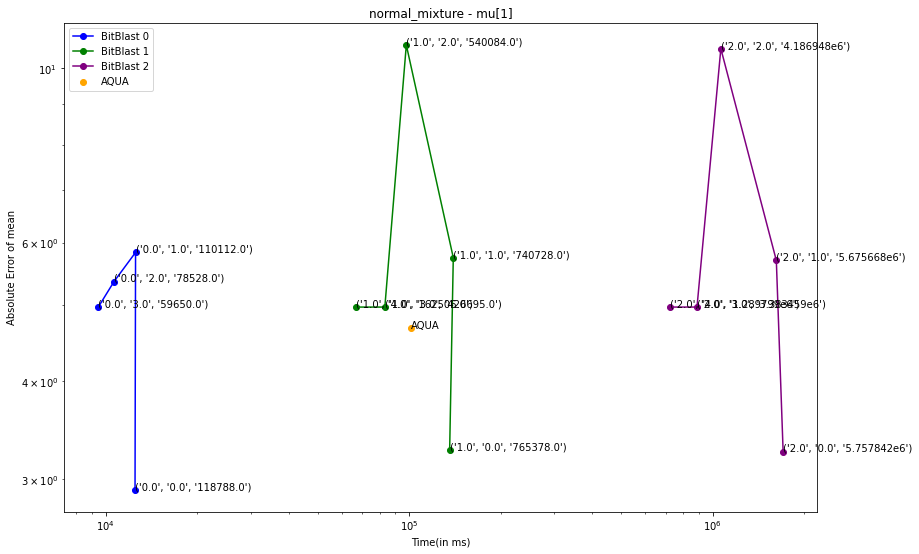

In [71]:
fig, ax = plotting_dice_data('mean', "normal_mixture", "mu[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_1.txt",
                            0, 3, 1/2, gt_mean['mu[1]'], AQUA_time, AQUA_mean['mu[1]'], True, 's')

50.23628438949954 65.51055198847253


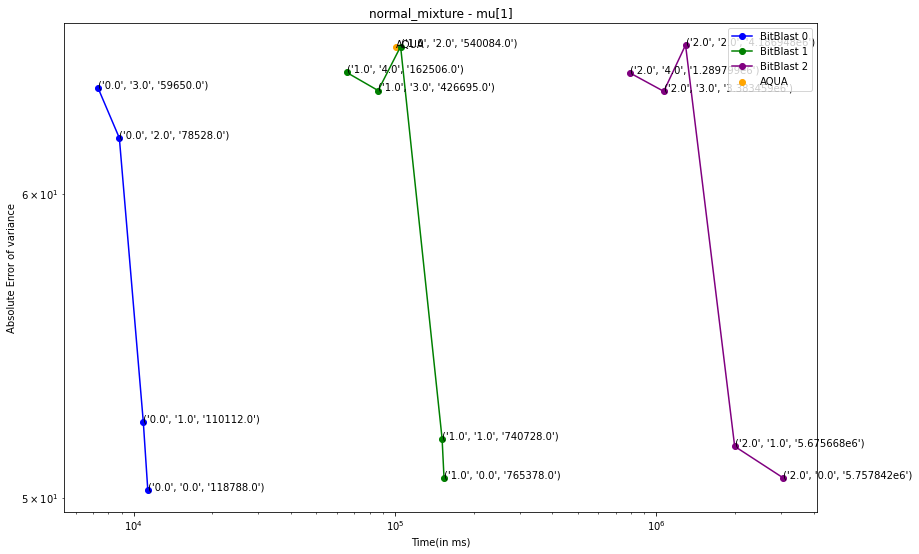

In [72]:
fig, ax = plotting_dice_data('variance', "normal_mixture", "mu[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_1.txt",
                            0, 3, 0, gt_variance['mu[1]'], AQUA_time, AQUA_variance['mu[1]'], True, 's')

3.0176345606257424 4.423150292084034


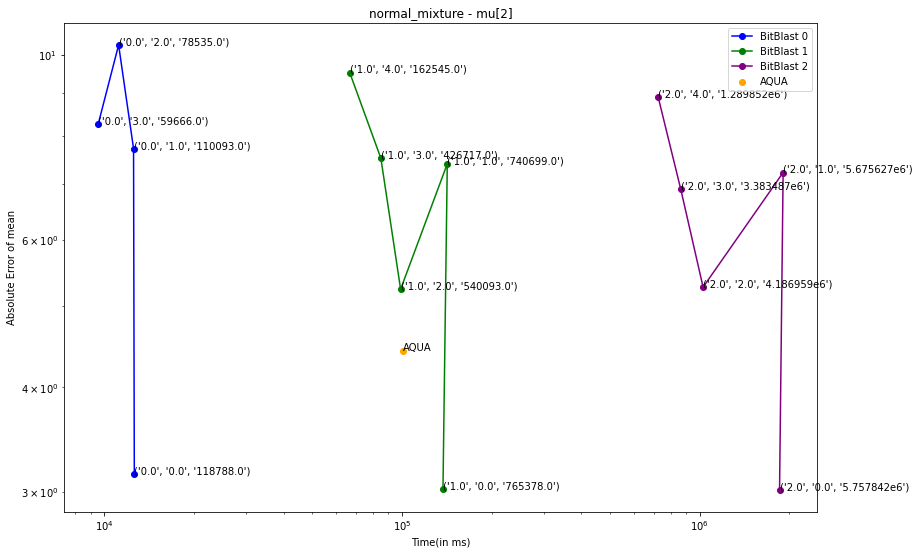

In [73]:
fig, ax = plotting_dice_data('mean', "normal_mixture", "mu[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_2.txt",
                            0, 3, 1/2, gt_mean['mu[2]'], AQUA_time, AQUA_mean['mu[2]'], True, 's')

19.795246268556582 58.71244648932445


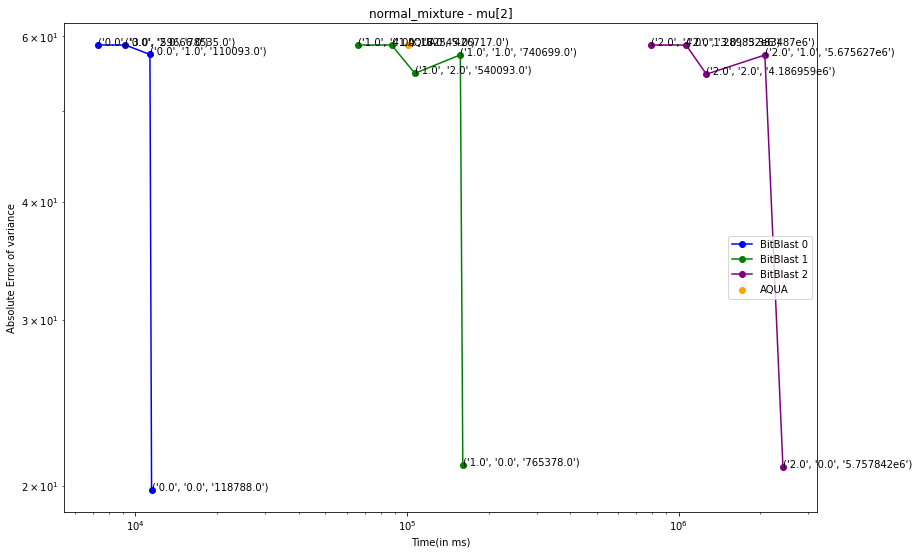

In [74]:
fig, ax = plotting_dice_data('variance', "normal_mixture", "mu[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_2.txt",
                            0, 3, 0, gt_variance['mu[2]'], AQUA_time, AQUA_variance['mu[2]'], True, 's')

Timeseries

In [67]:
# Ground Truth

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/timeseries/results.txt", ['alpha', 'beta', 'lambda'])
print(gt_mean, gt_variance)

{'alpha': -1.576438438, 'beta': 0.6838821225, 'lambda': 0.4761626538} {'alpha': 0.08718596305430863, 'beta': 0.007727501118365029, 'lambda': 0.009083154147157666}


-2.7 -0.2999999999999984
0.2000000009 1.2000000003999973
0.2000000008 0.8000000002000003
{'alpha': -1.5752270953520866, 'beta': 0.6840096410299795, 'lambda': 0.4765680957849794} {'alpha': 0.08564906735148714, 'beta': 0.00771888126303194, 'lambda': 0.008911417608545469}


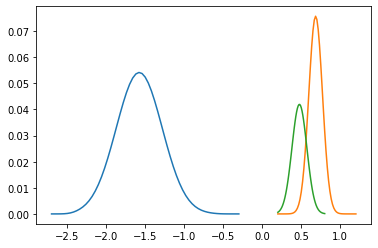

In [68]:
AQUA_mean, AQUA_variance = {}, {}
vars = ['alpha', 'beta', 'lambda']
for i in vars:
    # print(i)
    AQUA_mean[i], AQUA_variance[i] = read_AQUA_file(f"/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/timeseries/analysis_{i}.txt")
print(AQUA_mean, AQUA_variance)

[5.01110572167701, 1.37860895061018, 1.6311052141018891, 2.0762181050303483]
[5.098804796029037, 0.7762210118677426, 0.8491214394484696, 1.077282356567015, 1.1449238633280003]
[5.092979092533643, 0.470584755692937, 0.5102107244597398, 0.574363705047295, 0.6683145822985306, 0.6126112624538196]


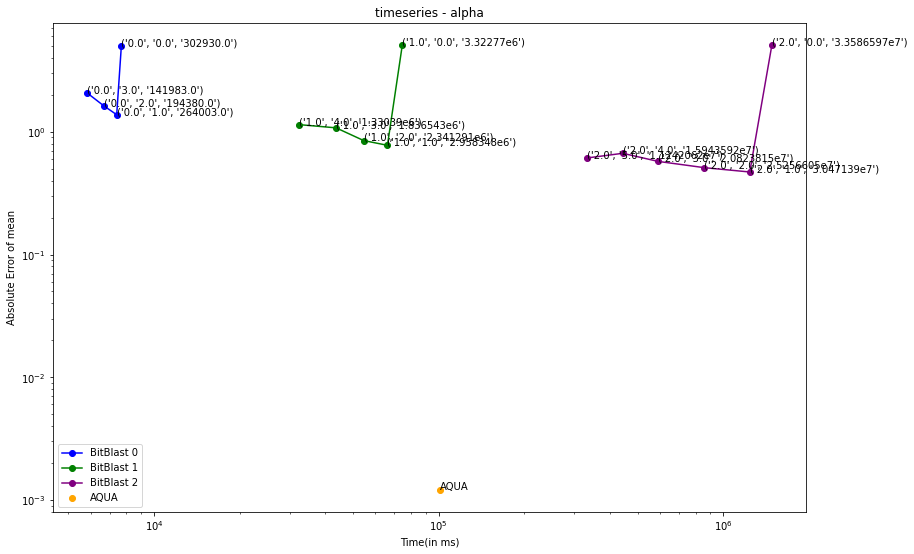

In [71]:
fig, ax = plotting_dice_data('mean', "timeseries", "alpha", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries_new/results_second_0.txt",
                            0, 3, 1/2, gt_mean['alpha'], AQUA_time, AQUA_mean['alpha'], True, 's')

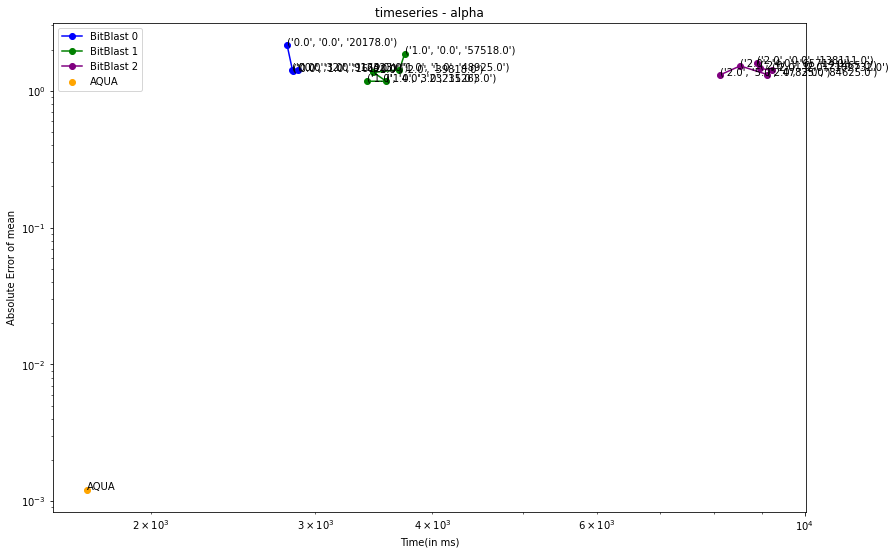

In [49]:
fig, ax = plotting_dice_data('mean', "timeseries", "alpha", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries/results_0.txt",
                            0, , 1/2, gt_mean['alpha'], AQUA_time, AQUA_mean['alpha'], True, 's')

[0.019822915999798615, 1.0780455800998001, 0.6006650976421297, 0.08695542761630795]
[0.052751099146704936, 0.8112058458345746, 0.4955473673478656, 0.0909656384702346, 0.011707556143377304]
[0.08186471922590906, 0.7620326048013175, 0.47956736198487476, 0.16028602391603014, 0.013266024826832215, 0.004119193662292256]


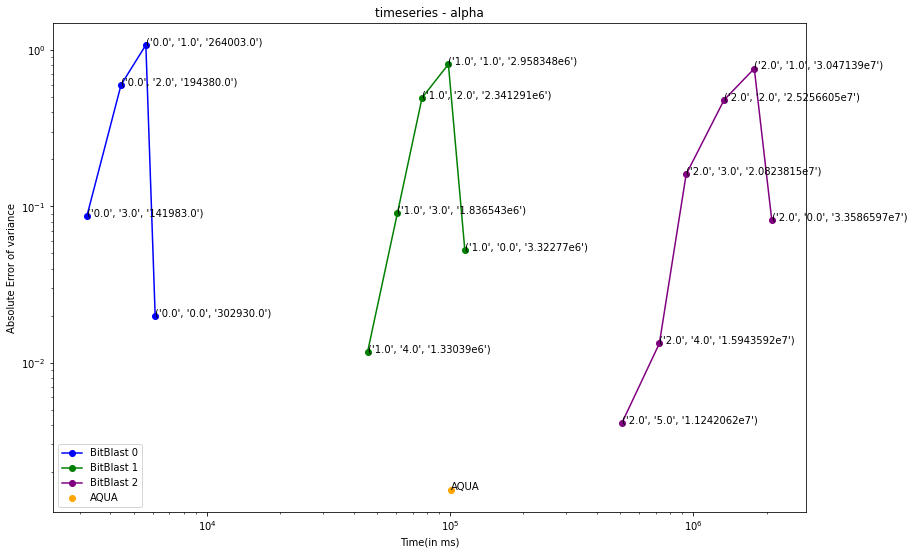

In [72]:
fig, ax = plotting_dice_data('variance', "timeseries", "alpha", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries_new/results_second_0.txt",
                            0, 3, 0, gt_variance['alpha'], AQUA_time, AQUA_variance['alpha'], True, 's')

[0.18649110014221892, 0.336467288224678, 0.37664308637872557, 0.5649313328839272]
[0.13232748468502575, 0.1595088486412688, 0.18330632688153192, 0.2517579487282239, 0.25717600771338667]
[0.10409011809090418, 0.07268242943009007, 0.08414387823845848, 0.09533982887060943, 0.08216186805856618, 0.0895551092350092]


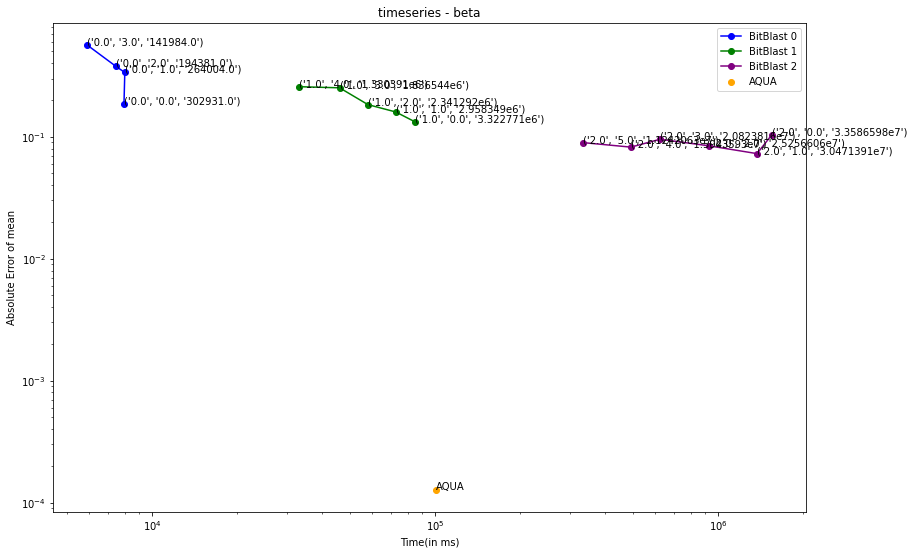

In [73]:
fig, ax = plotting_dice_data('mean', "timeseries", "beta", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries_new/results_second_1.txt",
                            0, 3, 1/4, gt_mean['beta'], AQUA_time, AQUA_mean['beta'], True, 's')

[0.243521542134469, 0.26885376586333903, 0.09378866052916142, 0.007135636373634867]
[0.4487505888975361, 0.22619585201103834, 0.0677476551116002, 0.018294451073085742, 0.015219864431384159]
[0.4250539216511329, 0.2244168387690664, 0.06607587831343213, 0.01069659445056686, 0.000624560612983392, 0.0015527963060841272]


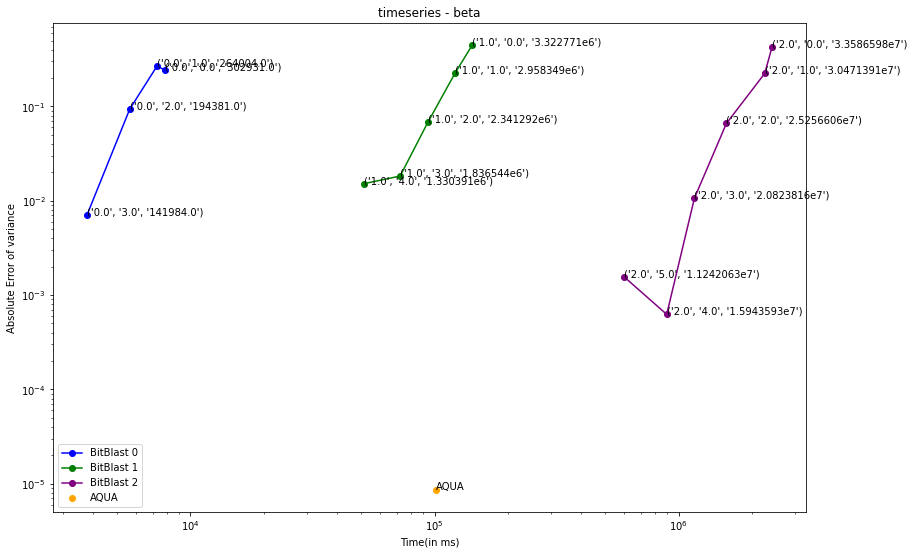

In [78]:
fig, ax = plotting_dice_data('variance', "timeseries", "beta", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries_new/results_second_1.txt",
                            0, 3, 0, gt_variance['beta'], AQUA_time, AQUA_variance['beta'], True, 's')

[0.3934163904377258, 0.04142559698467896, 0.0924974774414632, 0.2112809832239707]
[0.3523105289143705, 0.03628830740808264, 0.05483487262161757, 0.13217938277526042, 0.16315136880993997]
[0.32068105751542764, 0.032220510651414846, 0.04234054417325395, 0.06420089874523305, 0.0877383101293645, 0.07720648527839369]


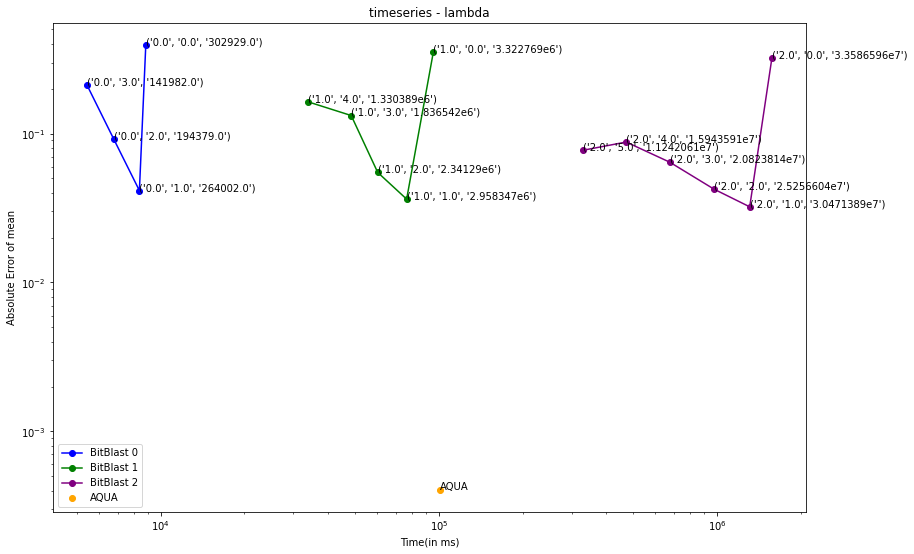

In [79]:
fig, ax = plotting_dice_data('mean', "timeseries", "lambda", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries_new/results_second_2.txt",
                            0, 3, 1/16, gt_mean['lambda'], AQUA_time, AQUA_mean['lambda'], True, 's')

[0.0043868623601841265, 0.0648077622651578, 0.04092527014144448, 0.009067785665011461]
[0.005800130808794447, 0.06359081028671908, 0.04684009974441737, 0.012421820554587749, 0.0003322669265587337]
[0.009282641666235247, 0.06317424712845265, 0.04643054427361083, 0.016723764687449343, 0.0008151989468654208, 0.00011563444627686777]


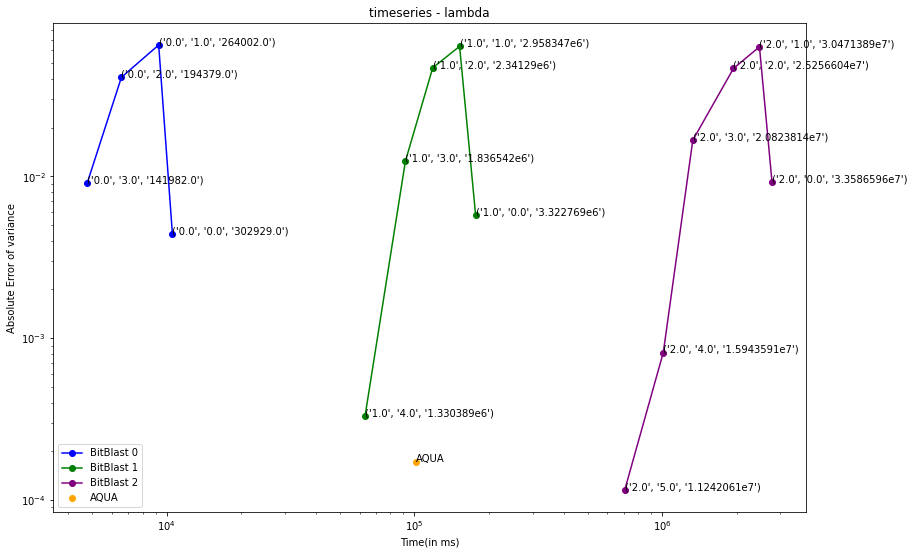

In [82]:
fig, ax = plotting_dice_data('variance', "timeseries", "lambda", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries_new/results_second_2.txt",
                            0, 3, 0, gt_variance['lambda'], AQUA_time, AQUA_variance['lambda'], True, 's')

Unemployment_5

1.3284980685423304 0.8650436277728923


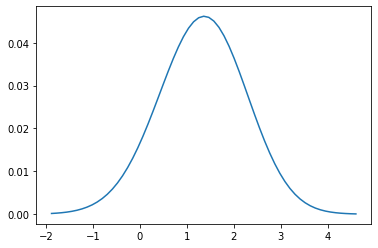

In [25]:
AQUA_beta1_mean, AQUA_beta1_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_5/analysis_beta[1].txt")
print(AQUA_beta1_mean, AQUA_beta1_variance)

0.7071301653245889 0.04887100594148075


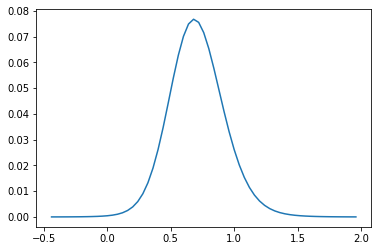

In [26]:
AQUA_beta2_mean, AQUA_beta2_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_5/analysis_beta[2].txt")
print(AQUA_beta2_mean, AQUA_beta2_variance)



1e-11 6.000000000008805
1.552277816519795 0.6940600359165652


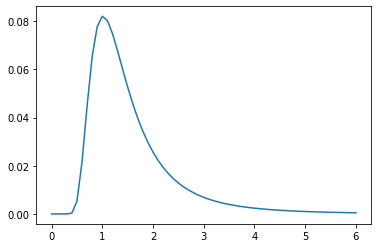

In [38]:
AQUA_sigma_mean, AQUA_sigma_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_5/analysis_sigma.txt")
print(AQUA_sigma_mean, AQUA_sigma_variance)

In [10]:
gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/unemployment_5/results.txt", ['beta[1]', 'beta[2]', 'sigma'])
print(gt_mean, gt_variance)
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_5/AQUA_time.txt")
print(AQUA_time)

{'beta[1]': 1.324379118, 'beta[2]': 0.7085033127, 'sigma': 1.613857191} {'beta[1]': 0.8724381647938275, 'beta[2]': 0.05189122008128229, 'sigma': 1.2149735891886273}
1170.264915


0.2693067572702357 0.004118950542330468


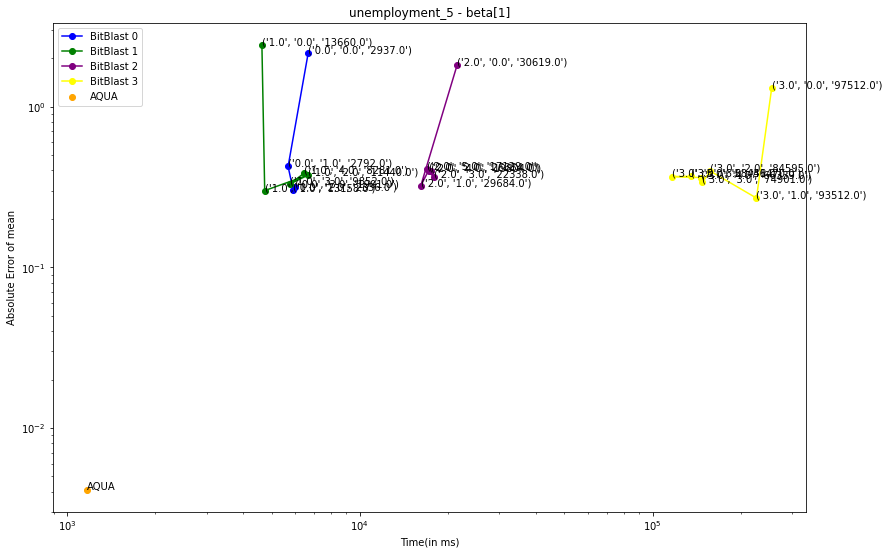

In [31]:
fig, ax = plotting_dice_data('mean', "unemployment_5", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_0.txt",
                            0, 4, 0.5, gt_mean['beta[1]'], AQUA_time, AQUA_beta1_mean, True, 's')

# plotting_dice_data(mean_or_var, title, var_name, result_file, lowerlimit, upperlimit, offset, gt, AQUA_time, AQUA_val, annot, s_or_ms):

0.11481377268695048 0.007394537020935177


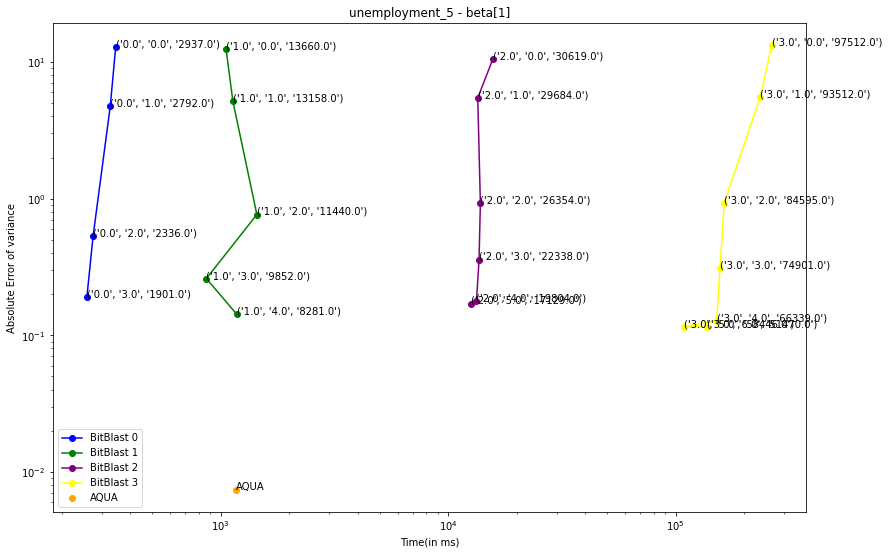

In [32]:
fig, ax = plotting_dice_data('variance', "unemployment_5", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_0.txt",
                            0, 4, 0, gt_variance['beta[1]'], AQUA_time, AQUA_beta1_variance, True, 's')

0.09568911043340644 0.0013731473754110546


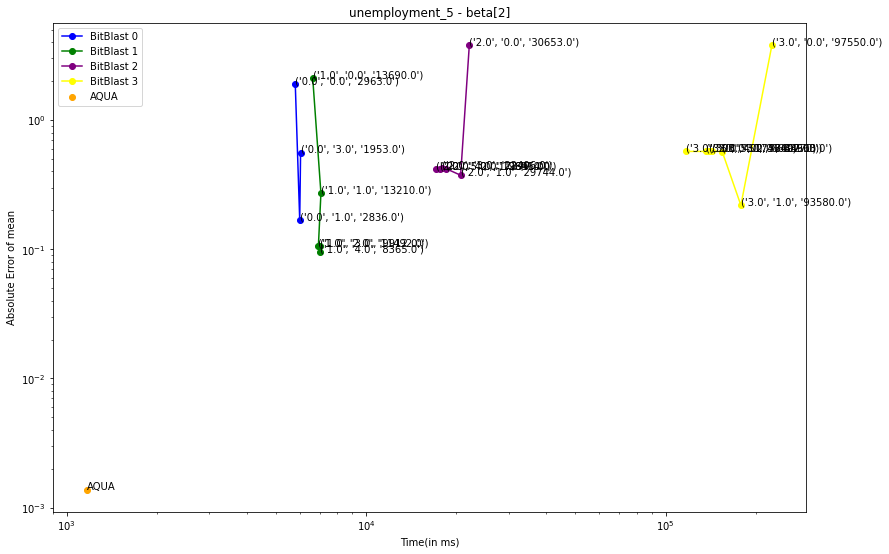

In [33]:
fig, ax = plotting_dice_data('mean', "unemployment_5", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_1.txt",
                            0, 4, 0.125, gt_mean['beta[2]'], AQUA_time, AQUA_beta2_mean, True, 's')

0.017345148605239807 0.0030202141398015386


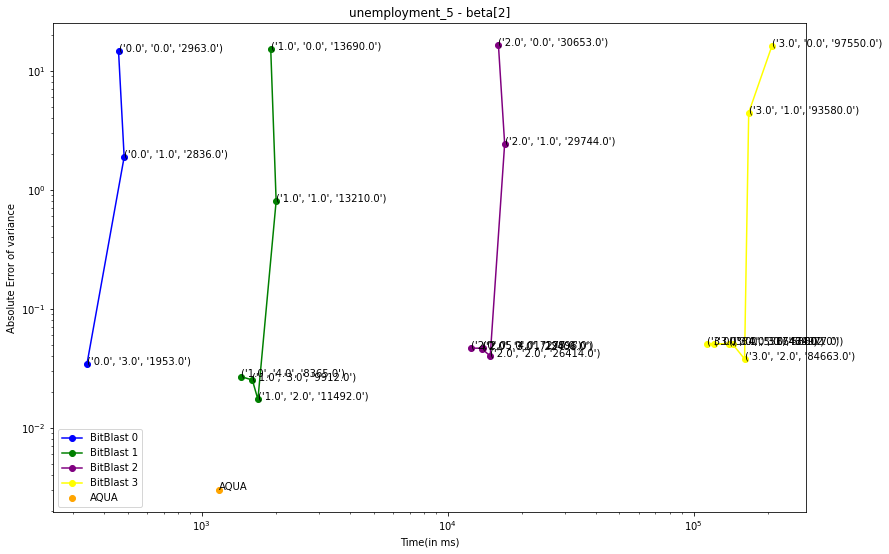

In [34]:
fig, ax = plotting_dice_data('variance', "unemployment_5", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_1.txt",
                            0, 4, 0, gt_variance['beta[2]'], AQUA_time, AQUA_beta2_variance, True, 's')

0.21079201304406037 0.061579374480204896


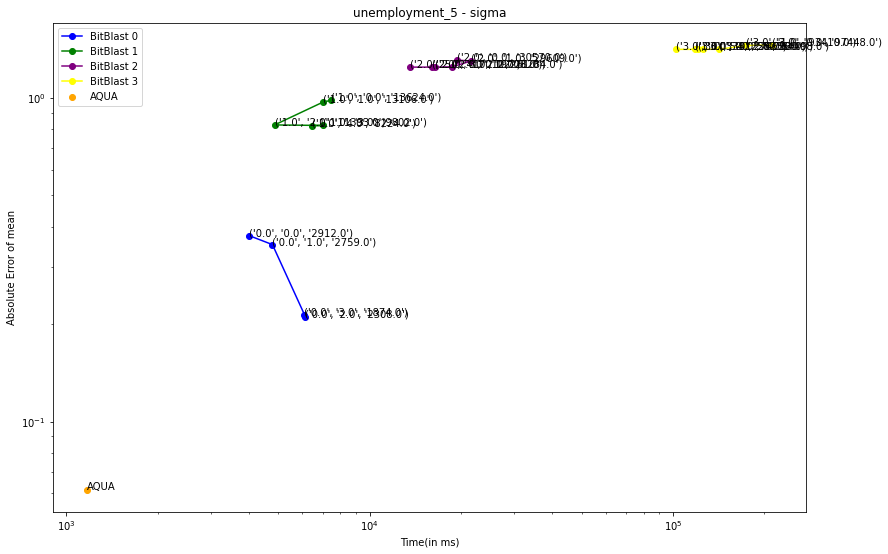

In [35]:
fig, ax = plotting_dice_data('mean', "unemployment_5", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_2.txt",
                            0, 4, 0.125, gt_mean['sigma'], AQUA_time, AQUA_sigma_mean, True, 's')

0.8935201029966602 0.5209135532720621


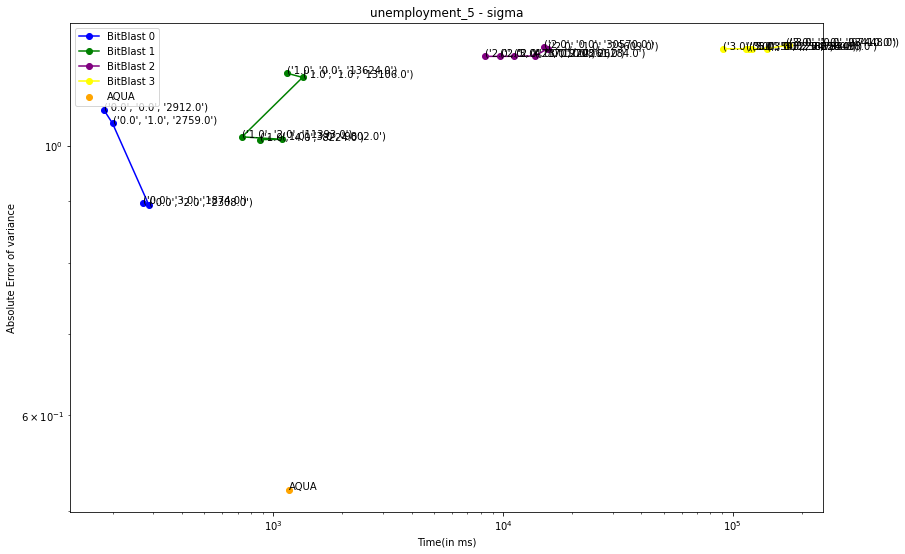

In [36]:
fig, ax = plotting_dice_data('variance', "unemployment_5", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_2.txt",
                            0, 4, 0, gt_variance['sigma'], AQUA_time, AQUA_sigma_variance, True, 's')

Zeroone

In [53]:
# Ground Truth
gt_mean, gt_variance = {}, {}
gt_mean['w1'] = 0.0565823032448
gt_variance['w1'] = 18.2304754051

gt_mean['w2'] = 3.68882559517
gt_variance['w2'] = 13.1973498958

-8.0 8.00000000000001
-8.0 8.00000000000001
{'w1': -0.039999999999992895, 'w2': -0.039999999999992895} {'w1': 21.332800000000024, 'w2': 21.332800000000024}


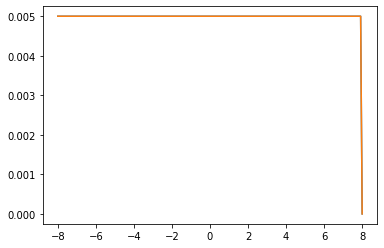

In [54]:
AQUA_mean, AQUA_variance = {}, {}
vars = ['w1', 'w2']
for i in vars:
    # print(i)
    AQUA_mean[i], AQUA_variance[i] = read_AQUA_file(f"/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/zeroone/analysis_{i}.txt")
print(AQUA_mean, AQUA_variance)

['0.0,0.0,32.0,570.0,2.491127793,0.9707410933906928,0.173015232,15.542657786512066\n', '1.0,0.0,35.0,1805.0,3.528126637,0.8830024143044968,0.512015879,16.115191334621976\n', '2.0,0.0,38.0,5697.0,3.610755742,0.863901046549377,1.25770011,16.256073218587034\n', '3.0,0.0,41.0,19805.0,2.939074445,0.28099839048067654,2.355752683,17.93422210879102\n', '4.0,0.0,44.0,47200.0,6.034474067,0.08807179530736864,11.257331017,18.19838685759482\n', '5.0,0.0,47.0,99228.0,7.596690918,0.08945132408338186,15.871075422,18.202003123412737\n', '6.0,0.0,50.0,216528.0,17.519396488,0.08990485690824812,67.965228893,18.2034935096301\n', '7.0,0.0,53.0,459572.0,38.022211417,0.06887273537811645,182.294029074,18.220985961377586\n', '8.0,0.0,56.0,987528.0,73.946849199,0.05857515218357534,278.251458202,18.228753237665778\n', '9.0,0.0,59.0,2.084272e6,143.660137651,0.05860810642524594,968.86046041,18.228908999460792\n', '10.0,0.0,62.0,4.575074e6,430.761678374,0.05862369410721513,2225.523028352,18.228985518829553\n']
0.970

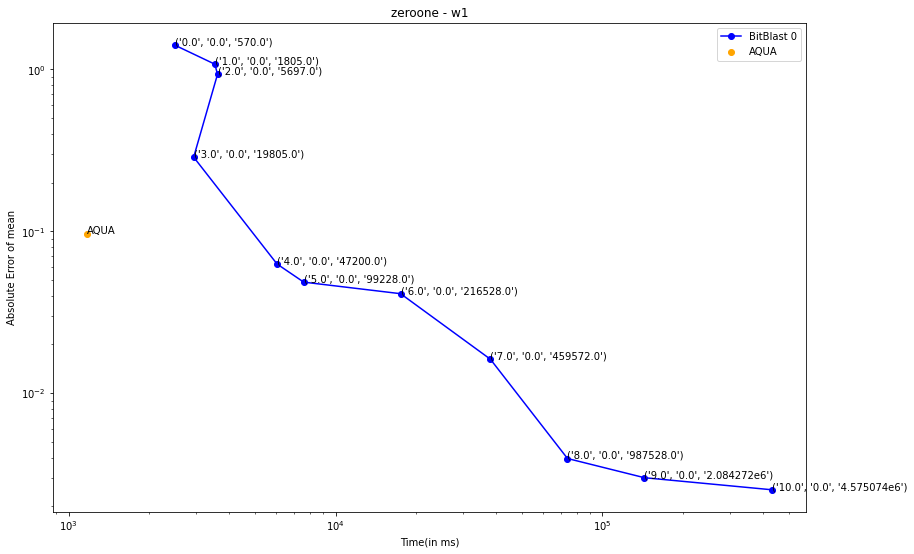

In [77]:
fig, ax = plotting_dice_bits('mean', "zeroone", "w1", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/zeroone/results_0.txt",
                            0, 1, 0.5, gt_mean['w1'], AQUA_time, AQUA_mean['w1'], True, 's')

# plotting_dice_data(mean_or_var, title, var_name, result_file, lowerlimit, upperlimit, offset, gt, AQUA_time, AQUA_val, annot, s_or_ms):

['0.0,0.0,32.0,570.0,2.491127793,0.9707410933906928,0.173015232,15.542657786512066\n', '1.0,0.0,35.0,1805.0,3.528126637,0.8830024143044968,0.512015879,16.115191334621976\n', '2.0,0.0,38.0,5697.0,3.610755742,0.863901046549377,1.25770011,16.256073218587034\n', '3.0,0.0,41.0,19805.0,2.939074445,0.28099839048067654,2.355752683,17.93422210879102\n', '4.0,0.0,44.0,47200.0,6.034474067,0.08807179530736864,11.257331017,18.19838685759482\n', '5.0,0.0,47.0,99228.0,7.596690918,0.08945132408338186,15.871075422,18.202003123412737\n', '6.0,0.0,50.0,216528.0,17.519396488,0.08990485690824812,67.965228893,18.2034935096301\n', '7.0,0.0,53.0,459572.0,38.022211417,0.06887273537811645,182.294029074,18.220985961377586\n', '8.0,0.0,56.0,987528.0,73.946849199,0.05857515218357534,278.251458202,18.228753237665778\n', '9.0,0.0,59.0,2.084272e6,143.660137651,0.05860810642524594,968.86046041,18.228908999460792\n', '10.0,0.0,62.0,4.575074e6,430.761678374,0.05862369410721513,2225.523028352,18.228985518829553\n']
0.970

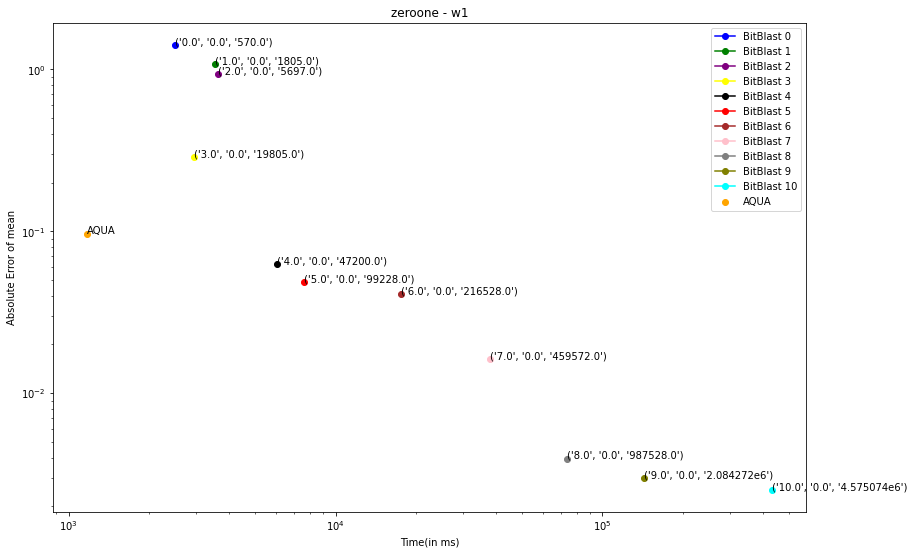

In [73]:
fig, ax = plotting_dice_data('mean', "zeroone", "w1", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/zeroone/results_0.txt",
                            0, 11, 0.5, gt_mean['w1'], AQUA_time, AQUA_mean['w1'], True, 's')

Unemployment 1 observation

-2.5999999999999996 4.600000000000005
0.9707417842919298 0.9834423916234627


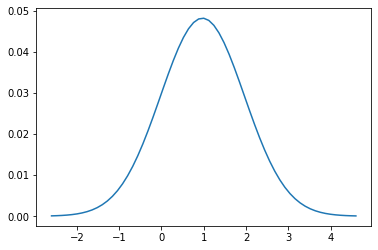

In [7]:
AQUA_beta1_mean, AQUA_beta1_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_1/analysis_beta[1].txt")
print(AQUA_beta1_mean, AQUA_beta1_variance)

-2.5999999999999996 4.600000000000005
0.8713842213134214 0.7433059926546526


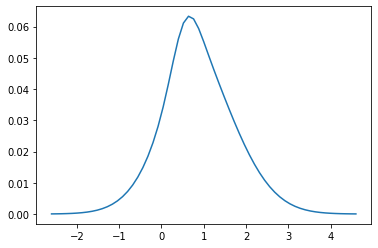

In [8]:
AQUA_beta2_mean, AQUA_beta2_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_1/analysis_beta[2].txt")
print(AQUA_beta2_mean, AQUA_beta2_variance)



1e-11 49.99999999999994
15.601195437546476 180.0168309835391


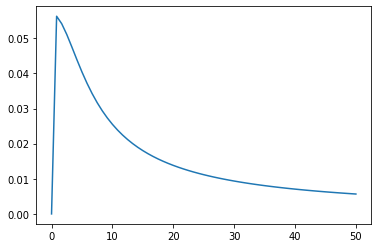

In [9]:
AQUA_sigma_mean, AQUA_sigma_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_1/analysis_sigma.txt")
print(AQUA_sigma_mean, AQUA_sigma_variance)


In [10]:
gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/unemployment_1/results.txt", ['beta[1]', 'beta[2]', 'sigma'])
print(gt_mean, gt_variance)
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_1/AQUA_time.txt")
print(AQUA_time)

{'beta[1]': 1.324379118, 'beta[2]': 0.7085033127, 'sigma': 1.613857191} {'beta[1]': 0.8724381647938275, 'beta[2]': 0.05189122008128229, 'sigma': 1.2149735891886273}
872.092709


[1.5024027453727067, 0.23134668700849925, 0.41577249269109817, 0.33023753167428005]
[1.4118838329883756, 0.26180287759523013, 0.42245885179582654, 0.34460175296994944, 0.3618784114614413]
[1.3756784995939642, 0.2963788090968422, 0.4149663555199288, 0.34935919831282947, 0.3655376381620927, 0.36342695729975016]


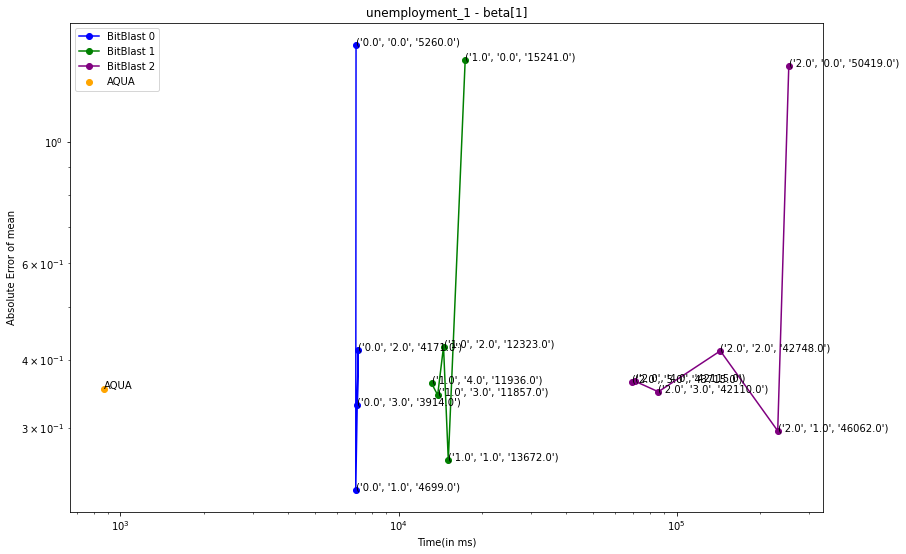

In [11]:
fig, ax = plotting_dice_data('mean', "unemployment_1", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_oneobs_0.txt",
                            0, 3, 0.5, gt_mean['beta[1]'], AQUA_time, AQUA_beta1_mean, True, 's')

# plotting_dice_data(mean_or_var, title, var_name, result_file, lowerlimit, upperlimit, offset, gt, AQUA_time, AQUA_val, annot, s_or_ms):

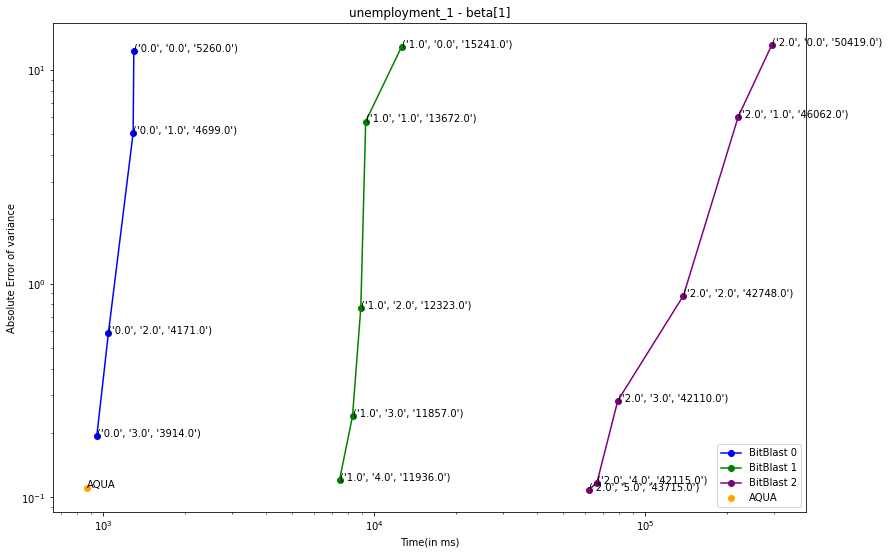

In [26]:
fig, ax = plotting_dice_data('variance', "unemployment_1", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_oneobs_0.txt",
                            0, 3, 0, gt_variance['beta[1]'], AQUA_time, AQUA_beta1_variance, True, 's')

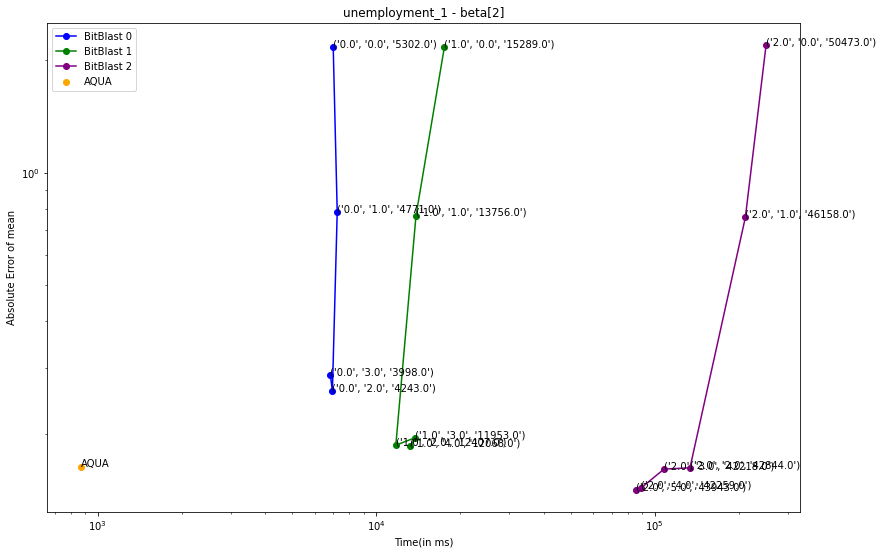

In [28]:
fig, ax = plotting_dice_data('mean', "unemployment_1", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_oneobs_1.txt",
                            0, 3, 0.125, gt_mean['beta[2]'], AQUA_time, AQUA_beta2_mean, True, 's')

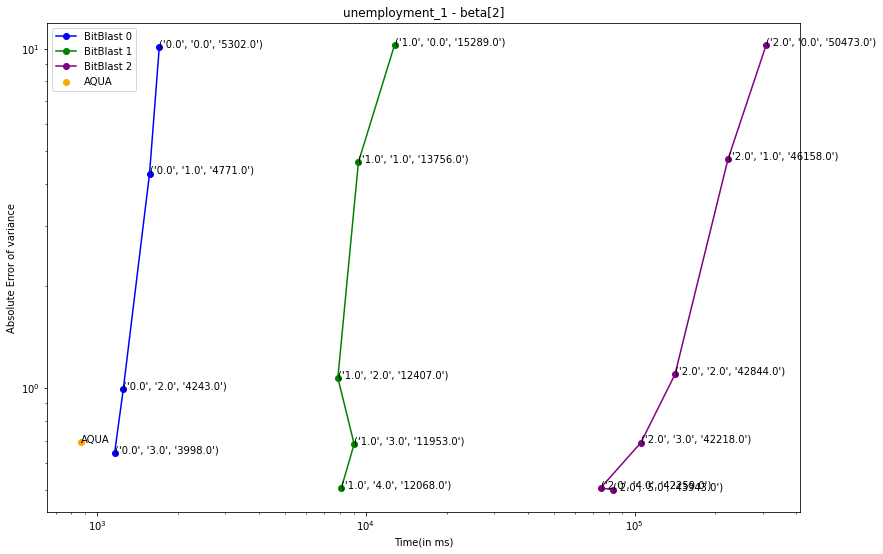

In [29]:
fig, ax = plotting_dice_data('variance', "unemployment_1", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_oneobs_1.txt",
                            0, 3, 0, gt_variance['beta[2]'], AQUA_time, AQUA_beta2_variance, True, 's')

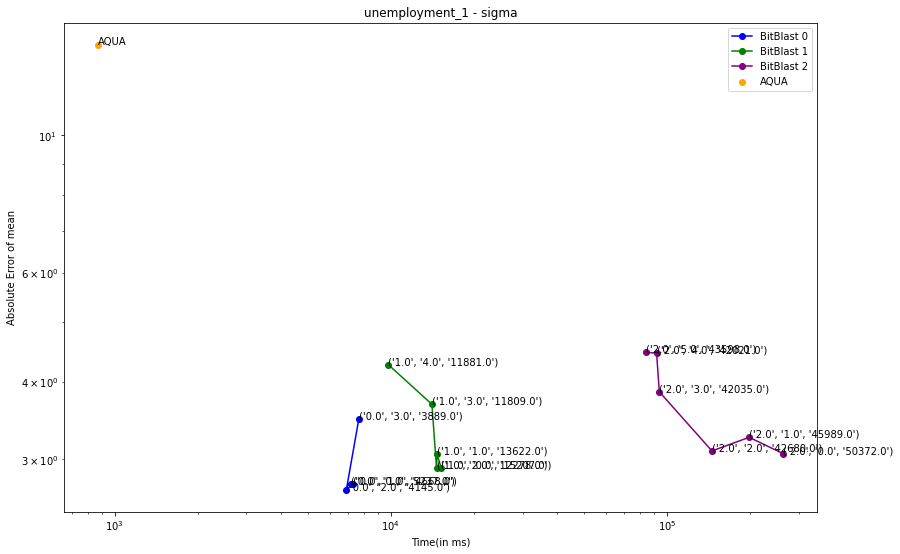

In [30]:
fig, ax = plotting_dice_data('mean', "unemployment_1", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_oneobs_2.txt",
                            0, 3, 0.125, gt_mean['sigma'], AQUA_time, AQUA_sigma_mean, True, 's')

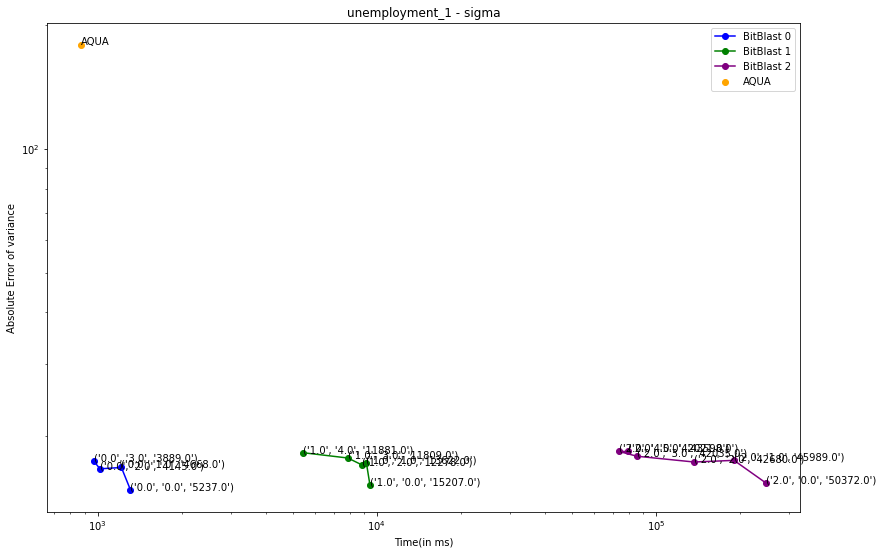

In [31]:
fig, ax = plotting_dice_data('variance', "unemployment_1", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_new/results_oneobs_2.txt",
                            0, 3, 0, gt_variance['sigma'], AQUA_time, AQUA_sigma_variance, True, 's')

Shifted Anova with one observation

-4.0 4.000000000000005
0.33291523821283203 3.4381533487708604


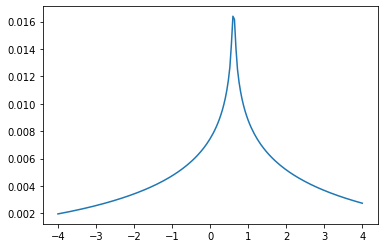

In [19]:
AQUA_a_mean, AQUA_a_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/anova_radon_nopred/analysis_a.txt")
print(AQUA_a_mean, AQUA_a_variance)

1e-09 7.999999999999962
3.307218744394642 4.865668862563814


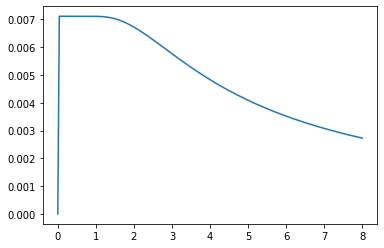

In [20]:
AQUA_sigma_mean, AQUA_sigma_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/anova_radon_nopred/analysis_sigma_y.txt")
print(AQUA_sigma_mean, AQUA_sigma_variance)

In [22]:
gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/anova_radon_nopred/results_1obs.txt", ['a', 'sigma_y'])
print(gt_mean, gt_variance)
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/anova_radon_nopred/runtime2.txt")
print(AQUA_time)

mm_mean = {}
mm_variance = {}
mm_mean['a'] = 0.33327257363
mm_variance['a'] = 3.39324803207

{'a': 0.3300823875, 'sigma_y': 3.333202007} {'a': 3.444141953421122, 'sigma_y': 4.779150892859671}
874.029274


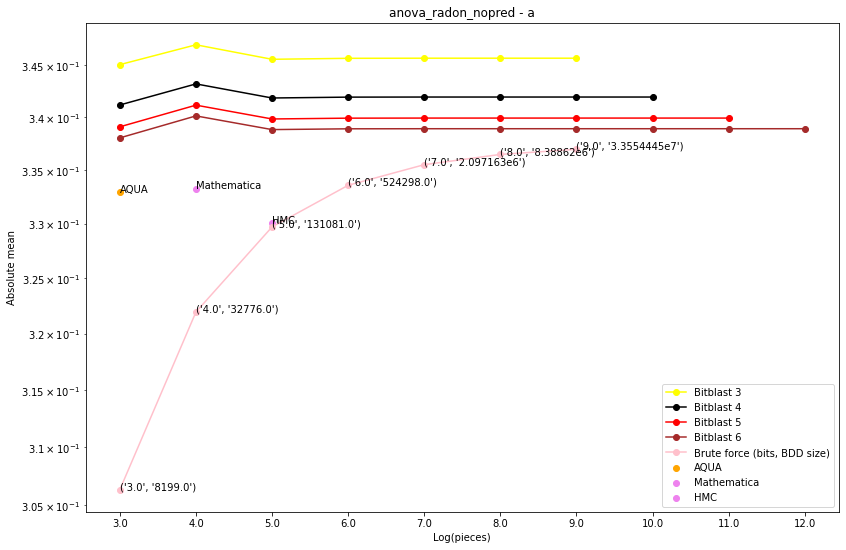

In [80]:
other_pts = [['Mathematica', mm_mean['a'], 1.0], ["HMC", gt_mean['a'], 2.0]]
fig, ax = plotting_abs_exp('mean', "anova_radon_nopred", "a", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/results_oneobs_0.txt",
                            3, 8, 0.5, 0.0, AQUA_time, AQUA_a_mean, False, 's', other_pts)

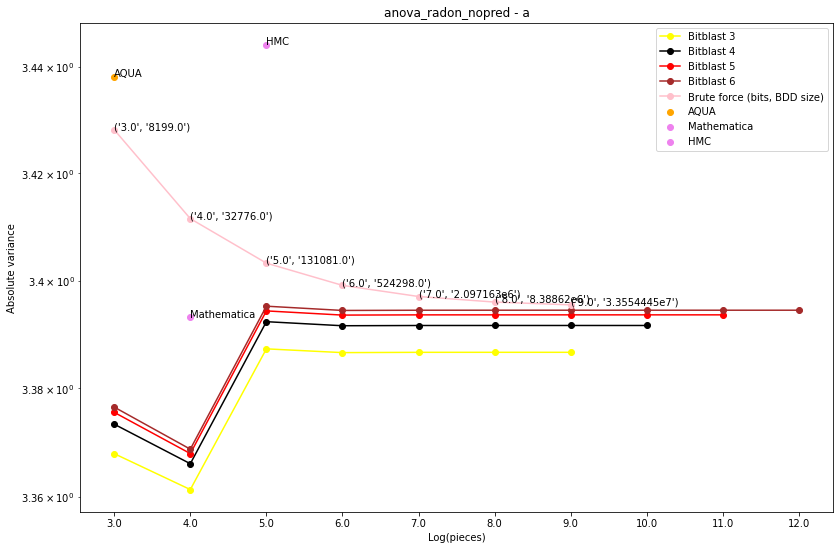

In [76]:
other_pts = [['Mathematica', mm_variance['a'], 1.0], ["HMC", gt_variance['a'], 2.0]]
fig, ax = plotting_abs_exp('variance', "anova_radon_nopred", "a", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/results_oneobs_0.txt",
                            3, 8, 0.0, 0.0, AQUA_time, AQUA_a_variance, False, 's', other_pts)

[4.218334595293527, 4.003272917830145, 3.686287612666547, 3.281139141230142, 3.280337080450863, 3.2962828910258395, 3.29734063748856]
[4.389972191663219, 4.129708189829671, 3.787395638091766, 3.362422076304938, 3.356587106905863, 3.3762542328322525, 3.37673562585087, 3.3768085547580995]
[4.398508891613801, 4.122565326117183, 3.7789118079044783, 3.366576891591194, 3.360458563874545, 3.3846350828061986, 3.3843097999829297, 3.3844026532669886, 3.384398919945397]
[4.403018655400956, 4.121569321922834, 3.776459804305432, 3.367954059971453, 3.3613428359308273, 3.387319361635491, 3.3866222920314613, 3.3866758496942566, 3.3866784056567667, 3.3866787341526106]
[4.361334506646472, 4.128691720617553, 3.7820273561874274, 3.3733887363523536, 3.3660998732520966, 3.392359978809509, 3.3916058284366954, 3.3916509205246257, 3.391654379593092, 3.3916545475390194, 3.391654564602959]


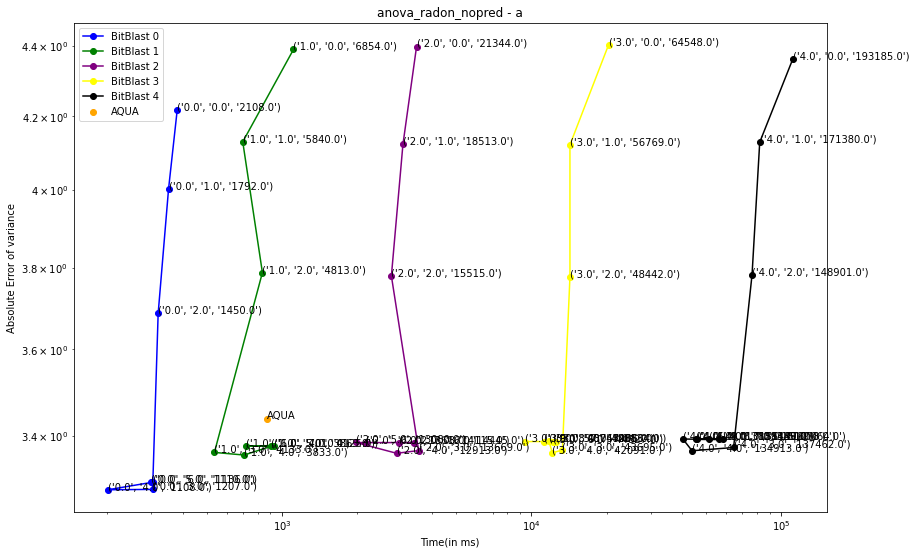

In [75]:
fig, ax = plotting_dice_data('variance', "anova_radon_nopred", "a", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/results_oneobs_0.txt",
                            0, 5, 0, 0.0, AQUA_time, AQUA_a_variance, True, 's')

[1.2779274702662322, 0.8454080850229357, 0.4064115793892369, 0.05415938984058366, 0.040263516584048364, 0.04030132204879289, 0.03985259757152315]
[1.274387725617705, 0.8500237490476921, 0.4191632596411572, 0.06517826560952988, 0.048023445472729076, 0.047547608814836995, 0.047191063380514375, 0.04716828956624264]
[1.2783000907552027, 0.8553558933532246, 0.42671996127006384, 0.06811791422887481, 0.04901164079773279, 0.047497099431444756, 0.04736208021083632, 0.04732481716010062, 0.04732648607977863]
[1.278983074229556, 0.8572143236127849, 0.42988144269745066, 0.06954353374878997, 0.04942364557849066, 0.04746230100660398, 0.04744210645178182, 0.04741599184909884, 0.04741502893876737, 0.04741491364825423]
[1.2850200232150444, 0.8569876133862286, 0.43060740573280976, 0.07018176278104571, 0.049585836753077484, 0.04756632666571514, 0.047562057362939836, 0.04753828856694975, 0.047536885959013286, 0.04753681294199996, 0.04753680615270772]


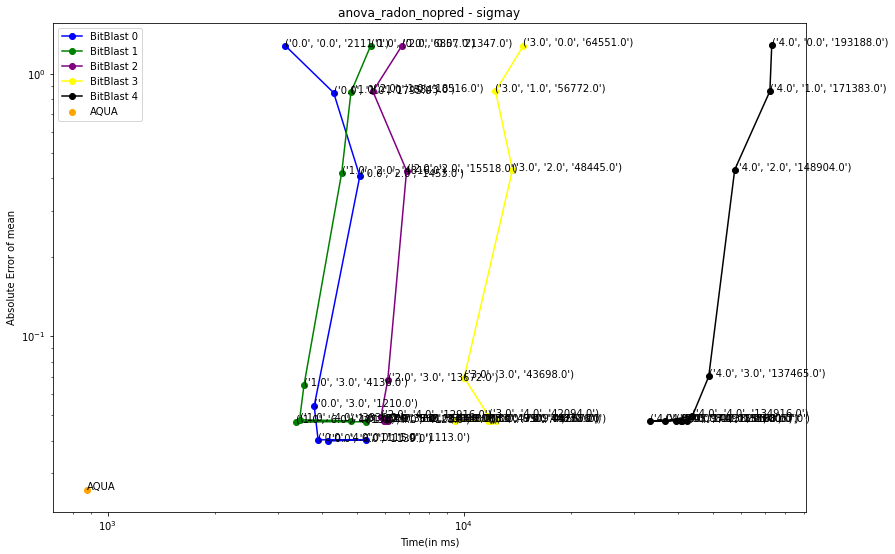

In [11]:
fig, ax = plotting_dice_data('mean', "anova_radon_nopred", "sigmay", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/results_oneobs_1.txt",
                            0, 5, 0.0625, gt_mean['sigma_y'], AQUA_time, AQUA_sigma_mean, True, 's')

[0.5422157447677369, 0.15062402458686375, 0.01820215213429055, 0.14877222751007402, 0.1479652584924036, 0.14169130213896786, 0.14272175707290646]
[0.5416181805856093, 0.16513057499621908, 0.005513621300751836, 0.12129376756029764, 0.12104098163823185, 0.11444685677958333, 0.11514795074122741, 0.11520391027861887]
[0.5435527750329099, 0.17195575538691354, 0.02114626326042046, 0.09874899472220466, 0.0970322253715592, 0.09144105144217196, 0.09157841151213386, 0.09167509030277277, 0.09166793529263018]
[0.541213340951785, 0.1734577375004136, 0.026479969736922904, 0.09049781462763296, 0.08834267685406694, 0.08329173868425332, 0.08310289602640886, 0.0831626525976894, 0.08316416463887055, 0.08316454092420678]
[0.5632107859012834, 0.17132801133110753, 0.025569071242755648, 0.09049975323017101, 0.08851752444144267, 0.08348842240265686, 0.08324557225837825, 0.08329619426979562, 0.08329893186591075, 0.08329911333895357, 0.0832991347966674]


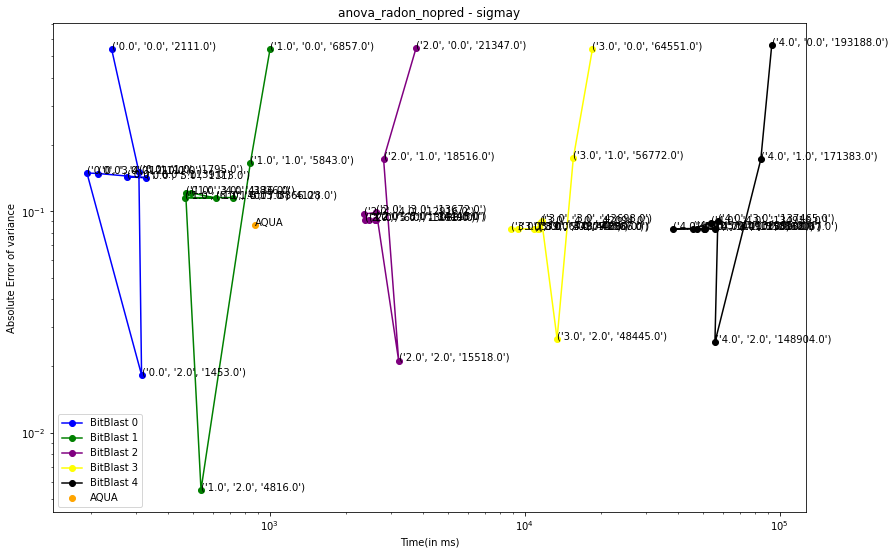

In [12]:
fig, ax = plotting_dice_data('variance', "anova_radon_nopred", "sigmay", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/results_oneobs_1.txt",
                            0, 5, 0, gt_variance['sigma_y'], AQUA_time, AQUA_sigma_variance, True, 's')

Shifted Anova

[0.1582641474751662, 0.09405220704753875, 0.25329231369781186, 0.43819137187941154, 0.4375821670569798, 0.4343853209008009, 0.434847022213865]
[0.2212464518835739, 0.11329464754740654, 0.032264005171683985, 0.06411259976354616, 0.06509263163837803, 0.06294447535466846, 0.06320984563315252, 0.06323415160919327]
[0.2507981996740946, 0.13353441232003233, 0.004452446875943983, 0.005910755902177434, 0.0041892998607827026, 0.004327857184534045, 0.004343438725711357, 0.004344467132312124]
[0.2331004020547746, 0.1021793856063064, 0.03575122781018164, 0.040117701113643156, 0.04209172370091979, 0.04041003028167639, 0.04052757440886895, 0.0405384108065468, 0.040538605006914585, 0.04053869045428288]
[0.3675255532312312, 0.10839836468987668, 0.046377998510494345, 0.02369857904973488, 0.025747482527079646, 0.02425897360481516, 0.024352941574632914, 0.02436196305059385, 0.024362066812258, 0.024362118941566868, 0.024362122338828007]


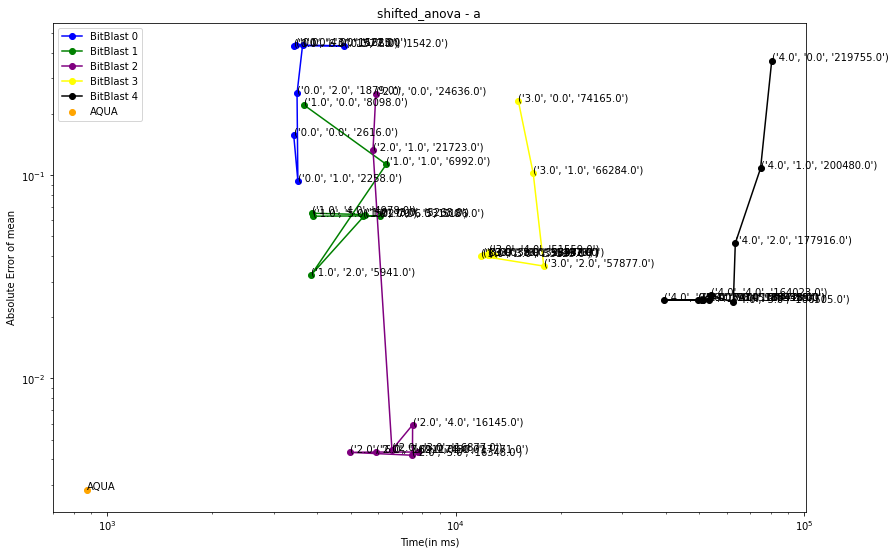

In [20]:
fig, ax = plotting_dice_data('mean', "shifted_anova", "a", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/shifted_anova/results_oneobs_shift_0.txt",
                            0, 5, 0, gt_mean['a'], AQUA_time, AQUA_a_mean, True, 's')

[1.1216703868252167, 0.8639748561475513, 0.4797341553442762, 0.012848312530267858, 0.02690057821412628, 0.03493413972712878, 0.03624326655911281]
[1.0014662752385717, 0.7102090053397929, 0.35394777961330837, 0.06323039787427698, 0.061694279431022014, 0.03935963808878151, 0.039416052007864355, 0.039340894496190604]
[0.9772730652878905, 0.6895830637352716, 0.07003553452493216, 0.0733938026857417, 0.048070883510872964, 0.048643033323669815, 0.04857561088617368, 0.04857536126625783]
[0.9837812226417824, 0.6981147732388577, 0.3482094637532369, 0.06343074843577634, 0.06932206802745933, 0.04391417360208871, 0.04449081007230271, 0.04442395145785705, 0.04442330805220118, 0.044422952850864394]
[0.7318060477976629, 0.6941479434684239, 0.34520946724872337, 0.06492983286413656, 0.07189691315913516, 0.045896456327382484, 0.04659236848571746, 0.0465396341402724, 0.04653713680424554, 0.046536865636581215, 0.0465368648489588]


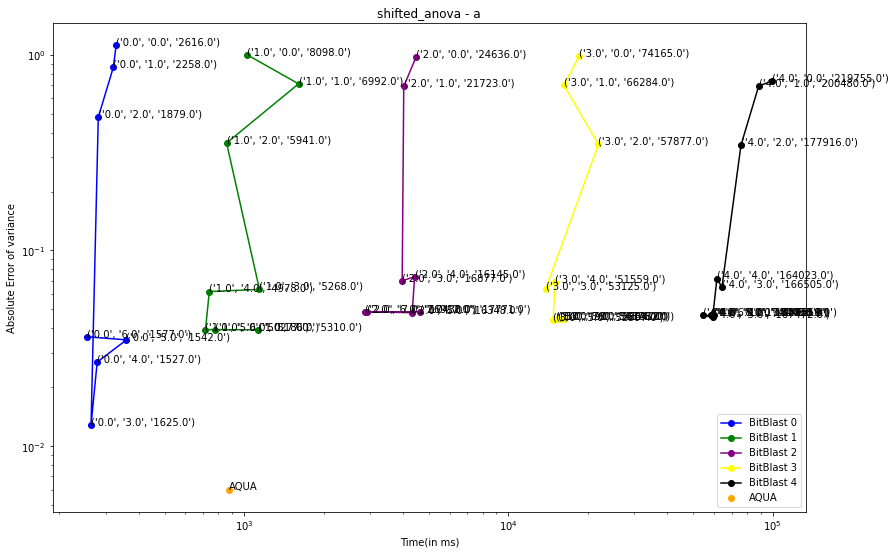

In [14]:
fig, ax = plotting_dice_data('variance', "shifted_anova", "a", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/shifted_anova/results_oneobs_shift_0.txt",
                            0, 5, 0, gt_variance['a'], AQUA_time, AQUA_a_variance, True, 's')

[1.2625793535905565, 0.8074708258270742, 0.38149512734405855, 0.051165727108825276, 0.03769602686886975, 0.03873800431482666]
[1.2736310003331424, 0.8468575421049831, 0.4190436162757267, 0.06455531546520721, 0.047309054267376194, 0.04594467448935413, 0.045773608617722505, 0.045747611911734154]
[1.2769024379815899, 0.8538432594608447, 0.42693990197256504, 0.06826820361099051, 0.04912108975307783, 0.0472409926447539, 0.04719671913127588, 0.0471686641127671, 0.04716863361946144]
[1.2766900868916484, 0.8546126665217209, 0.4287565761478658, 0.06979209925795882, 0.049732306772523494, 0.04791426113920583, 0.04785581554025109, 0.04782547362425005, 0.04782535152580891, 0.04782523344164691]
[1.2485752431026231, 0.8557869138424792, 0.43015132673914636, 0.0703767112681537, 0.0498113763230319, 0.047862643075292866, 0.04783941276661752, 0.047813119357121625, 0.047812140345609766, 0.04781202616602487, 0.047812025358424215]


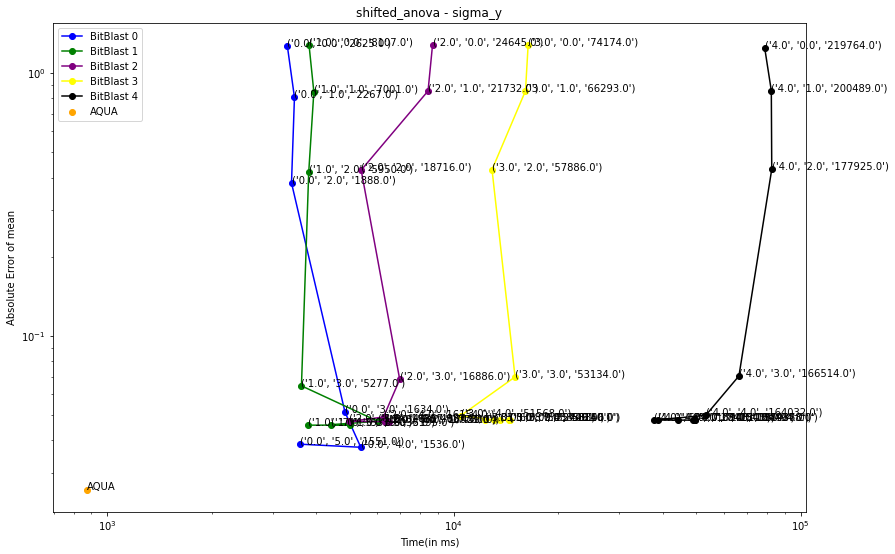

In [21]:
fig, ax = plotting_dice_data('mean', "shifted_anova", "sigma_y", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/shifted_anova/results_oneobs_shift_1.txt",
                            0, 5, 0, gt_mean['sigma_y'], AQUA_time, AQUA_sigma_mean, True, 's')

[0.5300445025470824, 0.0742092382343742, 0.08950484782839396, 0.21727626990542426, 0.21365859057337122, 0.20838942023588025]
[0.5235964325171327, 0.1497039002327094, 0.002822878751076452, 0.11259701237505748, 0.10784862389109318, 0.10296506733141264, 0.10319050313723288, 0.10325904011875675]
[0.5327632809950185, 0.16489651263980232, 0.019943143813664577, 0.09495039175445008, 0.09140205773250987, 0.08655528395709489, 0.08644154139539584, 0.08650999275817561, 0.08650897753997366]
[0.5352375785749572, 0.166563603019938, 0.021098656175341013, 0.09475179295251657, 0.09233501436048996, 0.08712206144879353, 0.08702913988202532, 0.087100837269948, 0.08709932639463602, 0.08709968873286655]
[0.43243345888925866, 0.1681736293900098, 0.02316759152890846, 0.09236913717129269, 0.09025810382463906, 0.08513943266244084, 0.08494528907037235, 0.08500327004284713, 0.08500449058607895, 0.08500481474912025, 0.08500481234252089]


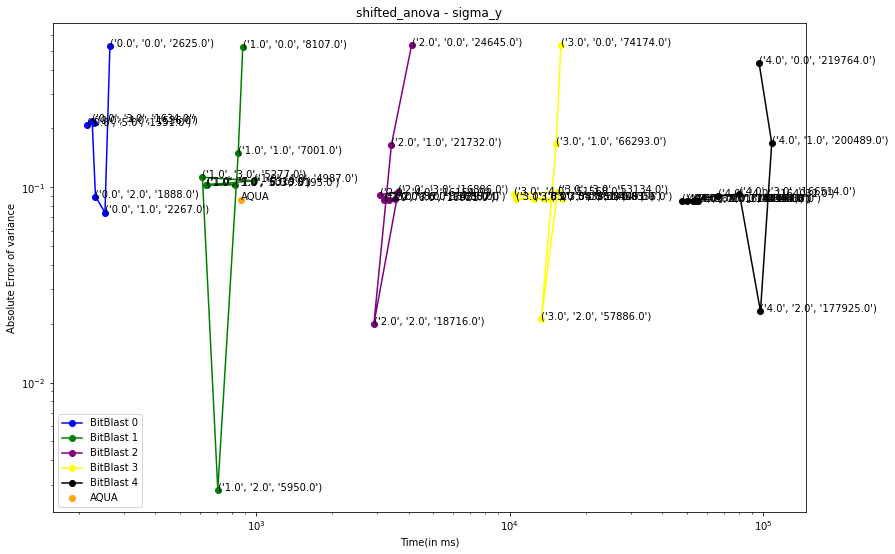

In [19]:
fig, ax = plotting_dice_data('variance', "shifted_anova", "sigma_y", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/shifted_anova/results_oneobs_shift_1.txt",
                            0, 5, 0, gt_variance['sigma_y'], AQUA_time, AQUA_sigma_variance, True, 's')

In [18]:
other_pts = [['Mathematica', ], ['HMC Stan', gt_mean]]

fig, ax = plotting_abs_exp('variance', "shifted_anova", "sigma_y", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/shifted_anova/results_oneobs_shift_1.txt",
                            0, 5, 0, 0.0, AQUA_time, AQUA_sigma_variance, False, 's', other_pts)

NameError: name 'other_pts' is not defined

5.293250516799597 10.12315734819145
7.817644801482596 0.4521376712936842


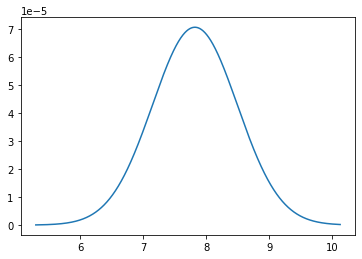

In [11]:
AQUA_mu_mean, AQUA_mu_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/conjugate/analysis_mu.txt")
print(AQUA_mu_mean, AQUA_mu_variance)